<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 4/24/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from O.G. Report 3.0 and new style from new dashboard. Trains on market 178 data starting 3/17/2025.</p>

In [371]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install keras-tuner
!pip install psutil


In [372]:
import warnings
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import platform

notebook_start_time = time.time()
%matplotlib inline
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
#prevents text wrapping from output
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 2000)        # Set a wide display width
pd.set_option('display.max_colwidth', None) # Show full content in each cell

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps
tensor([1.], device='mps:0')
tensor([1.], device='mps:0')


In [373]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
def cpu_info(): 
    if platform.system() == 'Windows': 
        return platform.processor() 
    elif platform.system() == 'Darwin': 
        command = '/usr/sbin/sysctl -n machdep.cpu.brand_string' 
        return os.popen(command).read().strip() 
    elif platform.system() == 'Linux': 
        command = 'cat /proc/cpuinfo' 
        return os.popen(command).read().strip() 
    return 'platform not identified' 
 
print(cpu_info()) 

Platform: macOS-15.7-arm64-arm-64bit
Platform processor: arm
Apple M4 Max


In [374]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


<h1>Select Store</h1>

In [375]:
selected_store = 3266   


In [376]:
def drop_embedded_headers(df):
    first_col = df.columns[0]
    header_str = ",".join(df.columns.astype(str))
    # Drop rows where first column == the entire header string
    df = df[df[first_col].astype(str) != header_str]
    # Drop rows where first column is literally the column name itself (e.g., "Store #")
    df = df[df[first_col].astype(str) != first_col]
    return df


In [377]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")
'''
test = False #flag for text files to csv 
delim_same = False #flag for same delimiter across files
market = False
# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test == True:
    csv_dir = "Data/TestTextInput/"  # Update this to your folder path
if market == True:
    csv_dir = "Data/MarketData/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    if test == True and delim_same == False:
        print("test == True and delim_same == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if test == True and delim_same == True:
        print("test == True and delim_same == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if market == True:
        print("market == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    else:
        print("test == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

if len(dataframes) > 0:
    dataframes[0].head()
    # Combine the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    #print(combined_df)
    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df
    #if 'Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate' in df.columns:
    #    df = df.drop('Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate', axis=1)

    df = drop_embedded_headers(df)
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")
    #df.drop_duplicates(subset=["Associate ID", "Day of Pick Date"], keep='first', inplace=True)
    df.reset_index(drop=True)
    print(f'Columns in df: {df.columns.unique()}')
    print(f'Before dropping duplicates: {df.shape}')
    df_unique = df.drop_duplicates()
    print(f'After dropping duplicates: {df_unique.shape}')
    df = df_unique
else:
    print("No DataFrames to combine.")

'''

'\ntest = False #flag for text files to csv \ndelim_same = False #flag for same delimiter across files\nmarket = False\n# Specify the directory where your CSV files are located\ncsv_dir = "Data/"  # Update this to your folder path\nif test == True:\n    csv_dir = "Data/TestTextInput/"  # Update this to your folder path\nif market == True:\n    csv_dir = "Data/MarketData/"  # Update this to your folder path\n# Use glob to get a list of all CSV files in the directory\ncsv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))\n# Create an empty list to store DataFrames\ndataframes = []\n# Loop through each file, read it into a DataFrame, and append it to the list\n# Process each file\nfor file_path in csv_files:\n    print(f"File being processed: {file_path}") \n    # Detect encoding\n    with open(file_path, "rb") as f:\n        result = chardet.detect(f.read(10000))   \n    encoding = result[\'encoding\']\n    print(f"Detected Encoding: {encoding}, Confidence: {result[\'conf

In [378]:
# test code
import pandas as pd
import chardet, os, glob

file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]

test = False  # flag for text files to csv
delim_same = False  # flag for same delimiter across files
market = False

# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test:
    csv_dir = "Data/TestTextInput/"
if market:
    csv_dir = "Data/MarketData/"

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))

#csv_files.extend(glob.glob(os.path.join(csv_dir, "AssociateByDay_*.csv")))
# Create an empty list to store DataFrames
dataframes = []

# Loop through each file, read it into a DataFrame, and append it to the list
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   

    # Read the file into a DataFrame
    try:
        if test and not delim_same:
            print("test == True and delim_same == False")
            df = pd.read_csv(file_path, encoding=encoding, engine="python")

        elif test and delim_same:
            print("test == True and delim_same == True")
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")

        elif market:
            print("market == True")
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")

        else:
            print("test == False")
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")

        dataframes.append(df)

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

# Combine DataFrames
if len(dataframes) > 0:
    dataframes[0].head()
    combined_df = pd.concat(dataframes, ignore_index=True)

    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df

    # 🔹 Universal header column cleanup
    for col in df.columns:
        if "," in col and len(col.split(",")) > 3:  # looks like an embedded header row
            print(f"Dropping embedded header column: {col}")
            df = df.drop(columns=[col])

    # Sort depending on available associate column
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True, False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True, False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")

    # Reset index and drop duplicates
    df.reset_index(drop=True, inplace=True)
    print(f'Columns in df: {df.columns.unique()}')
    print(f'Before dropping duplicates: {df.shape}')
    df_unique = df.drop_duplicates()
    print(f'After dropping duplicates: {df_unique.shape}')
    df = df_unique
else:
    print("No DataFrames to combine.")


File being processed: Data/ByAssociateView_6-20-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-25_3-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_8-16-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_7-4-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_7-8_7-9-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-1-_TO_3-12-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-4_3-5-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_7-6_7-7-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File bein

In [379]:
df['Store #'] = pd.to_numeric(df['Store #'], errors='coerce').fillna(0).astype(int)
if selected_store not in df['Store #'].unique():
    print(f"Store {selected_store} not found in the dataset.")
    selected_store = 3266
stores = df['Store #'].unique()
print(f"Selected store: {stores}")
store_market = {}
for store in stores:
    store_market[store] = 178
df['Market'] = df['Store #'].map(store_market)
#df.head()

Selected store: [3266 1844 1921 1977 2195 2518 3236 3830 5012 5142 5414    0]


In [380]:
df.sample(50)

Store #              Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty  SFS Pack Hours  SFS Packed Qty  SFS Pack Rate First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market
4256      1977         JOCELYNE ROJAS            Total   94.44%          288        272     151.5       1.87               280                3       0.0           22                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
3311      2518            MARY HANSEN            Total   94.74%           76         72      74.3       1.01                72                3       0.0            1                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
6692      3236   JUNETH ALVARADO ROCA            Total   79.37%          126        100      11.8       8.46               100                0       0.0           14                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
60265     2195        KATIUSKA RANGEL          6/10/25   88.93%          244        217      81.8       2.71               220                2       0.0           10                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
60716     1844           KEVIN HUBERT           5/9/25      NaN            0          0       NaN        0.0                 0                0       0.0            0                         1                           0                          0                      1             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
73234     2195        FERNANDA GUALAN          4/24/25   78.70%          230        181      60.0       3.78               202               25       0.0           25                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
21082     3236        TREZA GUIRGUESS            Total   90.59%        1,179      1,068      96.5      11.54             1,089               25       0.0           54                         1                           1                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
69909     5414             JOSE PAGAN           4/6/25   88.34%          489        432     137.4       3.43               447               24       0.0            6                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
8734      2195            SHAUN GROVE            Total   90.49%          326        295      67.8        4.6               295               17       0.0           15                         0                           0                          0                      0             NaN             NaN            NaN                  NaN                 NaN             NaN          NaN     178
27561     2195          JENAY MIRANDA          

In [381]:
def convert_weekday_number_to_day(date):
    switch = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switch.get(date.weekday(), "Invalid weekday number")

In [382]:
'''df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")'''
df = df.drop(['SFS Pack Hours', 'SFS Packed Qty', 'SFS Pack Rate'], axis=1)
df = df.dropna(subset=['Store #'])
df['Store #'] = df['Store #'].astype(int)

In [383]:
df.head()
df.loc[df['Store #'] == 1977, :].head()

Store #          Associate Day of Pick Date    FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market
964     1977       BRENDA LEYVA            Total  89.90%          515        463      82.0       5.92               468               17       0.0           19                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178
965     1977    BRYANNA SANCHEZ            Total  85.78%          204        175     116.3       1.69               177               20       0.0            8                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178
966     1977  DAGOBERTO TEHUTLE            Total  90.91%           55         50     103.0       0.52                54                0       0.0            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178
967     1977   DANIELA SANTIAGO            Total  85.90%          312        268     109.5        2.7               276               20       0.0           13                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178
968     1977    DENISE SANTIAGO            Total  90.99%          233        212     121.2       1.87               220                7       0.0            6                       114                           1                          9                    103                  NaN                 NaN             NaN          NaN     178

In [384]:
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel', 'k0b09gt' : 'KENNY BUSTAMANTE',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total',
    's0z06gj' : 'Sohrab Zarghanishiraz', 'f0w03c8': 'Fallon Wilcox', 'n0m0hav': 'Noah Mea',
    'cmo0039' : 'Carmen Olivera', 'occ0006' : 'Olga Caldas', 'a0a12k2' : 'Ana Alcantara Bonilla', 'a0y046n' : 'Andy Yunga',
    'b0p0cus' : 'Binalben Patel', 'c0l0p7g' : 'Chaojian Lawrence', 'g0k00w0' : 'Gurdip Kaur', 'h0w03bd' : 'Hla Win',
    'm0c08ob' : 'Maria Campos', 'mdcapan' : 'Maria Capano', 'm0i01db' : 'Maria Ixcopal', 'm0g0r9c' : 'Marina Garcia',
    'p0k010w' : 'Paramjit Kaur', 'p0p0136' : 'Parul Patel', 'r0j07ef' : 'Renu Juneja', 'sps0025' : 'Scott Suarez',
    's0d0j6p' : 'Sharonda Daniels', 's0m160e' : 'Shagelly Melgar', 'r0r0k5w' : 'Ryaan Rafi', 'a0s1maf' : 'Aidan Tobia',
    'a0r16c4' : 'Amaan Rafi', 'b0l01lp' : 'Bryan Lisboa Adames', 'mtslabo' : 'Martin Slaboda', 'djthras' : 'David Thrasher',
    'm0m0prn' : 'Michael Weiss', 'n0m05hq' : 'Nitin More', 'd0h0u6h' : 'Dipshikha Hazra', 'mmp00af' : 'Madhusudan Patel'

}
if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

In [385]:

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}
names_to_ids = {v: k for k, v in ids_to_names.items()}  # lowercase keys

# IDs to exclude if needed
ids_to_drop = {"csp", "total", "nsm"}

# Separate 3266 and other stores
df_selected_store = df[df['Store #'] == 3266].copy()
df_other = df[df['Store #'] != 3266].copy()

# Ensure Associate ID column exists
if "Associate ID" not in df_selected_store.columns:
    df_selected_store["Associate ID"] = None

# Fill missing Associate IDs for 3266
df_selected_store["Associate ID"] = df_selected_store.apply(
    lambda row: ids_to_names.get(str(row.get("Associate", "")).upper().strip(), row["Associate ID"])
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Remove dropped IDs from 3266
df_selected_store = df_selected_store[~df_selected_store["Associate ID"].str.lower().isin(ids_to_drop)]

# Add readable names
df_selected_store["Associate Name"] = df_selected_store["Associate ID"].map(names_to_ids).fillna("NA")

# Remove old Associate column from 3266
df_selected_store.drop(columns=["Associate"], inplace=True, errors="ignore")

# Reorder 3266 columns
for col in ["Associate ID", "Associate Name"]:
    vals = df_selected_store[col]
    df_selected_store.drop(columns=[col], inplace=True)
    df_selected_store.insert(0 if col == "Associate ID" else 1, col, vals)

# Combine 3266 and other stores back together
df = pd.concat([df_selected_store, df_other], ignore_index=True)

# Optional: Combine names cleanly into `Associate` if needed
def merge_names(row):
    name = row.get("Associate Name", "")
    original = row.get("Associate", "")

    if pd.isna(name) or name == "NA":
        return original
    elif pd.isna(original) or name.strip().lower() == original.strip().lower():
        return name
    else:
        return f"{name} ({original})"

if "Associate Name" in df.columns:
    df["Associate"] = df.apply(merge_names, axis=1)
else:
    df["Associate"] = df["Associate"]

df = df[df['Associate'] != 'nsm']
df = df[df['Associate'] != 'csp']
df = df[df['Associate'] != 'Total']
# Final cleanup
df.dropna(subset=['Associate'], inplace=True)
df['Store #'] = df['Store #'].astype(int)
print("Stores after filtering:", df["Store #"].unique())
print(df[df['Store #'] == selected_store][['Associate ID', 'Associate']].drop_duplicates())



Stores after filtering: [3266 1844 1921 1977 2195 2518 3236 3830 5012 5142 5414]
     Associate ID                  Associate
0         a0b0ad9              ANGELA BAIORI
37        a0c02mv             AURORA COMPRES
53        a0f0grp            ANDREA FIGUEROA
89        a0p0fc6               ANDREW PLAZA
110       a0s1jgx            ARPANA SILUMALA
143       azi0001                AMMAD IQBAL
145       c0c116s          CHRISTINA CUCITRO
155       c0p07a7               CHETNA PATEL
157       c0r0k4h                 CIANA RIPA
180       d0c0as3           DANIELLE CASIANO
212       d0r0khi               DANIEL RUSSO
231       dapanal             DANILO PANALES
252       e0e04sh              ERIK ENRIQUEZ
284       e0m0abw            ESTHER MARTINEZ
325       e0s0frj                ERICKA SUIN
341       g0n018d             GABRIEL NYDICK
369       h0p01q8                HEENA PATEL
381       hkmanga           HARMINDER MANGAT
383       j0a0f5h         JESSICA AMEGAVLUIE
401       j0p0vpl  

In [386]:
#df.sample(50)

In [387]:
df_temp = df.loc[df['Store #'] == 3266, :]
print(df_temp['Associate'].unique())
associate_list_3266 = ['ANGELA BAIORI', 'AURORA COMPRES', 'DANIEL RUSSO',
 'ERIK ENRIQUEZ', 'ESTHER MARTINEZ', 'ERICKA SUIN',
 'HEENA PATEL', 'JESICA PUGO', 'JULIA SIGUENCIA', 'KENNY BUSTAMANTE', 'MARIA SANCHEZ', 
 'NATHANIEL VENTURA', 'NOELIA VENTURA DE SANTANA', 
 'NICOLE WEAVER', 'SHAMIMA HAQUE MITU', 'SHUBHADA MENGLE', 
 'SIDDH PANDYA', 'SHARON TUFANO', 'TIERRA BROWN', 'VICTORIA MORALES', 'FALLON WILCOX', 'NOAH MEA',
 'Carmen Olivera', 'Olga Caldas', 'Ana Alcantara Bonilla', 'Andy Yunga', 'Binalben Patel', 
 'Chaojian Lawrence', 'Gurdip Kaur', 'Hla Win',
 'Maria Campos', 'Maria Capano', 'Maria Ixcopal', 'Marina Garcia',
 'Paramjit Kaur', 'Parul Patel', 'Renu Juneja', 'Scott Suarez', 'Sharonda Daniels',
 'Shagelly Melgar', 'Dipshikha Hazra', 'Madhusudan Patel']
former_associates_3266 = ['ANDREW PLAZA', 'ARPANA SILUMALA', 'LUCILLE LAWSON', 'MAGDALENA GRIJALVA','MIROLLA SAID', 'Kishor Khetia','ANDREA FIGUEROA']
fashion_associates = ['VICTORIA MORALES', 'SILVIA ROCANO', 'YNGRID PENA SOSA', 'SOHRAB ZARGHANISHIRAZ',
                      'Carmen Olivera', 'Olga Caldas', 'Ana Alcantara Bonilla', 'Andy Yunga',
                      'Binalben Patel', 'Chaojian Lawrence', 'Gurdip Kaur', 'Hla Win',
                      'Maria Campos', 'Maria Capano', 'Maria Ixcopal', 'Marina Garcia',
                      'Paramjit Kaur', 'Parul Patel', 'Renu Juneja', 'Scott Suarez', 'Sharonda Daniels']
management_list_3266 = ['CHRISTINA CUCITRO', 'DANIELLE CASIANO', 'DANILO PANALES', 
                        'GABRIEL NYDICK', 'HARMINDER MANGAT', 'RENU SINGH', 'MATTHEW BEDNARCZUK', 
                        'RASHEED WALLACE', 'STEPHANIE MORABITO', 'SOHRAB ZARGHANISHIRAZ', 'CIANA RIPA',
                        'AMAAN RAFI', 'RYAAN RAFI', 'MARTIN SLABODA', 'MICHAEL WEISS',
                        'DAVID THRASHER', 'AIDAN TOBIA', 'BRYAN LISBOA ADAMES', 'NITIN MORE']
associate_list_3266 = [name.upper() for name in associate_list_3266]
fashion_associates = [name.upper() for name in fashion_associates]
management_list_3266 = [name.upper() for name in management_list_3266]
former_associates_3266 = [name.upper() for name in former_associates_3266]

['ANGELA BAIORI' 'AURORA COMPRES' 'ANDREA FIGUEROA' 'ANDREW PLAZA'
 'ARPANA SILUMALA' 'AMMAD IQBAL' 'CHRISTINA CUCITRO' 'CHETNA PATEL'
 'CIANA RIPA' 'DANIELLE CASIANO' 'DANIEL RUSSO' 'DANILO PANALES'
 'ERIK ENRIQUEZ' 'ESTHER MARTINEZ' 'ERICKA SUIN' 'GABRIEL NYDICK'
 'HEENA PATEL' 'HARMINDER MANGAT' 'JESSICA AMEGAVLUIE' 'JESICA PUGO'
 'JOHN MCKENNA' 'JULIA SIGUENCIA' 'KISHOR KHETIA' 'LUCILLE LAWSON'
 'MAGDALENA GRIJALVA' 'MIROLLA SAID' 'MARIA SANCHEZ' 'NATHANIEL VENTURA'
 'NOELIA VENTURA DE SANTANA' 'NICOLE WEAVER' 'RENU SINGH'
 'SHAMIMA HAQUE MITU' 'SHUBHADA MENGLE' 'SIDDH PANDYA' 'SHARON TUFANO'
 'TIERRA BROWN' 'WIJESIRI DESILVA' 'VICTORIA MORALES' 'MATTHEW BEDNARCZUK'
 'NOAH MEA' 'FALLON WILCOX' 'KENNY BUSTAMANTE' 'IVET SAQUICELA'
 'RASHEED WALLACE' 'SCOTT SUAREZ' 'DIPSHIKHA HAZRA' 'MADHUSUDAN PATEL'
 'MARIA IXCOPAL' 'PARAMJIT KAUR' 'STEPHANIE MORABITO' 'CARMEN OLIVERA'
 'PARUL PATEL' 'SHAGELLY MELGAR' 'MILTON TORRES' 'SOHRAB ZARGHANISHIRAZ'
 'HLA WIN' 'RYAAN RAFI' 'GURDIP KAUR']


<H1>Cell below works for store 3266. Will filter out all other stores.</h1>

In [388]:
#df.loc[df['Associate Name'] == 0, :].head()

In [389]:
'''

print("Stores before filtering:", df["Store #"].unique())

#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}


if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
#df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
#df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)
print(f'\nAssociate Name: {df['Associate Name'].unique()}\n')
print(f'\nAssociate: {df['Associate'].unique()}\n')
df_selected_store = df.loc[df['Store #'] == selected_store, :]
print("Stores after filtering:", df["Store #"].unique())


'''

'\n\nprint("Stores before filtering:", df["Store #"].unique())\n\n#df = df[df["Associate ID"] != "csp"]\nids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucil

In [390]:
'''ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
# Dictionary mapping IDs to Names
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chatna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}

# Convert all dictionary keys to lowercase (for IDs) and uppercase (for Names)
names_to_ids = {k.lower().strip(): v.upper().strip() for k, v in names_to_ids.items()}
ids_to_names = {v.upper().strip(): k.lower().strip() for k, v in names_to_ids.items()}

# Ensure "Associate ID" and "Associate Name" columns exist
if "Associate ID" not in df.columns:
    df["Associate ID"] = None
if "Associate Name" not in df.columns:
    df["Associate Name"] = None

# Convert columns to string, strip spaces, and normalize case
df["Associate ID"] = df["Associate ID"].astype(str).str.lower().str.strip().replace("none", None)
df["Associate Name"] = df["Associate Name"].astype(str).str.upper().str.strip().replace("NONE", None)

# Preserve original columns
original_columns = df.columns.tolist()

# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate Name"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Fill missing Associate Name using Associate ID
df["Associate Name"] = df.apply(
    lambda row: names_to_ids.get(row["Associate ID"], row["Associate Name"]) 
    if pd.isna(row["Associate Name"]) or row["Associate Name"] is None else row["Associate Name"],
    axis=1
)

# Ensure we are not accidentally dropping other columns
df = df[original_columns]

# Debugging: Print final columns to verify
print("Final columns in DataFrame:", df.columns.tolist())

# Print a preview of the DataFrame to check
print(df.head())
'''



'ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\n# Dictionary mapping IDs to Names\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson\',\n    \'m0g065v\': \'Magdalena Grijalva\', \'m0s0q17\': \

In [391]:
df.head(75)
#df.set_index('Associate', inplace=True)
df.loc[df['Associate Name'] == 'NA', :]

Empty DataFrame
Columns: [Associate ID, Associate Name, Store #, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Market, Associate]
Index: []

In [392]:
df.loc[df['Associate ID'] == "NA", :]

Empty DataFrame
Columns: [Associate ID, Associate Name, Store #, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Market, Associate]
Index: []

In [393]:
df = df.loc[df["Day of Pick Date"] != "Total"] # market data starting from 3/17/2025
df['Store #'] = df['Store #'].astype(int)
#df.head(10)

In [394]:
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df['Day of Week #'] = df['Day of Pick Date'].dt.dayofweek.astype(int)
df['Day of Week'] = df['Day of Pick Date'].apply(convert_weekday_number_to_day)

In [395]:
df.loc[df['Associate ID'] == 0, :]

Empty DataFrame
Columns: [Associate ID, Associate Name, Store #, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Market, Associate, Day of Week #, Day of Week]
Index: []

In [396]:
# Replace NaN values with 0
#df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
# Ensure both columns are cleaned and converted to numeric
if 'Qty Req to Pick' in df.columns:
    df['Qty Req to Pick'] = df['Qty Req to Pick'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Qty Req to Pick'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
if 'FTP Expected' in df.columns:
    df['FTP Expected'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Expected'].fillna(0, inplace=True).astype(int)
if 'Picked As Req Qty' in df.columns:    
    df['Picked As Req Qty'] = df['Picked As Req Qty'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Picked As Req Qty'].fillna(0, inplace=True).astype(int)
if 'FTP Actual' in df.columns:
    df['FTP Actual'] = df['FTP Actual'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Actual'].fillna(0, inplace=True).astype(int)
# Replace 0 values in 'Qty Req to Pick' with corresponding values from 'FTP Expected'
#df.loc[df['Qty Req to Pick'] == 0, 'Qty Req to Pick'] = df.loc[df['Qty Req to Pick'] == 0, 'FTP Expected']
df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
df['Picked As Req Qty'] = df['Picked As Req Qty'].mask(df['Picked As Req Qty'] == 0, df['FTP Actual'])
df['FTP Actual'] = df['FTP Actual'].mask(df['FTP Actual'] == 0, df['Picked As Req Qty'])
df = df.loc[:,:].fillna(0)

# Ensure 'Qty Req to Pick' is numeric
df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
df = df.dropna()
df.head()
#df.loc[df['Store #'] == 1844, :].head(20)

Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual Pick Rate Pick Hours  Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week
10      a0b0ad9  ANGELA BAIORI     3266       2025-02-05   97.01           233         227      60.0       3.86                227                4       0.0            3                         0                           0                          0                      0                    0                   0              233     178  ANGELA BAIORI              2   Wednesday
12      a0b0ad9  ANGELA BAIORI     3266       2025-02-02   97.03           268         254      59.0       4.36                254                2       0.0           10                         0                           0                          0                      0                    0                   0              268     178  ANGELA BAIORI              6      Sunday
13      a0b0ad9  ANGELA BAIORI     3266       2024-12-29   92.92           214         199      42.0       4.88                199                6       0.0            4                         0                           0                          0                      0                    0                   0              214     178  ANGELA BAIORI              6      Sunday
14      a0b0ad9  ANGELA BAIORI     3266       2024-12-27  100.00            47          47      79.0        0.6                 47                0       0.0            0                         0                           0                          0                      0                    0                   0               47     178  ANGELA BAIORI              4      Friday
15      a0b0ad9  ANGELA BAIORI     3266       2024-12-26   92.66           223         212      51.0       4.18                212                3       0.0            5                         2                           0                          0                      2                    0                   0              223     178  ANGELA BAIORI              3    Thursday

In [397]:
#df.loc["a0b0ad9", :]
#df = df.loc[df["Day of Pick Date"] != "Total"]
df.loc[df["Associate ID"] == "a0b0ad9" ,:]

Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual Pick Rate Pick Hours  Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week
10        a0b0ad9  ANGELA BAIORI     3266       2025-02-05   97.01           233         227      60.0       3.86                227                4       0.0            3                         0                           0                          0                      0                    0                   0              233     178  ANGELA BAIORI              2   Wednesday
12        a0b0ad9  ANGELA BAIORI     3266       2025-02-02   97.03           268         254      59.0       4.36                254                2       0.0           10                         0                           0                          0                      0                    0                   0              268     178  ANGELA BAIORI              6      Sunday
13        a0b0ad9  ANGELA BAIORI     3266       2024-12-29   92.92           214         199      42.0       4.88                199                6       0.0            4                         0                           0                          0                      0                    0                   0              214     178  ANGELA BAIORI              6      Sunday
14        a0b0ad9  ANGELA BAIORI     3266       2024-12-27  100.00            47          47      79.0        0.6                 47                0       0.0            0                         0                           0                          0                      0                    0                   0               47     178  ANGELA BAIORI              4      Friday
15        a0b0ad9  ANGELA BAIORI     3266       2024-12-26   92.66           223         212      51.0       4.18                212                3       0.0            5                         2                           0                          0                      2                    0                   0              223     178  ANGELA BAIORI              3    Thursday
...           ...            ...      ...              ...     ...           ...         ...       ...        ...                ...              ...       ...          ...                       ...                         ...                        ...                    ...                  ...                 ...              ...     ...            ...            ...         ...
6167      a0b0ad9  ANGELA BAIORI     3266       2025-02-23   96.77           279         271      72.0       3.81                271                3       0.0            6                         0                           0                          0                      0                    0                   0              279     178  ANGELA BAIORI              6      Sunday
6192      a0b0ad9  ANGELA BAIORI     3266       2025-02-21   96.84           258         245      44.0       5.71                245                5       0.0            1                         0                           0                          0                      0                    0                   0              258     178  ANGELA BAIORI              4      Friday
6207      a0b0ad9  ANGELA BAIORI     3266       2025-02-20   95.69           235         227      54.0       4.29                227                3       0.0            1                         0                           0                          0                      0                    0                   0              235     178  ANGELA BAIORI              3    Thursday
6234      a0b0ad9  ANGELA BAIORI     3266       2025-02-18   99.35           154         153      50.0        3.1                153                1      

In [398]:
df.loc[df['Associate ID'] == "rsw000v" , :]
#df.loc[df['Associate Name'] == "Victoria Morales", :]

Associate ID   Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual Pick Rate Pick Hours  Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week
3064      rsw000v  RASHEED WALLACE     3266       2025-09-03   91.35           185         169      54.0       3.33                170               10       0.0           19                         1                           0                          0                      1                    0                   0              185     178  RASHEED WALLACE              2   Wednesday
3078      rsw000v  RASHEED WALLACE     3266       2025-09-02   96.05            76          73      37.0       2.08                 73                4       0.0            8                         0                           0                          0                      0                    0                   0               76     178  RASHEED WALLACE              1     Tuesday
4889      rsw000v  RASHEED WALLACE     3266       2025-04-04   84.62            39          33      53.7       0.62                 33                0       0.0            6                         0                           0                          0                      0                    0                   0               39     178  RASHEED WALLACE              4      Friday
4905      rsw000v  RASHEED WALLACE     3266       2025-04-04   84.62            39          33      53.7       0.62                 33                0       0.0            6                         0                           0                          0                      0                    0                   0               39     178  RASHEED WALLACE              4      Friday
5470      rsw000v  RASHEED WALLACE     3266       2025-03-05   83.04             0          94     110.0       0.97                 94               13       0.0            5                         2                           1                          1                      0                  112                  93                0     178  RASHEED WALLACE              2   Wednesday
5839      rsw000v  RASHEED WALLACE     3266       2025-03-20  100.00             2           2     300.0       0.01                  2                0       0.0            0                         0                           0                          0                      0                    0                   0                2     178  RASHEED WALLACE              3    Thursday
5855      rsw000v  RASHEED WALLACE     3266       2025-03-20  100.00             2           2     300.0       0.01                  2                0       0.0            0                         0                           0                          0                      0                    0                   0                2     178  RASHEED WALLACE              3    Thursday
6333      rsw000v  RASHEED WALLACE     3266       2025-02-11   91.18            34          31      63.0        0.5                 31                1       0.0            0                         0                           0                          0                      0                    0                   0               34     178  RASHEED WALLACE              1     Tuesday

In [399]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')
df_selected_store = df.loc[df['Store #'] == selected_store, :]

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    oldest_pick_date = df["Day of Pick Date"].min()
    last_pick_date = df["Day of Pick Date"].max()
    oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
    last_pick_date = pd.to_datetime(last_pick_date).date()
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except FileExistsError:
        print(f"Directory '{"Data/Combined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
#combine_data_to_csv()
#df.loc[df["Associate ID"] == "a0b0ad9", :]
oldest_pick_date = df_selected_store["Day of Pick Date"].min()
last_pick_date = df_selected_store["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()

start date: 2024-12-20
end date: 2025-09-03


In [400]:
def cols_to_convert_to_float(df):
    cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [401]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
#df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
#df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')
cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty',
    'Pick Rate'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_selected_store = df.loc[df['Store #'] == selected_store, :].copy()
# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df_selected_store[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df_selected_store.groupby(['Week', 'Associate']).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 45716 entries, 10 to 81200
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Associate ID                 45716 non-null  object        
 1   Associate Name               45716 non-null  object        
 2   Store #                      45716 non-null  int64         
 3   Day of Pick Date             45716 non-null  datetime64[ns]
 4   FTPR                         45716 non-null  float64       
 5   FTP Expected                 45716 non-null  int64         
 6   FTP Actual                   45716 non-null  int64         
 7   Pick Rate                    45716 non-null  object        
 8   Pick Hours                   45716 non-null  object        
 9   Picked As Req Qty            45716 non-null  int64         
 10  Substitution Qty             45716 non-null  object        
 11  Ovrd Qty                     45716 non-null  

Week          Associate  total_qty_req_to_pick  total_picked_qty  avg_pick_rate  total_substitution_qty  total_nil_pick_qty  total_exception_qty_req  total_exception_picked_qty  total_exception_substitution_qty  total_exception_nil_pick_qty
0  2024-12-14 to 2024-12-20    ANDREA FIGUEROA                    147               144           55.0                       1                   2                        1                           1                                 0                             0
1  2024-12-14 to 2024-12-20       ANDREW PLAZA                     50                49           36.0                       0                   0                        0                           0                                 0                             0
2  2024-12-14 to 2024-12-20  CHRISTINA CUCITRO                      4                 4           46.0                       0                   0                        0                           0                                 0                             0
3  2024-12-14 to 2024-12-20       DANIEL RUSSO                     34                32           81.0                       2                   0                        0                           0                                 0                             0
4  2024-12-14 to 2024-12-20        ERICKA SUIN                     55                50           45.0                       0                   5                        0                           0                                 0                             0

In [402]:
if selected_store == 3266:
    weekly_data.loc[weekly_data['Associate'] == 'ANDREW PLAZA', :]

In [403]:
#df.loc[df['Associate ID'] == 'a0p0fc6']

In [404]:
unique_ids = df["Associate"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [405]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [406]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [407]:
avdf = df_selected_store.groupby(["Associate ID", "Associate"]).mean(numeric_only=True)

In [408]:
avdf.head()

Store #       FTPR  FTP Expected  FTP Actual  Pick Rate  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Day of Week #
Associate ID Associate                                                                                                                                                                                                                                                                                
a0b0ad9      ANGELA BAIORI     3266.0  95.410455    177.350649  181.279221  49.622078         182.532468          3.448052       0.0      5.681818                   1.051948                     0.279221                    0.136364                0.623377       177.350649   178.0       3.266234
a0c02mv      AURORA COMPRES    3266.0  90.330189     69.603774   69.339623  38.794340          69.433962          2.188679       0.0      3.660377                   0.660377                     0.037736                    0.283019                0.169811        69.603774   178.0       4.132075
a0f0grp      ANDREA FIGUEROA   3266.0  96.136066    103.049180  103.131148  54.678689         103.180328          2.213115       0.0      2.229508                   0.278689                     0.147541                    0.114754                0.016393       103.049180   178.0       3.114754
a0p0fc6      ANDREW PLAZA      3266.0  87.870882     64.735294   59.852941  43.283824          62.500000          2.000000       0.0      3.220588                   1.235294                     0.294118                    0.147059                0.764706        64.735294   178.0       3.500000
a0s1jgx      ARPANA SILUMALA   3266.0  94.284627    137.507463  142.119403  43.091045         142.373134          2.492537       0.0      6.000000                   0.223881                     0.164179                    0.014925                0.044776       137.507463   178.0       2.567164

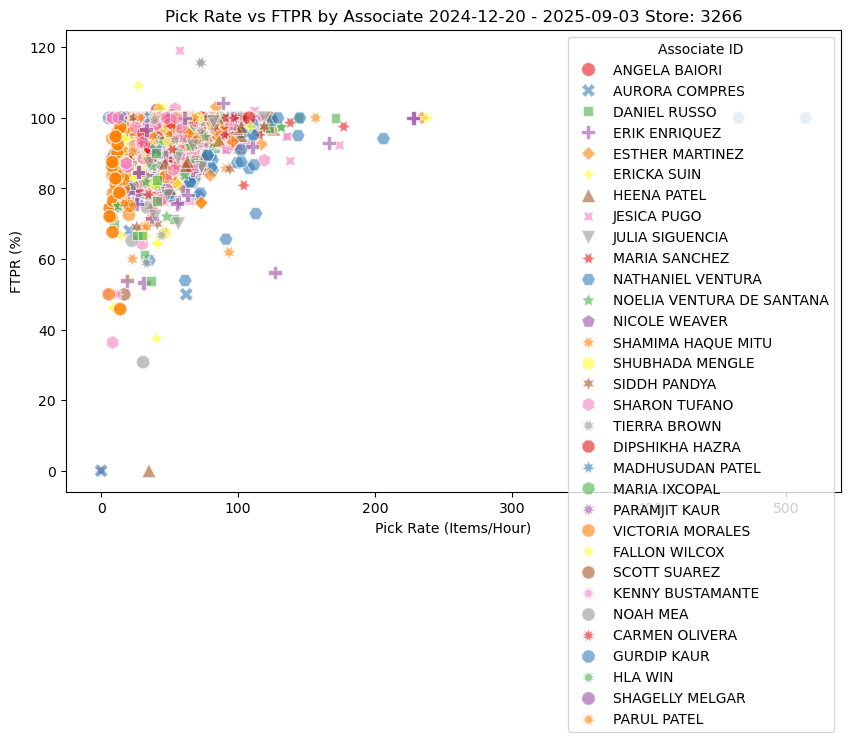

In [409]:
# Scatter plot with Pick Rate vs FTPR
#selected_store = 3266
df_selected_store = df[df['Store #'] == selected_store]

# Apply associate filter only for store 3266
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_selected_store,  # use the correctly filtered DataFrame
    x='Pick Rate', y='FTPR',
    hue='Associate', palette='Set1',
    style='Associate', s=100, alpha=0.6
)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()

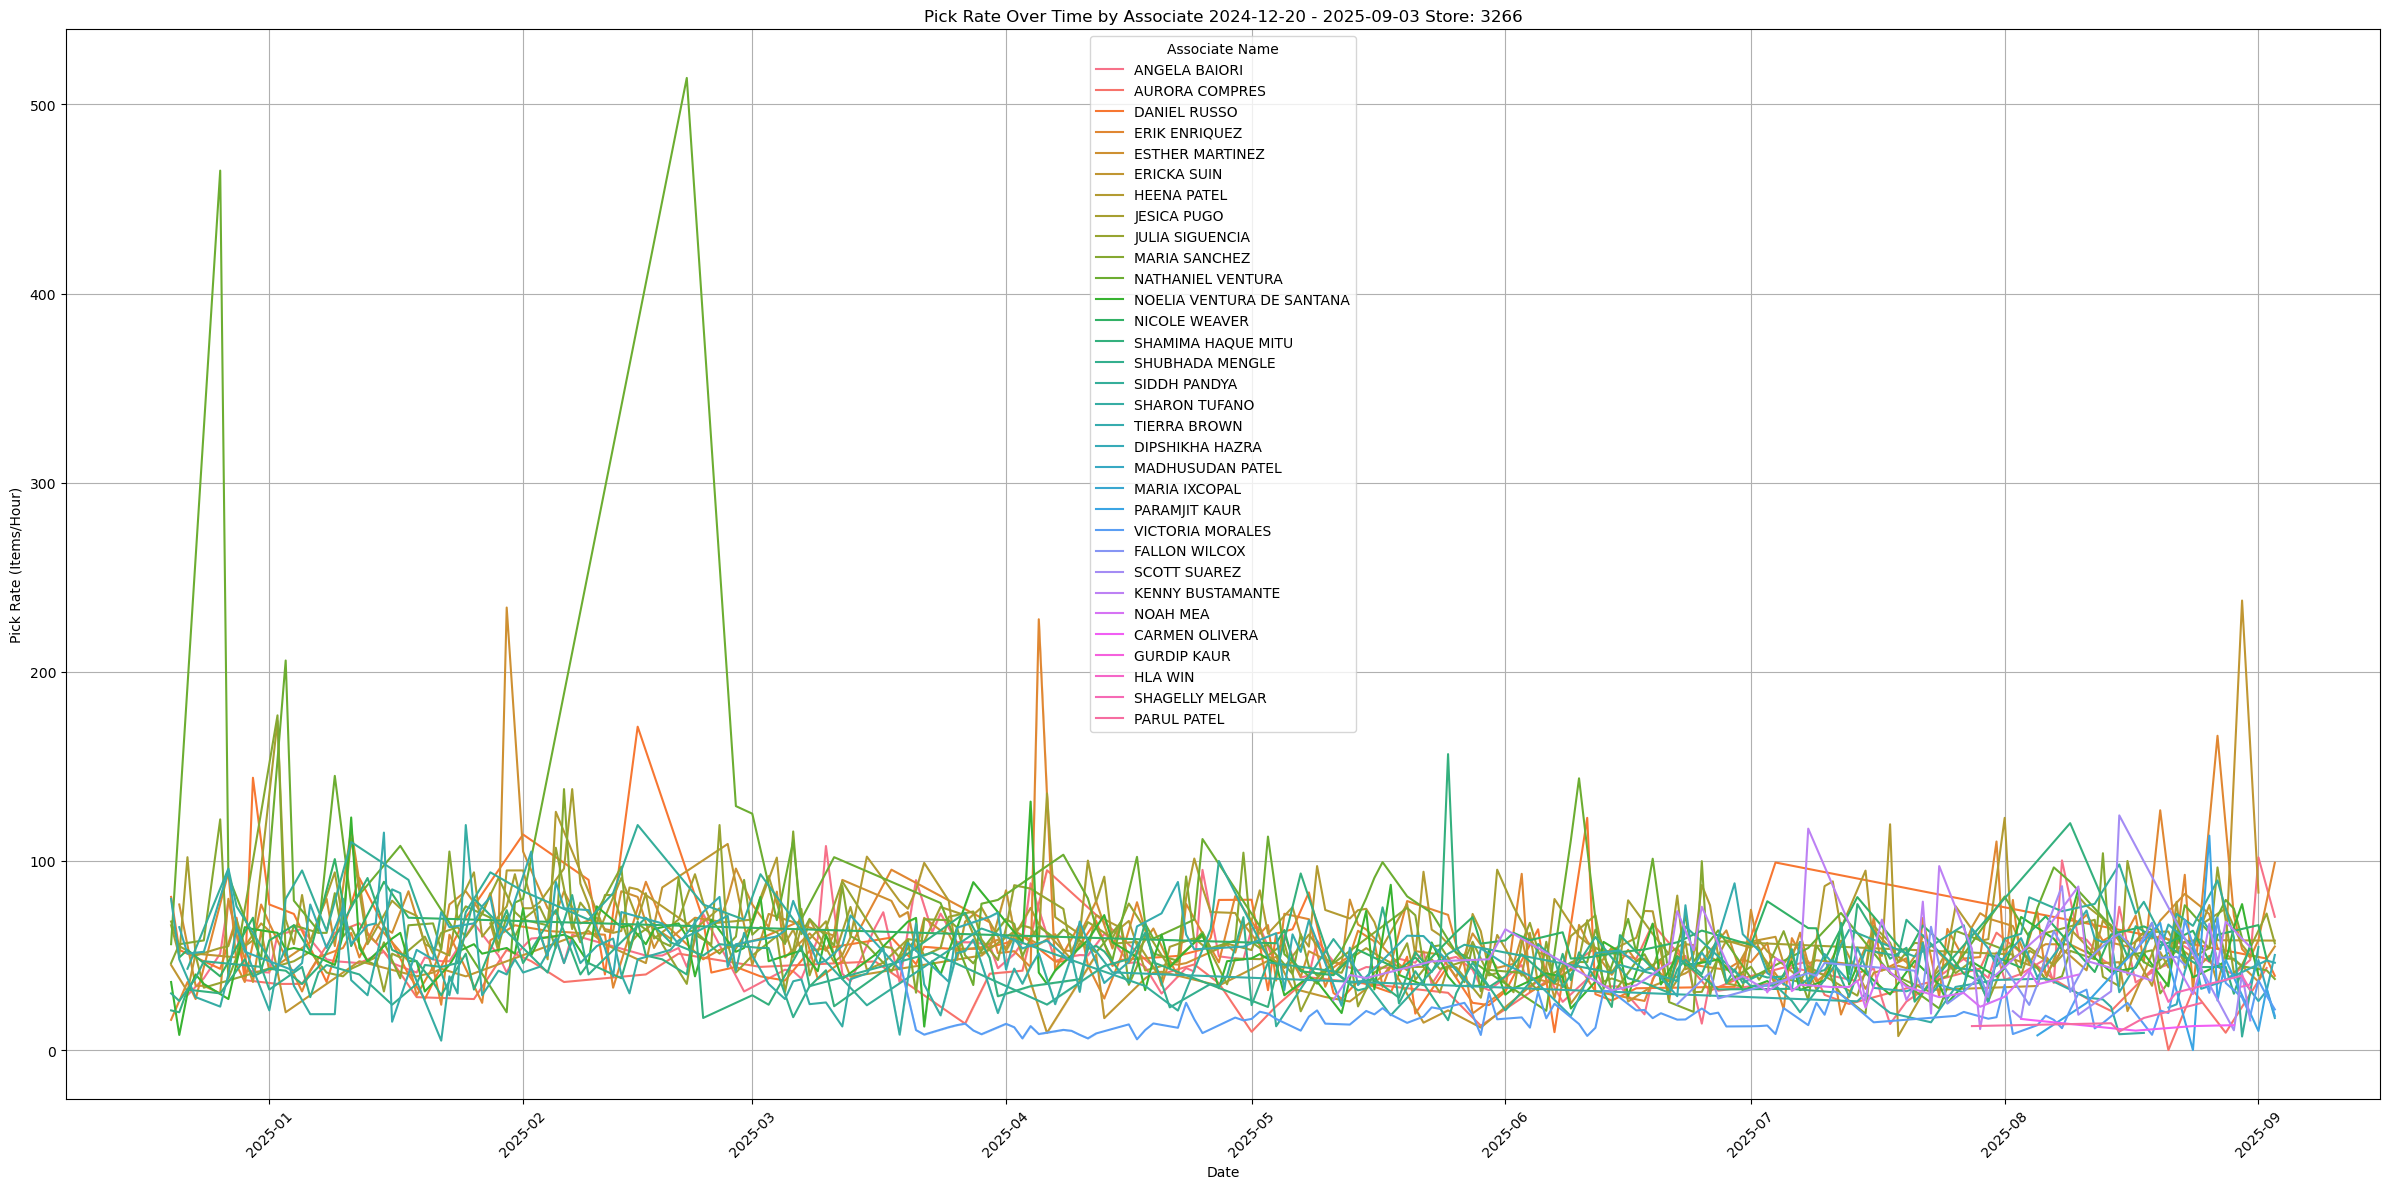

In [410]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df_selected_store['Day of Pick Date'] = pd.to_datetime(df_selected_store['Day of Pick Date'], format='%m/%d/%y')
df_selected_store = df_selected_store.drop_duplicates()

# Filter associates appropriately
if selected_store == 3266:
    df_selected_store_associates_only = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]
else:
    df_selected_store_associates_only = df_selected_store

# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(
    data=df_selected_store_associates_only,
    x='Day of Pick Date', y='Pick Rate',
    hue='Associate', markers=True
)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.grid(True)
plt.tight_layout()
plt.show()

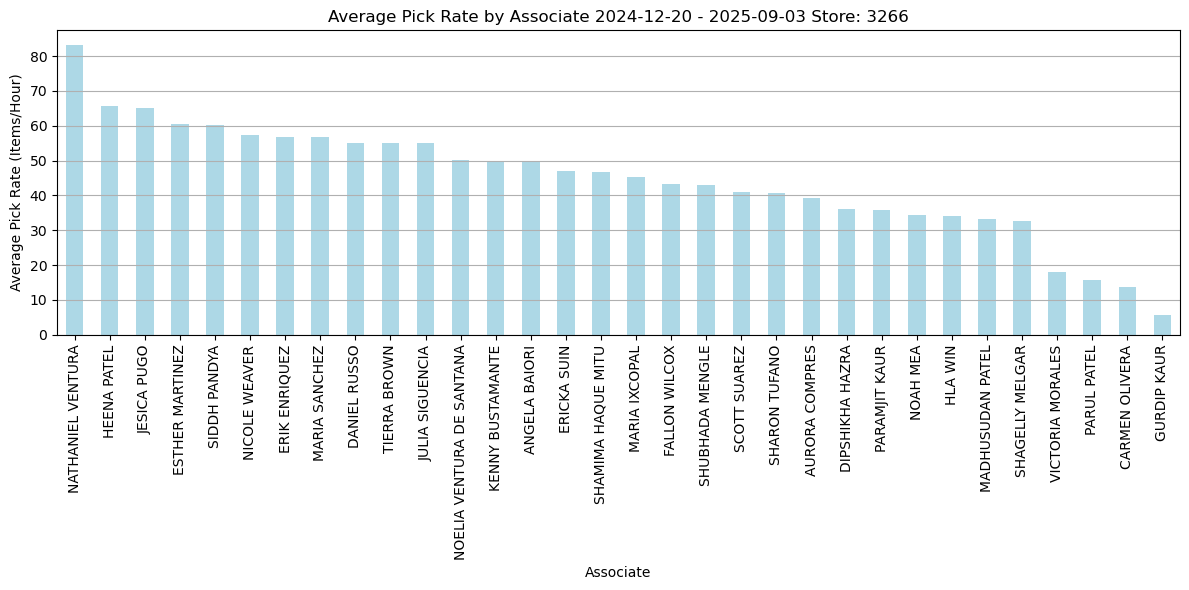

Associate
NATHANIEL VENTURA            83.204651
HEENA PATEL                  65.582270
JESICA PUGO                  64.986395
ESTHER MARTINEZ              60.437870
SIDDH PANDYA                 60.110294
NICOLE WEAVER                57.437097
ERIK ENRIQUEZ                56.648201
MARIA SANCHEZ                56.635556
DANIEL RUSSO                 55.144156
TIERRA BROWN                 55.104762
JULIA SIGUENCIA              55.074269
NOELIA VENTURA DE SANTANA    50.258333
KENNY BUSTAMANTE             49.766667
ANGELA BAIORI                49.703974
ERICKA SUIN                  47.104211
SHAMIMA HAQUE MITU           46.756842
MARIA IXCOPAL                45.300000
FALLON WILCOX                43.183333
SHUBHADA MENGLE              42.906977
SCOTT SUAREZ                 40.890909
SHARON TUFANO                40.769811
AURORA COMPRES               39.180392
DIPSHIKHA HAZRA              36.190909
PARAMJIT KAUR                35.936364
NOAH MEA                     34.357895
HLA WIN        

In [411]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df_selected_store.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Associate')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

avg_pick_rate

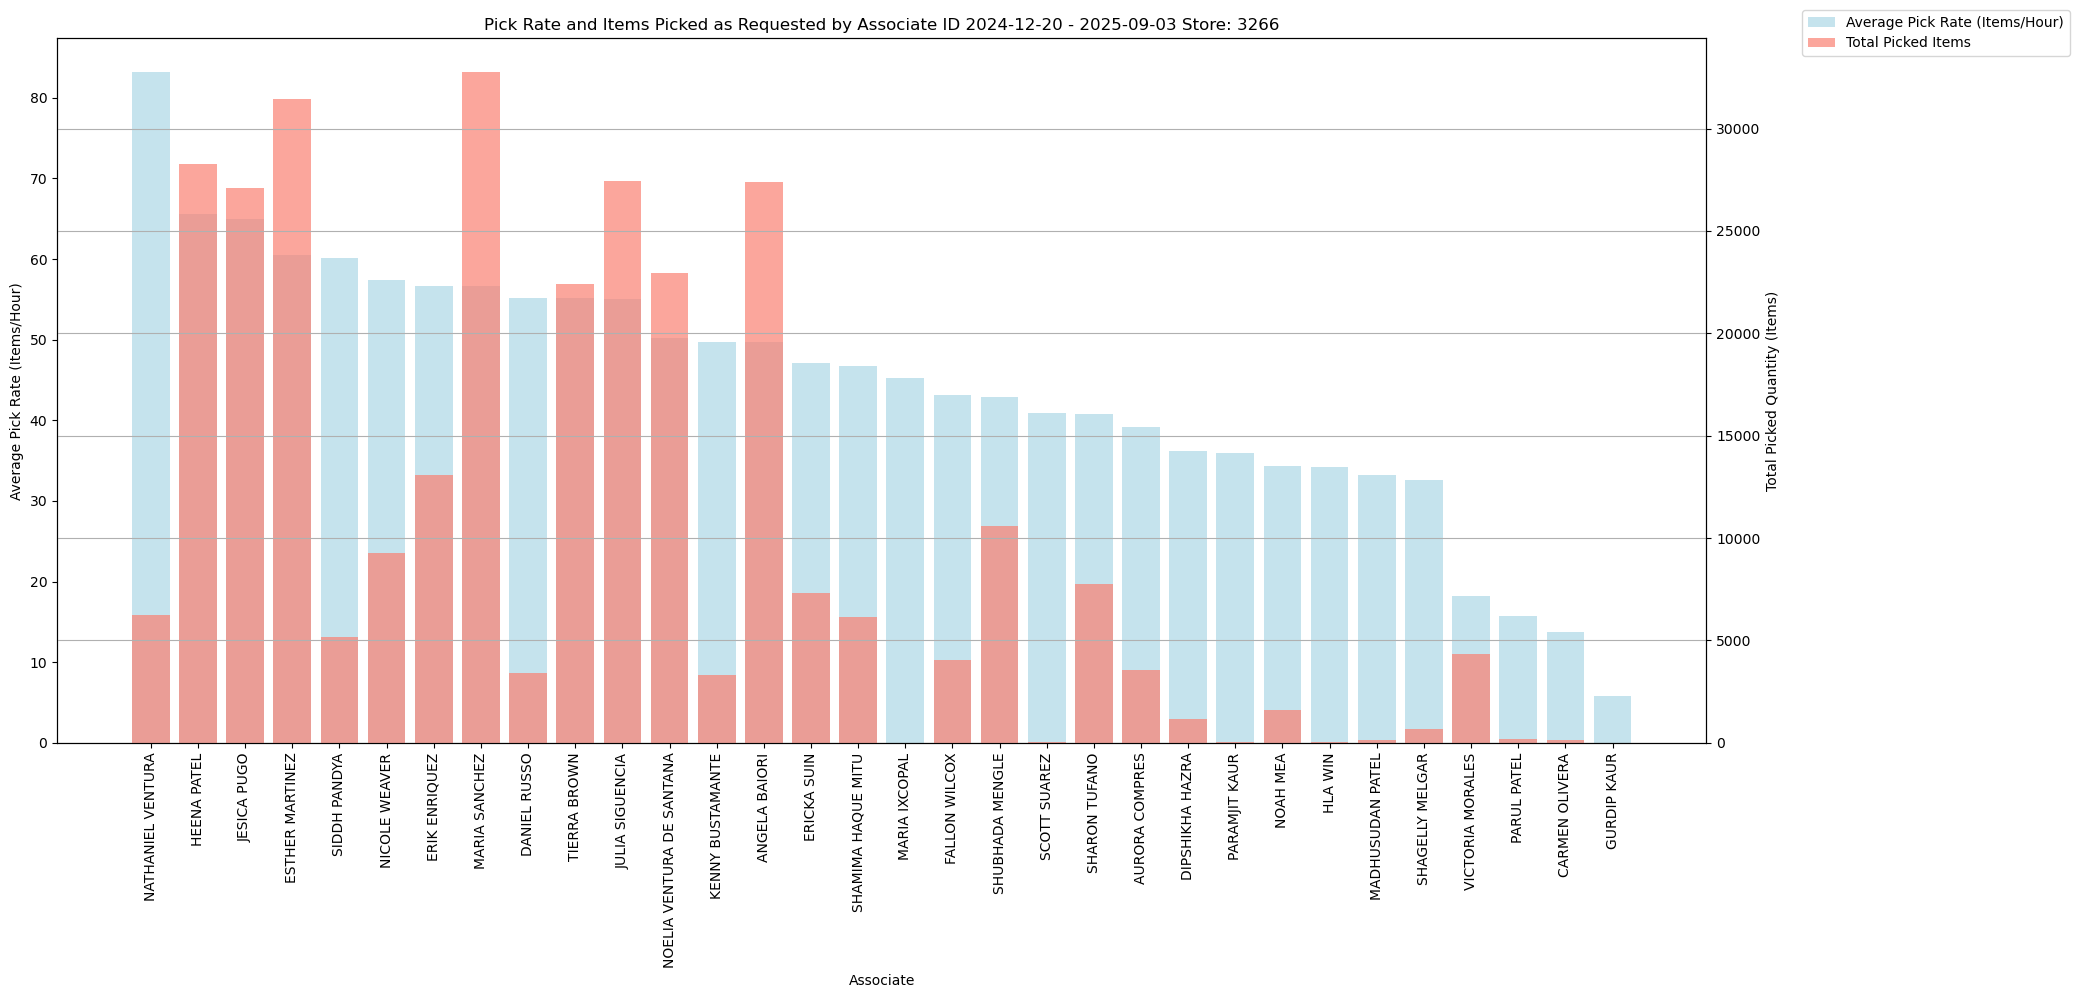

In [412]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

df_selected_store = df_selected_store.loc[df_selected_store['Store #'] == selected_store, :]

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))
avg_pick_rate.index = avg_pick_rate.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


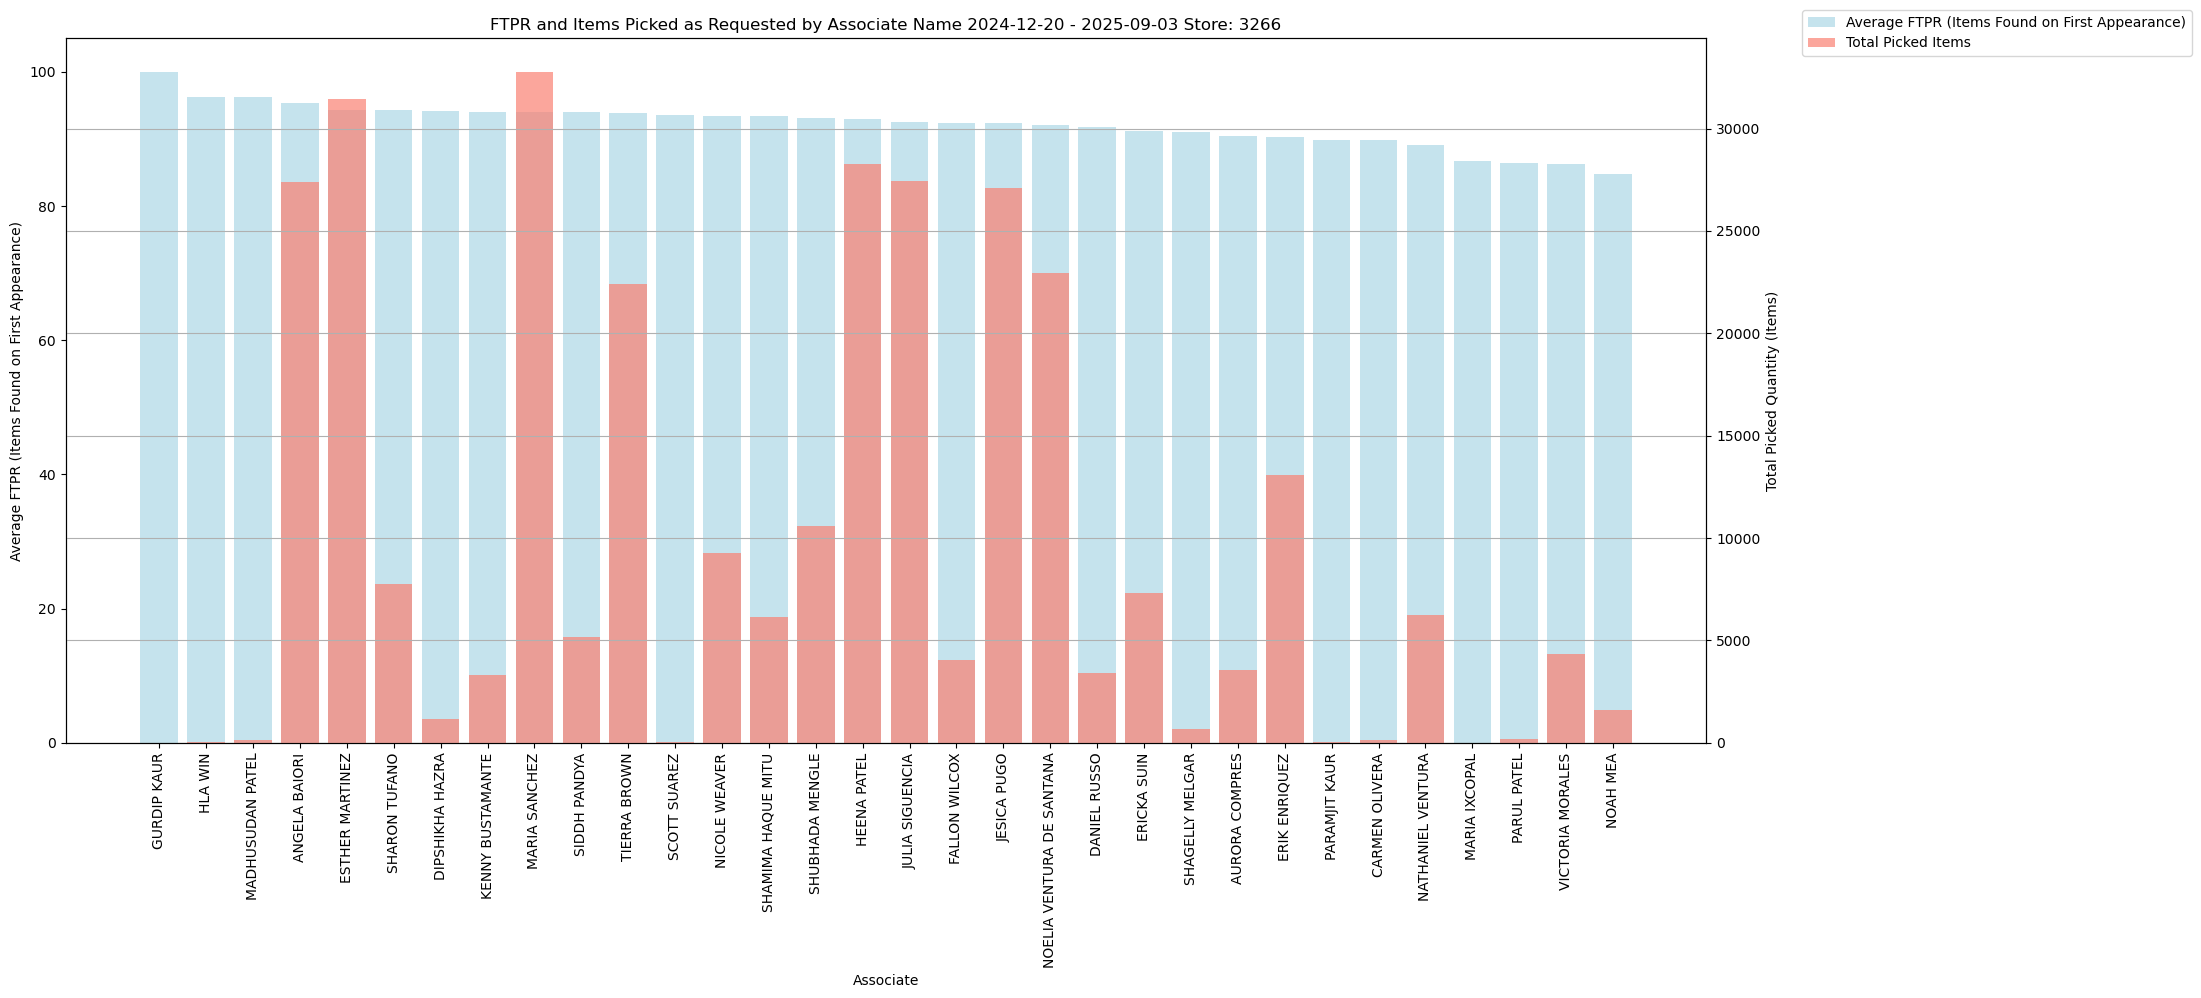

In [413]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['FTPR'] = pd.to_numeric(df_selected_store['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate')['FTPR'].mean().astype(float).sort_values(ascending=False)
if selected_store == 3266:
    avg_ftpr = avg_ftpr[avg_ftpr.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

avg_ftpr.index = avg_ftpr.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate Name {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

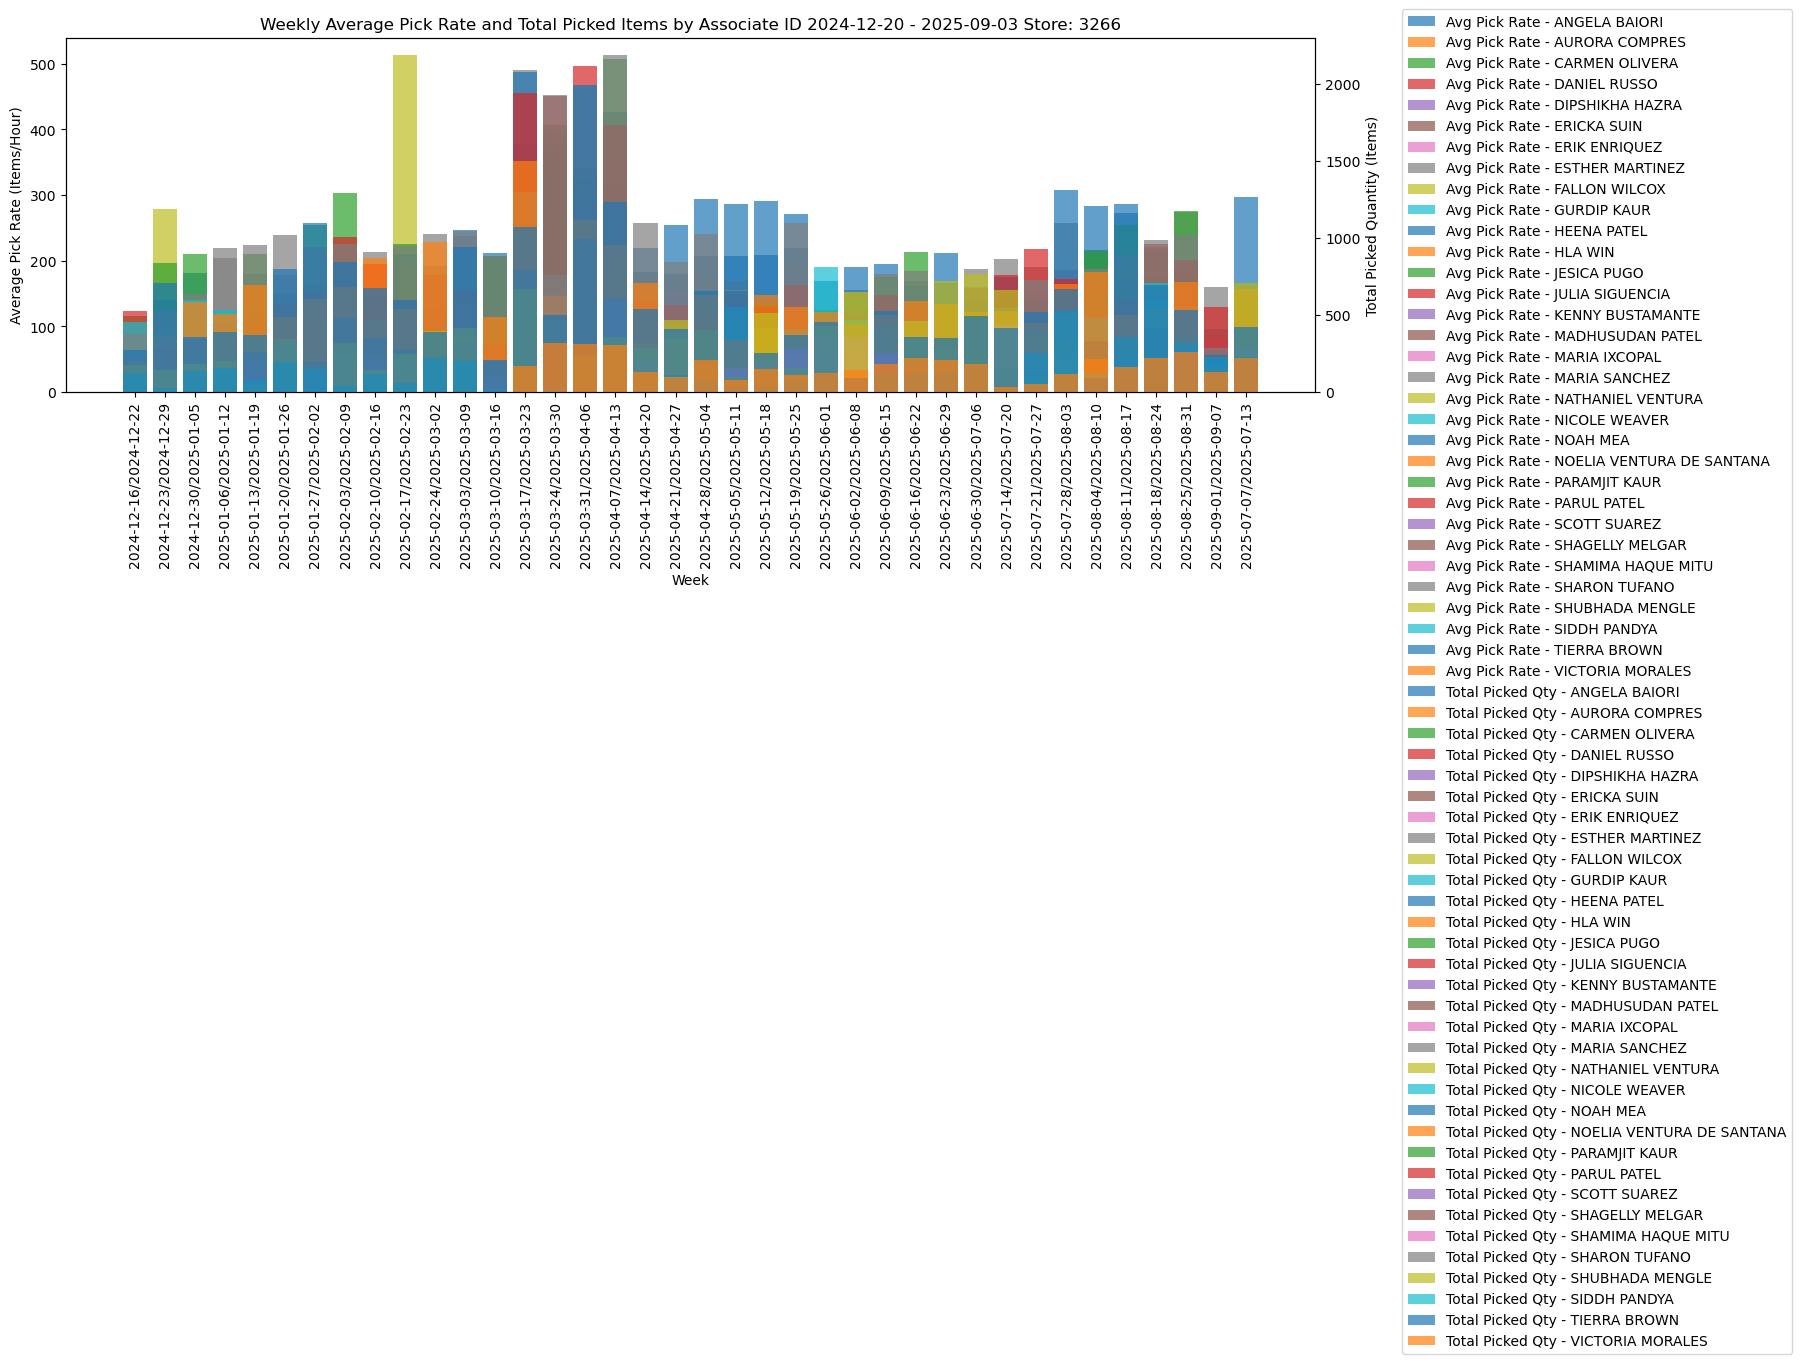

In [414]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]
df_clean = df_clean.drop_duplicates()

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [415]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [416]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
'''df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)
'''
#df['Exception Qty Req to Pick'] = pd.to_numeric(df['Exception Qty Req to Pick'], errors='coerce').fillna(0)
#df['Handled_Exceptions'] = (df['Exception Qty Req to Pick'] > 0).astype(int)
#df['Handled_Exceptions'] = np.where(df['Exception Qty Req to Pick'] > 0, 1, 0)
df['Exception Qty Req to Pick'] = pd.to_numeric(df['Exception Qty Req to Pick'], errors='coerce').fillna(0)

# Sanity threshold: ignore floating point noise
df['Handled_Exceptions'] = (df['Exception Qty Req to Pick'] > 1e-6).astype(int)


print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
0    35733
1     9983
Name: count, dtype: int64
Accuracy: 0.7728565179352581
Precision: 0.43209876543209874
Recall: 0.17793594306049823
F1 Score: 0.25207057976233344
ROC AUC: 0.6723404121183306
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Score: 0.7827846445108221
Cross-Validation Scores: [0.78195489 0.78359535 0.78329232 0.7826087  0.78247197]


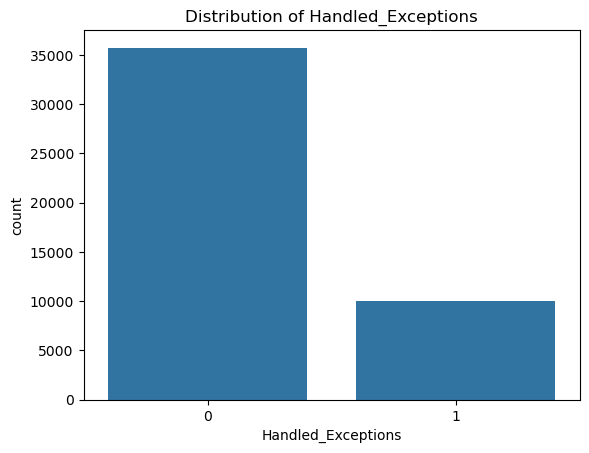

In [417]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [418]:
df.head(3)

Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions
10      a0b0ad9  ANGELA BAIORI     3266       2025-02-05  97.01           233         227       60.0       3.86                227                 4       0.0             3                          0                            0                           0                       0                    0                   0              233     178  ANGELA BAIORI              2   Wednesday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                   0
12      a0b0ad9  ANGELA BAIORI     3266       2025-02-02  97.03           268         254       59.0       4.36                254                 2       0.0            10                          0                            0                           0                       0                    0                   0              268     178  ANGELA BAIORI              6      Sunday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                   0
13      a0b0ad9  ANGELA BAIORI     3266       2024-12-29  92.92           214         199       42.0       4.88                199                 6       0.0             4                          0                            0                           0                       0                    0                   0              214     178  ANGELA BAIORI              6      Sunday        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03                   0

In [419]:
print(df['Exception Qty Req to Pick'].loc[df['Handled_Exceptions'] == 1].unique())
# Sanity check: show where Exception Qty Req to Pick is 0 but Handled_Exceptions is 1
df[(df['Exception Qty Req to Pick'] == 0) & (df['Handled_Exceptions'] == 1)]


[  2   8   1   3  10   7   4   6  23   5  13   9  18  12  15  11  14  16
  20  19  22  26  24  27 170  90  83  32  94  54  48  25 206  60 101 169
 104  31  68 132  45  73  37  47 116  40  30  42  69  21  38 120  17  93
 155  77  51 157  53  80  65  49  70  63  96  35  36  92 130 149  82 115
  57  75 129  67  62  41  28  50  55  33  56  44 108  39  99 142  58  86
 107  74  29  34  84  66  46  43  79 112  76  71 105  52  61  95 125  88
 133  81  98 113 158  89 127 128  59  97  72  87 119 136 164 139  78 103
 188 106 123 100 109 102 135  91 167 165 122 131 126  64 150 111 145 141
 114 143 148 168  85 124 121 140 117 110 265 147 146 163 144 134 161 175
 202 201 207 118 171 154 272 166 151 156 177 152 138 153 183 182 137 186
 172 187 176 271 160 193 179 229 197 249 159]


Empty DataFrame
Columns: [Associate ID, Associate Name, Store #, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Market, Associate, Day of Week #, Day of Week, Custom Week Start, Custom Week End, Week, Handled_Exceptions]
Index: []

In [420]:
start_time = time.time()
# Threshold ranges to test
threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
#print(threshold_pick_rate_values)
threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

# Variables to store the best thresholds and corresponding F1 score
best_thresholds = None
best_f1_score = -np.inf  # Initialize to a very low value
results = []  # Store results for each threshold combination

# Debugging: Check initial conditions
#print("Initial Threshold Values:")
#print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
#print(f"FTPR Thresholds: {threshold_ftpr_values}")

# Iterate through threshold combinations
for threshold_pick_rate in threshold_pick_rate_values:
    for threshold_ftpr in threshold_ftpr_values:
        # Create target variable based on thresholds
        '''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                    (df['FTPR'] > threshold_ftpr)).astype(int)
                                    '''
        y = df['Handled_Exceptions']
        X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

        # Debugging: Check class distribution
        #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
        #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
        
        # Skip if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            #print("Skipping: Only one class present in target variable")
            continue

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Skip if train/test split results in a single class
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            #print("Skipping: Only one class present in train/test sets")
            continue

        # Train a Random Forest model
        model = RandomForestClassifier(random_state=42, n_jobs=-1) ############### n_jobs
        model.fit(X_train, y_train)

        # Make predictions and calculate F1 score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        # Debugging: Print F1 score for the current thresholds
        #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

        # Update the best thresholds if current F1 is higher
        if f1 > best_f1_score:
            best_f1_score = f1
            best_thresholds = (threshold_pick_rate, threshold_ftpr)
            #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

        # Store the results for analysis
        results.append({
            'Pick Rate Threshold': threshold_pick_rate,
            'FTPR Threshold': threshold_ftpr,
            'F1 Score': f1
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best thresholds and their corresponding F1 score
if best_thresholds is None:
    print("No valid threshold combination was found. Adjust thresholds or data distribution.")
else:
    print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
    print(f"Best F1 Score: {best_f1_score}")

# Optional: Summarize all tested threshold combinations
if not results_df.empty:
    print("Summary of Top Threshold Combinations:")
    print(results_df.sort_values(by='F1 Score', ascending=False).head())
else:
    print("No valid results were generated.")
end_time = time.time()
print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=70.0
Best F1 Score: 0.25207057976233344
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
0              5.000000       70.000000  0.252071
1              5.000000       73.181818  0.252071
70           358.571429      101.818182  0.252071
69           358.571429       98.636364  0.252071
68           358.571429       95.454545  0.252071
time to run model for 96 combinations: 39.66117191314697


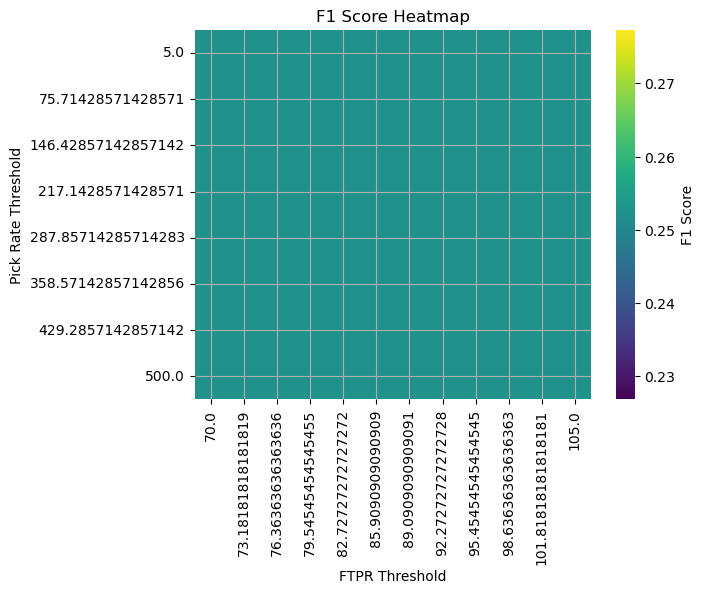

In [421]:
# Ensure results_df is not empty
if not results_df.empty:
    # Rename columns for compatibility with pivot (optional, just for consistency)
    results_df.rename(columns={
        'Pick Rate Threshold': 'pick_rate',
        'FTPR Threshold': 'ftpr',
        'F1 Score': 'f1'
    }, inplace=True)

    # Create pivot table
    pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

    # Generate heatmap
    sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
    plt.title("F1 Score Heatmap")
    plt.xlabel("FTPR Threshold")
    plt.ylabel("Pick Rate Threshold")
    plt.grid()
    plt.show()
else:
    print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [422]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count    45712.000000
mean        89.129515
std         47.708535
min          0.000000
25%         61.300000
50%         86.700000
75%        111.000000
max        947.400000
Name: Pick Rate, dtype: float64
count    45716.000000
mean        89.025803
std         10.283862
min          0.000000
25%         86.860000
50%         91.050000
75%         94.120000
max        157.140000
Name: FTPR, dtype: float64
Handled_Exceptions
0    35733
1     9983
Name: count, dtype: int64
FTPR: 0.19649471145506714
Pick Rate: 0.25077444387039766
Pick Hours: 0.2041182709481876
Qty Req to Pick: 0.17916396815478103
Picked As Req Qty: 0.16944860557156652


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>
<ul>pick_hours_modifier

<h1>Composite Score Modifiers</h1>

In [423]:
pickrate_modifier = 0.3
ftpr_modifier = 0.3
picked_as_req_modifier = 0.2
pick_hours_modifier = 0.1
picked_as_req_composite_threshold = 50

<h3>Weekly Averages (WTD)</h3>

In [424]:
import datetime as dt
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df["Week"].max() #defaults to most recent week

df['Pick Hours'] = df['Pick Hours'].astype(float)
# Filter the data for the specified week
#df_week = df[df['Week'] == week_of_interest]
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()
df_week = wtd_data.loc[wtd_data['Store #'] == selected_store, :]
df_week = df_week.drop_duplicates()
if df_week.empty:
    print("No data available for the current week.")
else:
    this_week_df = df_week
    avdf = this_week_df.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
    avdf['Week'] = week_of_interest
    avdf['Custom Week Start'] = df_week['Custom Week Start'].max()
    avdf['Custom Week End'] = df_week['Custom Week End'].max()
    #print(f'avdf columns: {avdf.columns}')
    #print(f'df columns: {df.columns}')
    # Specify the week for analysis
    #week_of_interest = '2025-01-18 to 2025-01-24' #manual range
    #week_of_interest = df["Week"].max() #defaults to most recent week

    # Filter the data for the specified week
    #avdf_week = avdf[avdf['Week'] == week_of_interest]
    print(f'avdf rows: {avdf.shape[0]}')
    print(f'{avdf.head(avdf.shape[0])}')

avdf rows: 33
                                        Store #        FTPR  FTP Expected  FTP Actual   Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Day of Week #  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                        
a0b0ad9      ANGELA BAIORI               3266.0   94.703333    233.666667  215.666667   73.366667    3.700000         217.666667          8.666667       0.0     13.666667                  

<h1>Weekly Averages (WTD) Selected Associate</h1>

In [425]:
selected_associate = 'madhusudan patel'
selected_associate = selected_associate.upper()
print(f'selected associate: {selected_associate}')
print(avdf.loc[avdf.index.get_level_values('Associate') == selected_associate, :])

selected associate: MADHUSUDAN PATEL
                               Store #       FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Day of Week #  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                             
mmp00af      MADHUSUDAN PATEL   3266.0  96.246667     44.333333        42.0  33.266667    1.413333               42.0               2.0       0.0           2.0                        0.0 

<h3>Weekly Averages (LW)</h3>

In [426]:
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
today = pd.to_datetime(today).date()

df_selected_store = df.loc[df['Store #'] == selected_store, :]
# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

df_lw = df[(df['Custom Week End'] == last_full_week_end) | (df['Custom Week Start'] == last_full_week_start)] #All stores in market 178
df_lw = df_selected_store[(df_selected_store['Custom Week End'] == last_full_week_end) | (df_selected_store['Custom Week Start'] == last_full_week_start)]

avdf = df_lw.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
avdf['Week'] = last_full_week_start.strftime('%Y-%m-%d') + " to " + last_full_week_end.strftime('%Y-%m-%d')
avdf['Custom Week Start'] = last_full_week_start
avdf['Custom Week End'] = last_full_week_end
print(f'avdf row count: {avdf.shape[0]}')
print(f'Week: {avdf["Week"].unique()}')
avdf.head(avdf.shape[0])


avdf row count: 26
Week: ['2025-08-23 to 2025-08-29']


Store #        FTPR  FTP Expected  FTP Actual   Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Day of Week #  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                        
a0b0ad9      ANGELA BAIORI               3266.0   93.420000    214.500000  198.500000   42.000000    4.985000         205.500000          2.000000       0.0     12.500000                   0.500000                     0.000000                         0.0                0.500000       214.500000   178.0       3.000000            0.500000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
a0c02mv      AURORA COMPRES              3266.0   84.830000     67.500000   63.500000   20.450000    2.295000          63.500000          2.000000       0.0      2.500000                   0.500000                     0.000000                         0.5                0.000000        67.500000   178.0       4.500000            0.500000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
cmo0039      CARMEN OLIVERA              3266.0   91.480000     40.000000   36.500000   12.950000    2.820000          36.500000          0.000000       0.0      2.500000                   0.500000                     0.500000                         0.0                0.000000        40.000000   178.0       5.000000            0.500000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
d0c0as3      DANIELLE CASIANO            3266.0   90.176667     35.666667   32.666667   42.066667    0.930000          32.666667          4.000000       0.0      1.666667                   1.666667                     0.000000                         0.0                1.666667        35.666667   178.0       3.333333            0.666667  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
d0h0u6h      DIPSHIKHA HAZRA             3266.0   95.582000    168.200000  160.800000   41.240000    4.018000         161.800000          2.000000       0.0      6.000000                   0.000000                     0.000000                         0.0                0.000000       168.200000   178.0       3.600000            0.000000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
e0e04sh      ERIK ENRIQUEZ               3266.0   89.758000    183.800000  167.200000   87.060000    2.420000         168.600000          5.200000       0.0     12.400000                   1.000000                     0.000000                         0.0                1.000000       183.800000   178.0       3.400000            0.400000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
e0m0abw      ESTHER MARTINEZ             3266.0   97.237500    292.250000  284.000000   71.075000    4.180000         285.000000          3.000000       0.0     15.250000                   0.500000                     0.000000                         0.0                0.500000       292.250000   178.0       2.000000            0.250000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
e0s0frj      ERICKA SUIN                 3266.0   93.857500    129.750000  120.500000   45.700000    2.717500         124.500000          4.250000       0.0      4.500000                   0.500000                     0.000000                         0.5                0.000000       129.750000   178.0       1.500000            0.250000  2025-08-23 to 2025-08-29        2025-08-23      2025-08-29
f0w03c8      FALLON WILCOX               3266.0   

<h1> Weekly Averages (LW) for Selected Associate</h1>

In [427]:
selected_associate = 'madhusudan patel'
selected_associate = selected_associate.upper()
print(f'selected associate: {selected_associate}')
print(avdf.loc[avdf.index.get_level_values('Associate') == selected_associate, :])

selected associate: MADHUSUDAN PATEL
Empty DataFrame
Columns: [Store #, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, Qty Req to Pick, Market, Day of Week #, Handled_Exceptions, Week, Custom Week Start, Custom Week End]
Index: []


In [428]:
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR'] +              # Weight for FTPR
    pick_hours_modifier * df['Pick Hours'].astype(float)  # Weight for Pick Hours
)

# Find the best day for each associate
#best_days = df.loc[df.groupby('Associate Name')['Composite Score'].idxmax()] #all stores in market 178
df_selected_store = df.loc[df['Store #'] == selected_store, :]
best_days = df_selected_store.loc[df_selected_store.groupby('Associate')['Composite Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])
if selected_store == 3266:
    top_associates = top_associates[top_associates['Associate'].apply(lambda x: x in associate_list_3266)]


# Display the top associates and their best day
print(top_associates[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > picked_as_req_composite_threshold]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

                      Associate Day of Pick Date  Picked As Req Qty  Pick Rate    FTPR  Composite Score
3530                HEENA PATEL       2025-08-01                590      122.8   97.23          184.495
6202          NATHANIEL VENTURA       2025-02-21                  1      514.0  100.00          184.400
810                TIERRA BROWN       2025-02-02                469      105.0   99.79          155.689
5867  NOELIA VENTURA DE SANTANA       2025-03-02                460       81.0   92.47          144.625
3111              ANGELA BAIORI       2025-08-08                408      100.3   99.27          141.878
6066                JESICA PUGO       2025-02-08                407       88.0   92.43          136.005
3430            JULIA SIGUENCIA       2025-08-16                376      100.0   99.73          135.496
3262            ESTHER MARTINEZ       2025-08-26                403       71.9   99.02          132.443
6107              MARIA SANCHEZ       2025-02-28                

In [429]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [430]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
df_picked_as_req_qty_filter = df_selected_store[df_selected_store['Picked As Req Qty'] > picked_as_req_composite_threshold].copy()
cols_to_convert = ['Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours']
df_picked_as_req_qty_filter[cols_to_convert] = df_picked_as_req_qty_filter[cols_to_convert].apply(pd.to_numeric, errors='coerce').copy()
weekly_performance = df_picked_as_req_qty_filter.groupby(['Custom Week Start', 'Associate'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum',        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR'] +
    pick_hours_modifier * weekly_performance['Pick Hours']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
#print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']])
print(f'\nTop Associate Per Week (Composite Score)')
top_associates_per_week[['Custom Week Start', 'Associate', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours', 'Composite Score']]



Top Associate Per Week (Composite Score)


Custom Week Start        Associate  Picked As Req Qty  Pick Rate       FTPR  Pick Hours  Composite Score
2          2024-12-14  JULIA SIGUENCIA                336  68.000000  92.020000        4.99        115.70500
19         2024-12-21      JESICA PUGO                771  62.200000  92.556000       14.34        202.06080
45         2024-12-28      JESICA PUGO                921  85.000000  93.254000       13.54        239.03020
69         2025-01-04    MARIA SANCHEZ                896  62.500000  95.310000       14.58        228.00100
91         2025-01-11    MARIA SANCHEZ                883  50.400000  93.936000       17.82        221.68280
110        2025-01-18    MARIA SANCHEZ               1048  72.000000  96.088000       16.13        261.63940
128        2025-01-25    MARIA SANCHEZ                916  65.250000  97.060000       14.19        233.31200
144        2025-02-01      JESICA PUGO               1216  81.000000  95.465000       15.44        297.68350
163        2025-02-08      JESICA PUGO                936  79.000000  93.292500       11.85        240.07275
188        2025-02-15    MARIA SANCHEZ                990  66.600000  95.292000       16.23        248.19060
203        2025-02-22  ESTHER MARTINEZ                837  78.500000  96.660000       11.45        221.09300
232        2025-03-01    MARIA SANCHEZ               1121  70.233333  93.631667       17.76        275.13550
256        2025-03-08    MARIA SANCHEZ                966  67.975000  94.830000       14.31        243.47250
272        2025-03-15      HEENA PATEL               2053  82.187500  96.015000       24.75        466.53575
294        2025-03-22    MARIA SANCHEZ               2218  59.760000  93.246000       36.86        493.18780
314        2025-03-29  JULIA SIGUENCIA               2022  68.640000  95.220000       30.76        456.63400
328        2025-04-05       CIANA RIPA               2110  92.025000  93.927500       23.20        480.10575
357        2025-04-12      JESICA PUGO               1429  75.650000  92.301667       19.16        338.10150
379        2025-04-19      HEENA PATEL               1129  72.280000  93.022000       17.87        277.17760
406        2025-04-26    MARIA SANCHEZ               1297  63.533333  95.645000       23.05        309.45850
422        2025-05-03      HEENA PATEL               1154  73.800000  92.790000       16.67        282.44400
441        2025-05-10      HEENA PATEL               1282  72.020000  92.220000       18.10        307.48200
462        2025-05-17      HEENA PATEL               1113  68.060000  91.318000       18.06        272.21940
483        2025-05-24      HEENA PATEL                892  55.375000  91.942500       16.27        224.22225
502        2025-05-31  ESTHER MARTINEZ                749  46.900000  94.845000       16.29        193.95250
524        2025-06-07      HEENA PATEL                832  62.075000  93.972500       13.76        214.59025
543        2025-06-14      HEENA PATEL                726  64.800000  93.575000       11.82        193.89450
564        2025-06-21      HEENA PATEL                822  58.940000  95.090000       15.76        212.18500
585        2025-06-28      HEENA PATEL                824  55.600000  93.472500       15.22        211.04375
604        2025-07-05      HEENA PATEL                935  67.125000  94.285000       14.31        236.85400
626        2025-07-12      HEENA PATEL               1059  76.300000  94.100000       16.29        264.54900
650        2025-07-19  JULIA SIGUENCIA                892  51.475000  92.770000       18.38        223.51150
670        2025-07-26      HEENA PATEL               1433  78.825000  94.610000       18.16        340.44650
681        2025-08-02    ANGELA BAIORI               1037  56.075000  94.777500       19.57        254.61275
709        2025-08-09      JESICA PUGO               1723  71.960000  96.552000       24.12        397.56560
720        2025-08-16    ANGELA BAIORI               1179  43.620000  95.198000 

<h2>WTD Composite Score Rankings</h2>

In [431]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier) + (df['Pick Hours'].astype(float) * pick_hours_modifier)

# Filter rows where Picked As Req Qty is less than num
df_selected_store = df.loc[df['Store #'] == selected_store, :]  # Updated to use selected_store
num = 1
df_filtered = df[df['Picked As Req Qty'] >= picked_as_req_composite_threshold] #all stores in market 178
df_filtered = df_selected_store[df_selected_store['Picked As Req Qty'] >= picked_as_req_composite_threshold]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
#week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
#df_week = df_filtered[df_filtered['Week'] == week_of_interest]
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()
if wtd_data.empty:
    print("No data available for the current week.")
else:
    # Get the best day per associate within the week based on Composite Score
    best_day_of_week = wtd_data.loc[wtd_data.groupby('Associate')['Composite Score'].idxmax()]
    best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
    if selected_store == 3266:
        best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

    # Rank the associates based on Composite Score within the week
    best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

    # Sort by rank (ascending gives top performer first)
    best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

    # Display the results
    print('WTD Composite Scores')
    print(f'Week: {week_of_interest}')
    #print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']])
    best_day_of_week_printdf = best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]
    print(f'{best_day_of_week_printdf.head(30)}')

WTD Composite Scores
Week: 2025-01-18 to 2025-01-24
                      Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Pick Hours  Composite Score  Rank
3074            JULIA SIGUENCIA       2025-09-02       72.2  94.60                354        5.08          121.348   1.0
3049              ANGELA BAIORI       2025-09-03       70.5  89.92                354        5.25          119.451   2.0
3055              ERIK ENRIQUEZ       2025-09-03       99.1  97.13                204        2.09           99.878   3.0
3057                HEENA PATEL       2025-09-03       57.9  97.32                263        4.58           99.624   4.0
3056            ESTHER MARTINEZ       2025-09-03       54.8  96.19                268        5.02           99.399   5.0
3198                JESICA PUGO       2025-08-30       55.6  96.40                243        4.46           94.646   6.0
3094               SIDDH PANDYA       2025-09-01       54.5  96.62                229        4.33    

<h2>Composite Score Rankings LW</h2>

In [432]:
# Calculate Composite Score
df['Composite Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier) +
    (df['Pick Hours'] * pick_hours_modifier)
)

df_selected_store = df.loc[df['Store #'] == selected_store, :].copy()
# Set today’s date
today = datetime.now()
today = today.strftime("%Y-%m-%d")

'''# Find the last full week's end date (before today)
last_full_week_end = df_selected_store['Custom Week End'][df_selected_store['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df_selected_store['Custom Week Start'][df_selected_store['Custom Week End'] == last_full_week_end].max()
'''
# Set today's date and get the current week start (assuming weeks start on Monday)
'''current_week_start = today - timedelta(days=today.weekday())

# Get unique week ranges (start and end), and sort by end date
weeks = df_selected_store[['Custom Week Start', 'Custom Week End']].drop_duplicates()
weeks = weeks.sort_values(by='Custom Week End')

# Filter to only weeks that ended before the current week
full_weeks = weeks[weeks['Custom Week End'] < current_week_start]

# Get the last full week
if not full_weeks.empty:
    last_full_week_end = full_weeks['Custom Week End'].max()
    last_full_week_start = full_weeks.loc[full_weeks['Custom Week End'] == last_full_week_end, 'Custom Week Start'].iloc[0]
else:
    raise ValueError("No full weeks found before current week.")

# Filter data for the last full week
df_week = df_selected_store[(df_selected_store['Custom Week Start'] == last_full_week_start) & (df_selected_store['Custom Week End'] == last_full_week_end)]
'''

df_selected_store['Custom Week Start'] = pd.to_datetime(df_selected_store['Custom Week Start'])
df_selected_store['Custom Week End'] = pd.to_datetime(df_selected_store['Custom Week End'])

# Filter out incomplete weeks: only use weeks where the end is before this week
valid_weeks = (
    df_selected_store[df_selected_store['Custom Week End'] < today]
    .groupby(['Custom Week Start', 'Custom Week End'])
    .filter(lambda x: not x.empty)  # can add additional logic here if needed (e.g., row count threshold)
)

# Get the last full week's start and end dates
if not valid_weeks.empty:
    last_week_range = (
        valid_weeks[['Custom Week Start', 'Custom Week End']]
        .drop_duplicates()
        .sort_values(by='Custom Week End')
        .iloc[-1]
    )
    last_full_week_start = last_week_range['Custom Week Start']
    last_full_week_end = last_week_range['Custom Week End']
else:
    raise ValueError("No valid full weeks found before this week.")

# Filter for that last full week of data
df_week = df_selected_store[
    (df_selected_store['Custom Week Start'] == last_full_week_start) &
    (df_selected_store['Custom Week End'] == last_full_week_end)
].copy()

#last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
#df_week = df_selected_store[df_selected_store['Custom Week End'] == last_full_week_end]


# Get the best day per associate within the last full week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmax()].copy()

# Filter out associates with fewer than the composite threshold
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
if selected_store == 3266:
    best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(30)

LW Composite Scores
Week: 2025-08-23 - 2025-08-29


Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Composite Score  Rank
3262            ESTHER MARTINEZ       2025-08-26       71.9  99.02                403          132.443   1.0
3238                JESICA PUGO       2025-08-28       74.9  93.06                407          132.342   2.0
3264                HEENA PATEL       2025-08-26       76.7  93.58                306          112.698   3.0
3301              ERIK ENRIQUEZ       2025-08-23       92.7  91.95                274          110.508   4.0
3255              NICOLE WEAVER       2025-08-27       61.0  89.52                317          109.110   5.0
3307            JULIA SIGUENCIA       2025-08-23       57.4  91.40                301          105.390   6.0
3230  NOELIA VENTURA DE SANTANA       2025-08-29       64.9  91.78                273          102.035   7.0
3228              MARIA SANCHEZ       2025-08-29       48.3  96.53                251           94.176   8.0
3257               SIDDH PANDYA       2025-08-27       89.7  97.08                168           89.822   9.0
3289            DIPSHIKHA HAZRA       2025-08-24       55.1  95.61                218           89.212  10.0
3271               TIERRA BROWN       2025-08-26       63.4  98.53                201           89.096  11.0
3221              ANGELA BAIORI       2025-08-29       40.0  89.19                241           87.564  12.0
3236                ERICKA SUIN       2025-08-28       52.4  91.71                178           79.176  13.0
3280           KENNY BUSTAMANTE       2025-08-25       43.6  96.23                155           73.314  14.0
3303              FALLON WILCOX       2025-08-23       45.1  89.51                150           70.727  15.0
3229          NATHANIEL VENTURA       2025-08-29       74.8  93.75                100           70.699  16.0
3286             AURORA COMPRES       2025-08-24       31.7  94.66                124           63.102  17.0
3259           VICTORIA MORALES       2025-08-27       70.0  89.61                 69           61.782  18.0
3282         SHAMIMA HAQUE MITU       2025-08-25       43.9  89.71                 61           52.424  19.0

<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [433]:
# Get the best day per associate within the last full week based on Composite Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmin()].copy()
if selected_store == 3266:
    worst_day_of_week = worst_day_of_week[worst_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

# Rank associates by Composite Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite Score'].rank(ascending=True, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=True)

# Display results
print('Lowest Performing Associates by Day LW (Composite Score)')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']].head(15)

Lowest Performing Associates by Day LW (Composite Score)
Week: 2025-08-23 - 2025-08-29


Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Pick Hours  Composite Score  Rank
3296              PARAMJIT KAUR       2025-08-24        0.0   0.00                  0        0.00            0.000   1.0
3234             AURORA COMPRES       2025-08-28        9.2  75.00                  3        0.65           25.925   2.0
3231               SCOTT SUAREZ       2025-08-29       10.5  80.00                  4        0.38           27.988   3.0
3232         SHAMIMA HAQUE MITU       2025-08-29       29.8  83.33                 15        0.54           36.993   4.0
3287             CARMEN OLIVERA       2025-08-24       12.7  88.37                 38        2.98           38.219   5.0
3293           KENNY BUSTAMANTE       2025-08-24       29.6  91.30                 21        0.74           40.544   6.0
3281                PARUL PATEL       2025-08-25       24.9  91.67                 33        1.32           41.703   7.0
3290              ERIK ENRIQUEZ       2025-08-24       31.6  79.73                 65        2.06           46.605   8.0
3246           VICTORIA MORALES       2025-08-28       35.5  91.67                 55        1.55           49.306   9.0
3248                ERICKA SUIN       2025-08-27       35.0  96.67                 58        1.71           51.272  10.0
3269              NICOLE WEAVER       2025-08-26       47.0  97.73                 43        0.94           52.113  11.0
3306                JESICA PUGO       2025-08-23       45.8  85.71                 84        1.85           56.438  12.0
3295  NOELIA VENTURA DE SANTANA       2025-08-24       38.5  94.44                 85        2.21           57.103  13.0
3245               TIERRA BROWN       2025-08-28       37.1  85.25                113        3.10           59.615  14.0
3268          NATHANIEL VENTURA       2025-08-26       62.1  89.06                 71        1.19           59.667  15.0

In [434]:
print(df['Exception Qty Req to Pick'].loc[df['Handled_Exceptions'] == 1].unique())
# Sanity check: show where Exception Qty Req to Pick is 0 but Handled_Exceptions is 1
df[(df['Exception Qty Req to Pick'] == 0) & (df['Handled_Exceptions'] == 1)]

df.loc[(df['Associate'] == 'MAGDALENA GRIJALVA') & (df['Week'] == '2025-04-12 to 2025-04-18')]

[  2   8   1   3  10   7   4   6  23   5  13   9  18  12  15  11  14  16
  20  19  22  26  24  27 170  90  83  32  94  54  48  25 206  60 101 169
 104  31  68 132  45  73  37  47 116  40  30  42  69  21  38 120  17  93
 155  77  51 157  53  80  65  49  70  63  96  35  36  92 130 149  82 115
  57  75 129  67  62  41  28  50  55  33  56  44 108  39  99 142  58  86
 107  74  29  34  84  66  46  43  79 112  76  71 105  52  61  95 125  88
 133  81  98 113 158  89 127 128  59  97  72  87 119 136 164 139  78 103
 188 106 123 100 109 102 135  91 167 165 122 131 126  64 150 111 145 141
 114 143 148 168  85 124 121 140 117 110 265 147 146 163 144 134 161 175
 202 201 207 118 171 154 272 166 151 156 177 152 138 153 183 182 137 186
 172 187 176 271 160 193 179 229 197 249 159]


Associate ID      Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market           Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score
5174      m0g065v  MAGDALENA GRIJALVA     3266       2025-04-18   94.44           198         187       62.8        3.15                187                11       0.0             0                          0                            0                           0                       0                    0                   0              198     178  MAGDALENA GRIJALVA              4      Friday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18                   0           84.887
5189      m0g065v  MAGDALENA GRIJALVA     3266       2025-04-17   89.76           205         184       47.7        3.98                184                 6       0.0            11                          0                            0                           0                       0                    0                   0              205     178  MAGDALENA GRIJALVA              3    Thursday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18                   0           78.436
5203      m0g065v  MAGDALENA GRIJALVA     3266       2025-04-16   92.89           197         183       59.4        3.13                183                 3       0.0            18                          0                            0                           0                       0                    0                   0              197     178  MAGDALENA GRIJALVA              2   Wednesday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18                   0           82.600
5217      m0g065v  MAGDALENA GRIJALVA     3266       2025-04-15  100.00            17          17       53.8        0.32                 17                 0       0.0             1                          1                            0                           0                       1                    0                   0               17     178  MAGDALENA GRIJALVA              1     Tuesday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18                   1           49.572

<h2>Lowest FTPR Associates for LW</h2>

In [435]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.0]
lowest_ftpr = lowest_ftpr.drop_duplicates()
if selected_store == 3266:
    lowest_ftpr = lowest_ftpr[lowest_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['FTPR'].rank(ascending=True, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('Lowest FTPR LW <= 90.0%')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
lowest_ftpr[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]


Lowest FTPR LW <= 90.0%
Week: 2025-08-23 - 2025-08-29


Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Pick Hours  Composite Score  Rank
3296       PARAMJIT KAUR       2025-08-24        0.0   0.00                  0        0.00            0.000   1.0
3234      AURORA COMPRES       2025-08-28        9.2  75.00                  3        0.65           25.925   2.0
3290       ERIK ENRIQUEZ       2025-08-24       31.6  79.73                 65        2.06           46.605   3.0
3231        SCOTT SUAREZ       2025-08-29       10.5  80.00                  4        0.38           27.988   4.0
3232  SHAMIMA HAQUE MITU       2025-08-29       29.8  83.33                 15        0.54           36.993   5.0
3245        TIERRA BROWN       2025-08-28       37.1  85.25                113        3.10           59.615   6.0
3251         HEENA PATEL       2025-08-27       58.1  85.67                295        5.14          102.645   7.0
3306         JESICA PUGO       2025-08-23       45.8  85.71                 84        1.85           56.438   8.0
3308       MARIA SANCHEZ       2025-08-23       46.5  88.02                183        4.00           77.356   9.0
3287      CARMEN OLIVERA       2025-08-24       12.7  88.37                 38        2.98           38.219  10.0
3268   NATHANIEL VENTURA       2025-08-26       62.1  89.06                 71        1.19           59.667  11.0
3312    VICTORIA MORALES       2025-08-23       68.8  89.09                 49        0.71           57.238  12.0
3221       ANGELA BAIORI       2025-08-29       40.0  89.19                241        6.07           87.564  13.0
3303       FALLON WILCOX       2025-08-23       45.1  89.51                150        3.44           70.727  14.0
3255       NICOLE WEAVER       2025-08-27       61.0  89.52                317        5.54          109.110  15.0
3227     JULIA SIGUENCIA       2025-08-29       40.7  89.67                170        4.32           73.543  16.0
3261         ERICKA SUIN       2025-08-26       49.8  89.70                152        3.21           72.571  17.0

<h1>All FTPR <= 90.0% LW</h1>

In [436]:
# Filter rows where FTPR is <= 90
total_below_90 = df_week.loc[df_week['FTPR'] <= 90.0, :].copy()

# Add a 'Rank' column based on FTPR, lower FTPR gets higher rank
if selected_store == 3266:
    total_below_90 = total_below_90[total_below_90['Associate'].apply(lambda x: x in associate_list_3266)]
total_below_90['Rank'] = total_below_90['FTPR'].rank(ascending=True, method='min')
total_below_90 = total_below_90.sort_values(by='Rank', ascending=True)
total_below_90 = total_below_90.drop_duplicates()
print(f'All FTPR <= 90.0 % for LW')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
total_below_90[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Hours', 'Composite Score', 'Rank']]


All FTPR <= 90.0 % for LW
Week: 2025-08-23 - 2025-08-29


Associate Day of Pick Date  Pick Rate   FTPR  FTP Expected  FTP Actual  Pick Hours  Composite Score  Rank
3296       PARAMJIT KAUR       2025-08-24        0.0   0.00             1           0        0.00            0.000   1.0
3234      AURORA COMPRES       2025-08-28        9.2  75.00             4           3        0.65           25.925   2.0
3290       ERIK ENRIQUEZ       2025-08-24       31.6  79.73            74          59        2.06           46.605   3.0
3231        SCOTT SUAREZ       2025-08-29       10.5  80.00             5           4        0.38           27.988   4.0
3232  SHAMIMA HAQUE MITU       2025-08-29       29.8  83.33            18          15        0.54           36.993   5.0
3245        TIERRA BROWN       2025-08-28       37.1  85.25           122         104        3.10           59.615   6.0
3251         HEENA PATEL       2025-08-27       58.1  85.67           335         287        5.14          102.645   7.0
3306         JESICA PUGO       2025-08-23       45.8  85.71            98          84        1.85           56.438   8.0
3284        TIERRA BROWN       2025-08-25       70.0  86.59            82          71        1.16           62.693   9.0
3308       MARIA SANCHEZ       2025-08-23       46.5  88.02           192         169        4.00           77.356  10.0
3287      CARMEN OLIVERA       2025-08-24       12.7  88.37            43          38        2.98           38.219  11.0
3268   NATHANIEL VENTURA       2025-08-26       62.1  89.06            64          57        1.19           59.667  12.0
3312    VICTORIA MORALES       2025-08-23       68.8  89.09            55          49        0.71           57.238  13.0
3221       ANGELA BAIORI       2025-08-29       40.0  89.19           259         231        6.07           87.564  14.0
3303       FALLON WILCOX       2025-08-23       45.1  89.51           162         145        3.44           70.727  15.0
3255       NICOLE WEAVER       2025-08-27       61.0  89.52           353         316        5.54          109.110  16.0
3259    VICTORIA MORALES       2025-08-27       70.0  89.61            77          69        0.99           61.782  17.0
3227     JULIA SIGUENCIA       2025-08-29       40.7  89.67           184         165        4.32           73.543  18.0
3261         ERICKA SUIN       2025-08-26       49.8  89.70           165         148        3.21           72.571  19.0
3282  SHAMIMA HAQUE MITU       2025-08-25       43.9  89.71            68          61        1.41           52.424  20.0
3272    VICTORIA MORALES       2025-08-26       30.3  89.87            79          71        2.35           50.486  21.0

<h1>All FTPR <= 90.0% WTD</h1>

In [437]:
week_of_interest = df["Week"].max() #defaults to most recent week
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

df_wtd = wtd_data.copy()

if df_wtd.empty:
    print("No data available for the current week-to-date (WTD).")
else:
    #print("Columns before any filtering:", df_wtd.columns.tolist())

    df_wtd = df_wtd.loc[df_wtd['Store #'] == selected_store, :]

    if df_wtd.empty:
        print(f"No data available for store {selected_store}.")
    else:
        df_wtd = df_wtd[df_wtd['FTPR'] <= 90.0]

        if df_wtd.empty:
            print("No rows with FTPR <= 90.0.")
        else:
            df_wtd = df_wtd.drop_duplicates()

            if selected_store == 3266:
                df_wtd = df_wtd[df_wtd['Associate'].isin(associate_list_3266)]

            if df_wtd.empty:
                print("No associates left after filtering.")
            else:
                df_wtd['Rank'] = df_wtd['FTPR'].rank(ascending=True, method='min')
                df_wtd = df_wtd.sort_values(by='Rank', ascending=True)

                print(f'All FTPR <= 90.0 % for WTD')
                print(f'Week: {week_of_interest}')
                print(df_wtd[['Associate ID', 'Associate', 'Day of Pick Date', 
                              'Pick Rate', 'FTPR', 'Picked As Req Qty', 
                              'Composite Score', 'Rank']])



All FTPR <= 90.0 % for WTD
Week: 2025-08-30 to 2025-09-05
     Associate ID          Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Composite Score  Rank
3065      t0b0hm5       TIERRA BROWN       2025-09-03       46.2  67.87                174           69.439   1.0
3058      jrsigue    JULIA SIGUENCIA       2025-09-03       56.4  70.00                 28           43.587   2.0
3188      s0m160e    SHAGELLY MELGAR       2025-08-31       31.8  79.51                 97           53.114   3.0
3179      e0e04sh      ERIK ENRIQUEZ       2025-08-31       48.9  80.85                 76           54.289   4.0
3068      d0r0khi       DANIEL RUSSO       2025-09-02       48.4  81.82                 63           51.811   5.0
3066      v0m07r6   VICTORIA MORALES       2025-09-03       21.5  83.05                 50           41.598   6.0
3054      d0h0u6h    DIPSHIKHA HAZRA       2025-09-03       50.3  84.94                141           69.054   7.0
3061      m0i01db      MARIA I

<h1>Lowest FTPR for most recent day (day < today)

In [438]:
# Ensure 'today' is a datetime.date
today = datetime.now().date()

# Filter based on proper comparison
date_chosen = df_selected_store[df_selected_store['Day of Pick Date'] < today]['Day of Pick Date'].max()

df_low_ftpr = df_selected_store.loc[
    (df_selected_store['Store #'] == selected_store) &
    (df_selected_store['Day of Pick Date'] == date_chosen) &
    (df_selected_store['FTPR'] <= 90.0)
].copy()
df_yesterday = df_selected_store.loc[
    (df_selected_store['Store #'] == selected_store) &
    (df_selected_store['Day of Pick Date'] == date_chosen)
].copy()
df_yesterday = df_yesterday.drop_duplicates()
total_associate_count = df_yesterday.loc[:, 'Associate'].nunique()
total_associate_count_below_90 = df_low_ftpr.loc[df_low_ftpr['Store #'] == selected_store, 'Associate'].nunique()
print(f'Total Associates with FTPR <= 90.0%: {total_associate_count_below_90} out of {total_associate_count}')
'''
if selected_store == 3266:
    df_low_ftpr = df_low_ftpr[df_low_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
'''
df_low_ftpr = df_low_ftpr[df_low_ftpr['FTP Expected'] > 0]
df_low_ftpr['Rank'] = df_low_ftpr['FTPR'].rank(ascending=True, method='min')
df_low_ftpr = df_low_ftpr.sort_values(by='Rank', ascending=True)

print(f'Lowest FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Expected', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Total Associates with FTPR <= 90.0%: 8 out of 17
Lowest FTPR for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  FTP Expected  FTP Actual   FTPR  Pick Rate  Pick Hours  Rank
3065     3266      t0b0hm5      TIERRA BROWN           249         169  67.87       46.2        4.18   1.0
3058     3266      jrsigue   JULIA SIGUENCIA            40          28  70.00       56.4        0.67   2.0
3066     3266      v0m07r6  VICTORIA MORALES            59          49  83.05       21.5        2.33   3.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA           166         141  84.94       50.3        2.82   4.0
3061     3266      m0i01db     MARIA IXCOPAL            15          13  86.67       45.3        0.29   5.0
3063     3266      p0k010w     PARAMJIT KAUR             9           8  88.89       18.1        0.44   6.0
3052     3266      d0c0as3  DANIELLE CASIANO           106          95  89.62       72.3        1.45   7.0
3049     3266      a0b0ad9     ANGELA BAIORI           387         348  89.92       70.5        5.25   8.0

<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate <= 70)</h1>

In [439]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] <= 70.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate <= 70.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'Pick Rate', 'Pick Hours', 'FTP Actual', 'FTPR', 'Rank']]

Pick Rate <= 70.0 for: Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  Pick Rate  Pick Hours  FTP Actual    FTPR  Rank
3059     3266      mmp00af  MADHUSUDAN PATEL       17.0        1.53          24  100.00   1.0
3063     3266      p0k010w     PARAMJIT KAUR       18.1        0.44           8   88.89   2.0
3066     3266      v0m07r6  VICTORIA MORALES       21.5        2.33          49   83.05   3.0
3062     3266      mgs004k     MARIA SANCHEZ       37.6        1.43          51   91.07   4.0
3051     3266      d0r0khi      DANIEL RUSSO       39.3        2.14          81   93.10   5.0
3061     3266      m0i01db     MARIA IXCOPAL       45.3        0.29          13   86.67   6.0
3065     3266      t0b0hm5      TIERRA BROWN       46.2        4.18         169   67.87   7.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA       50.3        2.82         141   84.94   8.0
3056     3266      e0m0abw   ESTHER MARTINEZ       54.8        5.02         227   96.19   9.0
3058     3266      jrsigue   JULIA SIGUENCIA       56.4        0.67          28   70.00  10.0
3057     3266      h0p01q8       HEENA PATEL       57.9        4.58         254   97.32  11.0

<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate < 100)</h1>

In [440]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] < 100.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate < 100.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Pick Rate < 100.0 for: Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  FTP Actual    FTPR  Pick Rate  Pick Hours  Rank
3059     3266      mmp00af  MADHUSUDAN PATEL          24  100.00       17.0        1.53   1.0
3063     3266      p0k010w     PARAMJIT KAUR           8   88.89       18.1        0.44   2.0
3066     3266      v0m07r6  VICTORIA MORALES          49   83.05       21.5        2.33   3.0
3062     3266      mgs004k     MARIA SANCHEZ          51   91.07       37.6        1.43   4.0
3051     3266      d0r0khi      DANIEL RUSSO          81   93.10       39.3        2.14   5.0
3061     3266      m0i01db     MARIA IXCOPAL          13   86.67       45.3        0.29   6.0
3065     3266      t0b0hm5      TIERRA BROWN         169   67.87       46.2        4.18   7.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA         141   84.94       50.3        2.82   8.0
3056     3266      e0m0abw   ESTHER MARTINEZ         227   96.19       54.8        5.02   9.0
3058     3266      jrsigue   JULIA SIGUENCIA          28   70.00       56.4        0.67  10.0
3057     3266      h0p01q8       HEENA PATEL         254   97.32       57.9        4.58  11.0
3049     3266      a0b0ad9     ANGELA BAIORI         348   89.92       70.5        5.25  12.0
3055     3266      e0e04sh     ERIK ENRIQUEZ         203   97.13       99.1        2.09  13.0

<h1>Detect Potential Skipping</h1>
<p>Based on the difference between FTP Actual / FTP Expected and Picked as Req Qty / FTP Expected</p>
<ul>FTPR is determined based off FTP Actual / FTP Expected</ul>
<ul>Older data sets that predate FTP Actaul/Expected Columns will not reflect properly (roughly starting March 2025)</ul>
<ul>May include instances where an items has multiple locations and is nilled on first appearance</ul>

In [441]:
df['Potential Skipped Items'] = (
    (df['FTP Actual'] / df['FTP Expected']).round(6) < (df['Picked As Req Qty'] / df['FTP Expected']).round(6)
).astype(int)
#date_chosen = datetime.strptime("2025-07-24", "%Y-%m-%d").date()

In [442]:
print(f'Total Associates Picking for {date_chosen}: {df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), "Associate"].nunique()}')
print(f'Total Potential Associates Skipped Items for {date_chosen}: {df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), "Potential Skipped Items"].sum()}')
df.loc[(df['Potential Skipped Items'] == 1) & (df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :]

Total Associates Picking for 2025-09-03: 17
Total Potential Associates Skipped Items for 2025-09-03: 9


Associate ID      Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market           Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items
3049      a0b0ad9       ANGELA BAIORI     3266       2025-09-03  89.92           387         348       70.5        5.25                354                16       0.0            22                         10                            0                           0                      10                    0                   0              387     178       ANGELA BAIORI              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1          119.451                        1
3055      e0e04sh       ERIK ENRIQUEZ     3266       2025-09-03  97.13           209         203       99.1        2.09                204                 3       0.0            15                          4                            0                           0                       4                    0                   0              209     178       ERIK ENRIQUEZ              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1           99.878                        1
3056      e0m0abw     ESTHER MARTINEZ     3266       2025-09-03  96.19           236         227       54.8        5.02                268                 7       0.0            15                          5                            1                           0                       4                    0                   0              236     178     ESTHER MARTINEZ              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1           99.399                        1
3057      h0p01q8         HEENA PATEL     3266       2025-09-03  97.32           261         254       57.9        4.58                263                 2       0.0             7                          0                            0                           0                       0                    0                   0              261     178         HEENA PATEL              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           99.624                        1
3060      m0g065v  MAGDALENA GRIJALVA     3266       2025-09-03  96.67            30          29       36.0        0.89                 31                 1       0.0             5                          0                            0                           0                       0                    0                   0               30     178  MAGDALENA GRIJALVA              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           46.090                        1
3062      mgs004k       MARIA SANCHEZ     3266       2025-09-03  91.07            56          51       37.6        1.43                 52                 2       0.0             4                          0                            0                           0                       0                    0                   0               56     178       MARIA SANCHEZ              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           49.144                        1
3064      rsw000v     RASHEED WALLACE     3266       2025-09-03  91.35           185         169       54.0        3.33                170                10       0.0            19                          1                            0                           0                       1                    0                   0        

<h1>All Pick Rates >= 100 Most Recent Day (day < today)</h1>

In [443]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_pickrate_100 = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] >= 100.0) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if df_pickrate_100.empty:
    print(f'No associates with Pick Rate >= 100.0 and FTP Actual >= {picked_as_req_composite_threshold} for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
else:
    #if selected_store == 3266:
        #df_pickrate_100 = df_pickrate_100[df_pickrate_100['Associate'].apply(lambda x: x in associate_list_3266)]
    df_pickrate_100['Rank'] = df_pickrate_100['Pick Rate'].rank(ascending=True, method='min')
    df_pickrate_100 = df_pickrate_100.sort_values(by='Rank', ascending=True)
    print(f'Pick Rate >= 100.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
    print(f'Week: {week_of_interest}')
    print(df_pickrate_100[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']])

No associates with Pick Rate >= 100.0 and FTP Actual >= 50 for Wednesday, 2025-09-03


<h1>All Pick Rates >= 70 Most Recent Day (day < today)</h1>

In [444]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_pickrate_100 = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] >= 70.0) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if df_pickrate_100.empty:
    print(f'No associates with Pick Rate >= 70.0 and FTP Actual >= {picked_as_req_composite_threshold} for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
else:
    #if selected_store == 3266:
        ##df_pickrate_100 = df_pickrate_100[df_pickrate_100['Associate'].apply(lambda x: x in associate_list_3266)]
    df_pickrate_100['Rank'] = df_pickrate_100['Pick Rate'].rank(ascending=False, method='min')
    df_pickrate_100 = df_pickrate_100.sort_values(by='Rank', ascending=True)
    print(f'Pick Rate >= 70.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
    print(f'Week: {week_of_interest}')
    print(df_pickrate_100[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']])

Pick Rate >= 70.0 for: Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05
      Store # Associate ID         Associate  FTP Actual   FTPR  Pick Rate  Pick Hours  Rank
3055     3266      e0e04sh     ERIK ENRIQUEZ         203  97.13       99.1        2.09   1.0
3052     3266      d0c0as3  DANIELLE CASIANO          95  89.62       72.3        1.45   2.0
3049     3266      a0b0ad9     ANGELA BAIORI         348  89.92       70.5        5.25   3.0


<h1>Rank FTPR for most recent day (day  < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [445]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_ftpr = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
#if selected_store == 3266:
    #df_top_ftpr = df_top_ftpr[df_top_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_ftpr['Rank'] = df_top_ftpr['FTPR'].rank(ascending=False, method='min')
df_top_ftpr = df_top_ftpr.sort_values(by='Rank', ascending=True)
print(f'Top FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top FTPR for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  FTP Actual   FTPR  Pick Rate  Pick Hours  Rank
3057     3266      h0p01q8       HEENA PATEL         254  97.32       57.9        4.58   1.0
3055     3266      e0e04sh     ERIK ENRIQUEZ         203  97.13       99.1        2.09   2.0
3056     3266      e0m0abw   ESTHER MARTINEZ         227  96.19       54.8        5.02   3.0
3051     3266      d0r0khi      DANIEL RUSSO          81  93.10       39.3        2.14   4.0
3064     3266      rsw000v   RASHEED WALLACE         169  91.35       54.0        3.33   5.0
3062     3266      mgs004k     MARIA SANCHEZ          51  91.07       37.6        1.43   6.0
3049     3266      a0b0ad9     ANGELA BAIORI         348  89.92       70.5        5.25   7.0
3052     3266      d0c0as3  DANIELLE CASIANO          95  89.62       72.3        1.45   8.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA         141  84.94       50.3        2.82   9.0
3065     3266      t0b0hm5      TIERRA BROWN         169  67.87       46.2        4.18  10.0

<h1>Rank Pick Rate most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [446]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:  
    df_top_pickrate = df_top_pickrate[df_top_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_pickrate['Rank'] = df_top_pickrate['Pick Rate'].rank(ascending=False, method='min')
df_top_pickrate = df_top_pickrate.sort_values(by='Rank', ascending=True)
print(f'Top Pick Rate for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Rate', 'Pick Hours','Rank']]

Top Pick Rate for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID        Associate  FTP Actual   FTPR  Pick Rate  Pick Rate  Pick Hours  Rank
3055     3266      e0e04sh    ERIK ENRIQUEZ         203  97.13       99.1       99.1        2.09   1.0
3049     3266      a0b0ad9    ANGELA BAIORI         348  89.92       70.5       70.5        5.25   2.0
3057     3266      h0p01q8      HEENA PATEL         254  97.32       57.9       57.9        4.58   3.0
3056     3266      e0m0abw  ESTHER MARTINEZ         227  96.19       54.8       54.8        5.02   4.0
3054     3266      d0h0u6h  DIPSHIKHA HAZRA         141  84.94       50.3       50.3        2.82   5.0
3065     3266      t0b0hm5     TIERRA BROWN         169  67.87       46.2       46.2        4.18   6.0
3051     3266      d0r0khi     DANIEL RUSSO          81  93.10       39.3       39.3        2.14   7.0
3062     3266      mgs004k    MARIA SANCHEZ          51  91.07       37.6       37.6        1.43   8.0

<h1>Rank Picked As Req Qty/ FTP Actual most recent day (day < today)</h1>

In [447]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_picks = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :].copy()
if selected_store == 3266:
    df_top_picks = df_top_picks[df_top_picks['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_picks['Rank'] = df_top_picks['FTP Actual'].rank(ascending=False, method='min')
df_top_picks = df_top_picks.sort_values(by='Rank', ascending=True)
print(f'Top Picks for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_picks[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top Picks for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  FTP Actual    FTPR  Pick Rate  Pick Hours  Rank
3049     3266      a0b0ad9     ANGELA BAIORI         348   89.92       70.5        5.25   1.0
3057     3266      h0p01q8       HEENA PATEL         254   97.32       57.9        4.58   2.0
3056     3266      e0m0abw   ESTHER MARTINEZ         227   96.19       54.8        5.02   3.0
3055     3266      e0e04sh     ERIK ENRIQUEZ         203   97.13       99.1        2.09   4.0
3065     3266      t0b0hm5      TIERRA BROWN         169   67.87       46.2        4.18   5.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA         141   84.94       50.3        2.82   6.0
3051     3266      d0r0khi      DANIEL RUSSO          81   93.10       39.3        2.14   7.0
3062     3266      mgs004k     MARIA SANCHEZ          51   91.07       37.6        1.43   8.0
3066     3266      v0m07r6  VICTORIA MORALES          49   83.05       21.5        2.33   9.0
3058     3266      jrsigue   JULIA SIGUENCIA          28   70.00       56.4        0.67  10.0
3059     3266      mmp00af  MADHUSUDAN PATEL          24  100.00       17.0        1.53  11.0
3061     3266      m0i01db     MARIA IXCOPAL          13   86.67       45.3        0.29  12.0
3063     3266      p0k010w     PARAMJIT KAUR           8   88.89       18.1        0.44  13.0

<h1>Rank Most Pick Hours for most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)

In [448]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_most_pick_hours = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:
    df_most_pick_hours = df_most_pick_hours[df_most_pick_hours['Associate'].apply(lambda x: x in associate_list_3266)]
df_most_pick_hours['Rank'] = df_most_pick_hours['Pick Hours'].rank(ascending=False, method='min')
df_most_pick_hours = df_most_pick_hours.sort_values(by='Rank', ascending=True)
print(f'Most Pick Hours for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_most_pick_hours[['Store #', 'Associate ID', 'Associate', 'Pick Hours', 'Pick Rate', 'FTP Actual', 'FTPR', 'Rank']]

Most Pick Hours for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID        Associate  Pick Hours  Pick Rate  FTP Actual   FTPR  Rank
3049     3266      a0b0ad9    ANGELA BAIORI        5.25       70.5         348  89.92   1.0
3056     3266      e0m0abw  ESTHER MARTINEZ        5.02       54.8         227  96.19   2.0
3057     3266      h0p01q8      HEENA PATEL        4.58       57.9         254  97.32   3.0
3065     3266      t0b0hm5     TIERRA BROWN        4.18       46.2         169  67.87   4.0
3054     3266      d0h0u6h  DIPSHIKHA HAZRA        2.82       50.3         141  84.94   5.0
3051     3266      d0r0khi     DANIEL RUSSO        2.14       39.3          81  93.10   6.0
3055     3266      e0e04sh    ERIK ENRIQUEZ        2.09       99.1         203  97.13   7.0
3062     3266      mgs004k    MARIA SANCHEZ        1.43       37.6          51  91.07   8.0

<h1>Rank Least Pick Hours for most recent day (day < today)</h1>

In [449]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_most_pick_hours = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :].copy()
if selected_store == 3266:
    df_most_pick_hours = df_most_pick_hours[df_most_pick_hours['Associate'].apply(lambda x: x in associate_list_3266)]
df_most_pick_hours['Rank'] = df_most_pick_hours['Pick Hours'].rank(ascending=True, method='min')
df_most_pick_hours = df_most_pick_hours.sort_values(by='Rank', ascending=True)
print(f'Most Pick Hours for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_most_pick_hours[['Store #', 'Associate ID', 'Associate', 'Pick Hours', 'Pick Rate', 'FTP Actual', 'FTPR', 'Rank']]

Most Pick Hours for Wednesday, 2025-09-03
Week: 2025-08-30 to 2025-09-05


Store # Associate ID         Associate  Pick Hours  Pick Rate  FTP Actual    FTPR  Rank
3061     3266      m0i01db     MARIA IXCOPAL        0.29       45.3          13   86.67   1.0
3063     3266      p0k010w     PARAMJIT KAUR        0.44       18.1           8   88.89   2.0
3058     3266      jrsigue   JULIA SIGUENCIA        0.67       56.4          28   70.00   3.0
3062     3266      mgs004k     MARIA SANCHEZ        1.43       37.6          51   91.07   4.0
3059     3266      mmp00af  MADHUSUDAN PATEL        1.53       17.0          24  100.00   5.0
3055     3266      e0e04sh     ERIK ENRIQUEZ        2.09       99.1         203   97.13   6.0
3051     3266      d0r0khi      DANIEL RUSSO        2.14       39.3          81   93.10   7.0
3066     3266      v0m07r6  VICTORIA MORALES        2.33       21.5          49   83.05   8.0
3054     3266      d0h0u6h   DIPSHIKHA HAZRA        2.82       50.3         141   84.94   9.0
3065     3266      t0b0hm5      TIERRA BROWN        4.18       46.2         169   67.87  10.0
3057     3266      h0p01q8       HEENA PATEL        4.58       57.9         254   97.32  11.0
3056     3266      e0m0abw   ESTHER MARTINEZ        5.02       54.8         227   96.19  12.0
3049     3266      a0b0ad9     ANGELA BAIORI        5.25       70.5         348   89.92  13.0

<h1>Find Associate for Given Day</h1>

In [450]:
date_chosen = datetime.strptime("2025-07-24", "%Y-%m-%d").date()
chosen_associate = "SHARON TUFANO".upper()
df_chosen_associate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Associate'] == chosen_associate), :].copy()
print(f'Performance for {chosen_associate} on {date_chosen}')
df_chosen_associate

Performance for SHARON TUFANO on 2025-07-24


Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items
3723      stufano  SHARON TUFANO     3266       2025-07-24  100.0            14          14       21.1        0.66                 14                 0       0.0             0                          0                            0                           0                       0                    0                   0               14     178  SHARON TUFANO              3    Thursday        2025-07-19      2025-07-25  2025-07-19 to 2025-07-25                   0           39.196                        0

<h1>Find Associate for Most Recent Day</h1>

In [451]:
max_date = df.loc[df['Associate'] == 'GABRIEL NYDICK', 'Day of Pick Date'].max()
df = df.drop_duplicates(subset=['Associate', 'Day of Pick Date'])
df[(df['Associate'] == 'GABRIEL NYDICK') & (df['Day of Pick Date'] == max_date)]

Associate ID  Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market       Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items
3073      g0n018d  GABRIEL NYDICK     3266       2025-09-02  94.98           259         246      111.2        2.28                246                 7       0.0            21                         11                            0                           1                      10                    0                   0              259     178  GABRIEL NYDICK              1     Tuesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1          111.282                        0

<h1>Find Associate for LW</h1>

In [452]:
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
sampled_data = df[(df['Associate'] == selected_associate) & (df['Custom Week Start'] == last_full_week_start) & (df['Custom Week End'] == last_full_week_end)]
if sampled_data.empty:
    print(f'No data for {selected_associate} during {last_full_week_start.date()} - {last_full_week_end.date()}')
else:
    print(sampled_data)

Week: 2025-08-23 - 2025-08-29
No data for MADHUSUDAN PATEL during 2025-08-23 - 2025-08-29


<h1>Find Associate WTD</h1>

In [453]:
current_week_start = df_selected_store['Custom Week Start'].max()
current_week_end = df_selected_store['Custom Week End'].max()
print(f'Week: {current_week_start} - {current_week_end}')
sampled_data = df[(df['Associate'] == selected_associate) & (df['Custom Week Start'] == current_week_start) & (df['Custom Week End'] == current_week_end)]
if sampled_data.empty:
    print(f'No data for {selected_associate} during {current_week_start} - {current_week_end}')
else:
    print(sampled_data)

Week: 2025-08-30 - 2025-09-05
     Associate ID    Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items
3059      mmp00af  MADHUSUDAN PATEL     3266       2025-09-03  100.00            24          24       17.0        1.53                 24                 2       0.0             4                          0                            0                           0                       0                    0                   0               24     178  MADHUSUDAN PATEL              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2

<h1>Fasion Hours (AVG)</h1>

In [454]:
import pandas as pd

# Ensure datetime format
df_selected_store['Custom Week Start'] = pd.to_datetime(df_selected_store['Custom Week Start'])
df_selected_store['Custom Week End'] = pd.to_datetime(df_selected_store['Custom Week End'])
df_selected_store['Day of Pick Date'] = pd.to_datetime(df_selected_store['Day of Pick Date'])

# Filter to fashion associates only
df_selected_store_fashion = df_selected_store[df_selected_store['Associate'].isin(fashion_associates)].copy()

# Drop duplicates that could double-count pick hours
df_selected_store = df_selected_store.drop_duplicates()
df_selected_store_fashion = df_selected_store_fashion.drop_duplicates()

# Set 'today' as the latest pick date
today = df_selected_store_fashion['Day of Pick Date'].max()

# Get current week range based on latest pick date
current_week_row = df_selected_store_fashion[df_selected_store_fashion['Day of Pick Date'] == today]

if not current_week_row.empty:
    # Get the most recent week's start and end
    current_week_start = current_week_row['Custom Week Start'].max()
    current_week_end = current_week_row['Custom Week End'].max()

    #print(f"\nCurrent Week Range: {current_week_start.date()} to {current_week_end.date()}")

    # Week-to-date mask
    wtd_mask = (df_selected_store_fashion['Day of Pick Date'] >= current_week_start) & \
               (df_selected_store_fashion['Day of Pick Date'] <= current_week_end)

    # Get last completed week
    previous_weeks = df_selected_store_fashion[
        df_selected_store_fashion['Custom Week End'] < current_week_start
    ].sort_values('Custom Week End')

    previous_week_row = previous_weeks.drop_duplicates(subset='Week', keep='last')

    if not previous_week_row.empty:
        last_week_start = previous_week_row['Custom Week Start'].max()
        last_week_end = previous_week_row['Custom Week End'].max()

        #print(f"Last Week Range: {last_week_start.date()} to {last_week_end.date()}")

        last_week_mask = (df_selected_store_fashion['Day of Pick Date'] >= last_week_start) & \
                         (df_selected_store_fashion['Day of Pick Date'] <= last_week_end)
    else:
        last_week_mask = pd.Series(False, index=df_selected_store_fashion.index)
else:
    wtd_mask = pd.Series(False, index=df_selected_store_fashion.index)
    last_week_mask = pd.Series(False, index=df_selected_store_fashion.index)

# Month ranges
start_of_month = today.replace(day=1)
prev_month = (start_of_month - pd.Timedelta(days=1)).replace(day=1)
end_of_last_month = start_of_month - pd.Timedelta(days=1)

# Month masks
this_month_mask = df_selected_store_fashion['Day of Pick Date'] >= start_of_month
last_month_mask = (df_selected_store_fashion['Day of Pick Date'] >= prev_month) & \
                  (df_selected_store_fashion['Day of Pick Date'] <= end_of_last_month)

# DEBUG: Check for duplicate entries
dup_count = df_selected_store_fashion.duplicated(subset=['Day of Pick Date', 'Associate'], keep=False).sum()
#print(f"\nDuplicate date+associate rows: {dup_count}")

# DEBUG: Check if any Pick Hours <= 0
zero_or_null = df_selected_store_fashion[df_selected_store_fashion['Pick Hours'] <= 0]
#if not zero_or_null.empty:
    #print("\nZero or negative Pick Hours found:")
    #print(zero_or_null[['Day of Pick Date', 'Pick Hours', 'Associate']])

# Compute average directly across all rows (no associate grouping)
def associate_avg(mask, label=None):
    df_period = df_selected_store_fashion[mask & (df_selected_store_fashion['Pick Hours'] > 0)]
    if df_period.empty:
        return float('nan')
    #if label:
        #print(f"\n{label} - {len(df_period)} rows:")
        #print(df_period[['Day of Pick Date', 'Pick Hours']].sort_values('Day of Pick Date'))
    return df_period['Pick Hours'].mean()

# Compute results
result = {
    'WTD': associate_avg(wtd_mask, 'WTD'),
    'Last Week': associate_avg(last_week_mask, 'Last Week'),
    'MTD': associate_avg(this_month_mask, 'MTD'),
    'Last Month': associate_avg(last_month_mask, 'Last Month'),
    'Historical': associate_avg(pd.Series(True, index=df_selected_store_fashion.index), 'Historical')
}

# Output summary as DataFrame
fashion_associates = df_selected_store_fashion['Associate'].unique()
print(f"\nFashion Associates in Data Set: {fashion_associates}")
summary_df = pd.DataFrame(result, index=['Average Fashion Pick Hours']).T
print("\nAverage of Pick Hours:")
print(summary_df)



Fashion Associates in Data Set: ['MARIA IXCOPAL' 'PARAMJIT KAUR' 'VICTORIA MORALES'
 'SOHRAB ZARGHANISHIRAZ' 'SCOTT SUAREZ' 'CARMEN OLIVERA' 'GURDIP KAUR'
 'HLA WIN' 'PARUL PATEL']

Average of Pick Hours:
            Average Fashion Pick Hours
WTD                           0.755714
Last Week                     1.110833
MTD                           0.805000
Last Month                    1.324727
Historical                    1.753725


In [455]:
df_selected_store_fashion.head(10)

Associate ID         Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market              Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score
3061      m0i01db          MARIA IXCOPAL     3266       2025-09-03   86.67            15          13       45.3        0.29                 13                 0       0.0             1                          0                            0                           0                       0                    0                   0               15     178          MARIA IXCOPAL              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           42.220
3063      p0k010w          PARAMJIT KAUR     3266       2025-09-03   88.89             9           8       18.1        0.44                  8                 0       0.0             1                          0                            0                           0                       0                    0                   0                9     178          PARAMJIT KAUR              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           33.741
3066      v0m07r6       VICTORIA MORALES     3266       2025-09-03   83.05            59          49       21.5        2.33                 50                 0       0.0             6                          1                            1                           0                       0                    0                   0               59     178       VICTORIA MORALES              2   Wednesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1           41.598
3077      p0k010w          PARAMJIT KAUR     3266       2025-09-02  100.00            11          11       32.7        0.34                 11                 0       0.0             0                          0                            0                           0                       0                    0                   0               11     178          PARAMJIT KAUR              1     Tuesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           42.044
3080      v0m07r6       VICTORIA MORALES     3266       2025-09-02   87.27            55          48       28.8        1.66                 48                 0       0.0             4                          2                            2                           0                       0                    0                   0               55     178       VICTORIA MORALES              1     Tuesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1           44.587
3093      p0k010w          PARAMJIT KAUR     3266       2025-09-01  100.00             3           3       10.1        0.30                  3                 0       0.0             0                          0                            0                           0                       0                    0                   0                3     178          PARAMJIT KAUR              0      Monday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   0           33.660
3096      s0z06gj  SOHRAB ZARGHANISHIRAZ     3266       2025-09-01  100.00             2           2        7.4        0.27                  2                 0       0.0             0                          0                            0                           0                       0                    0                   0                2     178  SOHRAB ZARGHANISHIRAZ              0      Monday        2025-08-30      2025-09-05  2025-08-30 to 2025-

<h2>Model to Predict FTPR and Pick Rate</h2>

<h2>Predicts Team Average values based on all Historical Data</h2>

In [456]:
#df.head()

In [457]:
df.columns

Index(['Associate ID', 'Associate Name', 'Store #', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Market', 'Associate', 'Day of Week #', 'Day of Week', 'Custom Week Start', 'Custom Week End', 'Week', 'Handled_Exceptions', 'Composite Score', 'Potential Skipped Items'], dtype='object')

<h1>Xgboost Accurate Models</h1>

In [458]:
df = df.drop_duplicates()
df['Exception Rate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)
df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
df['Log FTPR'] = np.log1p(df['FTPR'])
feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'Exception Rate',
        'Day of Week #', 'Store #', 'Composite Score', 'Potential Skipped Items',
        'FTP Expected', 'FTP Actual'
    ]
print(f'Feature Columns: {len(feature_cols)}')

Feature Columns: 21



<h1>Somewhat Accurate PyTorch models using MPS</h1>

In [459]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os, time, joblib, warnings

warnings.filterwarnings("ignore")

use_cpu_models = True
if use_cpu_models == False:
    start_time = time.time()

    # Set device to MPS if available, fallback to CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Preprocessed data (assumes df and feature_cols are already defined)
    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR'].values.astype(np.float32)
    y_pick_rate = df['Pick Rate'].values.astype(np.float32)
    y_picked_as_req_qty = df['Picked As Req Qty'].values.astype(np.float32)

    # Train/test split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(X)

    # Define improved model training function
    def train_model(X_train, y_train, X_test, y_test, label, epochs=200, lr=0.001, batch_size=64):
        # Validation split
        X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        def get_loader(X, y):
            dataset = TensorDataset(torch.tensor(X), torch.tensor(y).unsqueeze(1))
            return DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        train_loader = get_loader(X_train_split, y_train_split)

        class Regressor(nn.Module):
            def __init__(self, input_size):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(input_size, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32, 1)
                )
            def forward(self, x):
                return self.net(x)

        model = Regressor(X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation loss check
            model.eval()
            with torch.no_grad():
                val_preds = model(torch.tensor(X_val).to(device)).cpu()
                val_loss = criterion(val_preds, torch.tensor(y_val).unsqueeze(1))
            scheduler.step()

            if (epoch + 1) % 10 == 0:
                print(f"{label} | Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Test performance
        model.eval()
        with torch.no_grad():
            test_preds = model(torch.tensor(X_test).to(device)).cpu().squeeze().numpy()
            print(f"{label} FINAL TEST MSE: {mean_squared_error(y_test, test_preds):.4f}")
            print(f"{label} FINAL TEST R2: {r2_score(y_test, test_preds):.4f}")
        return model


    # Train models
    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "Picked As Req Qty")

    # Predictions
    def predict(model, X):
        model.eval()
        with torch.no_grad():
            return model(torch.tensor(X).to(device)).cpu().squeeze().numpy()

    df['Predicted FTPR'] = predict(best_model_ftpr, X_all_scaled)
    df['Predicted Pick Rate'] = predict(best_model_pick_rate, X_all_scaled)
    df['Predicted FTP Actual'] = predict(best_model_picked_as_req_qty, X_all_scaled)

    # Merge predictions
    df_selected_store = df_selected_store.merge(
        df[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
        on='Associate',
        how='left'
    )

    # Print results
    for name in df_selected_store['Associate Name'].unique():
        adf = df_selected_store[df_selected_store['Associate Name'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
        print()

    # Save models and scaler
    try:
        os.makedirs("Models", exist_ok=True)
        torch.save(best_model_ftpr.state_dict(), f'Models/best_model_ftpr.pt')
        torch.save(best_model_pick_rate.state_dict(), f'Models/best_model_pick_rate.pt')
        torch.save(best_model_picked_as_req_qty.state_dict(), f'Models/best_model_picked_as_req_qty.pt')
        joblib.dump(scaler, 'Models/scaler.pkl')
    except Exception as e:
        print(f"Error saving models: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


In [460]:
predict_market = False

In [461]:
#if use_cpu_models == False:
#seems to be accuate
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib, time, os
import warnings

if use_cpu_models == True:
    start_time = time.time()

    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
    '''
    #df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    '''df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)'''

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''

    df_selected_store = df[df['Store #'] == selected_store].copy()
    df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

    categorical_cols = ['Store #']
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    X = None
    y_ftpr = None
    y_pick_rate = None
    y_picked_as_req_qty = None
    if predict_market == True:
        #X = df[feature_cols].values.astype(np.float32)
        X = df[feature_cols]  # Keep as DataFrame
        y_ftpr = df['FTPR']
        y_pick_rate = df['Pick Rate']
        y_picked_as_req_qty = df['FTP Actual']
    else:
        #X = df_selected_store[feature_cols].values.astype(np.float32)
        X = df_selected_store[feature_cols]  # Keep as DataFrame
        y_ftpr = df_selected_store['FTPR']
        y_pick_rate = df_selected_store['Pick Rate']
        y_picked_as_req_qty = df_selected_store['FTP Actual']

    # Split and scale
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)
    # Transform X
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # GPU-friendly hyperparams
    param_grid = { #original values
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [4, 6, 10, 15],
        'learning_rate': [0.05, 0.02],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }
    '''param_grid = { # testing values
        'n_estimators': [150, 250, 350],
        'max_depth': [3, 7, 10, 15],
        'learning_rate': [0.05, 0.02],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1]
    }'''

    # Set base model config with GPU
    base_params = {
        'tree_method': 'hist',  # For GPU (Metal) support on Apple Silicon
        'device': 'cpu',        # Only applies if Metal backend is detected
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 1
    }

    # Wrapper function for training
    def train_model(X_train, y_train, X_test, y_test, label):
        model = XGBRegressor(**base_params)
        grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return best_model

    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "FTP Actual")

    # Add predictions to df
    if predict_market == True:
        '''
        df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
        df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
        df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))
        '''
        df['Predicted FTPR'] = best_model_ftpr.predict(preprocessor.transform(X))
        df['Predicted Pick Rate'] = best_model_pick_rate.predict(preprocessor.transform(X))
        df['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(preprocessor.transform(X))

    else:
        '''
        df_selected_store['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
        df_selected_store['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
        df_selected_store['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))
        '''
        df_selected_store['Predicted FTPR'] = best_model_ftpr.predict(preprocessor.transform(X))
        df_selected_store['Predicted Pick Rate'] = best_model_pick_rate.predict(preprocessor.transform(X))
        df_selected_store['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(preprocessor.transform(X))


    if predict_market == True:
        # Merge into df_selected_store
        df_selected_store = df_selected_store.merge(
            df[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
            on='Associate',
            how='left'
        )
    else:
        df = df.merge(
            df_selected_store[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
            on='Associate',
            how='left'
        )

    # Print results per associate
    for name in df_selected_store['Associate'].unique():
        adf = df_selected_store[df_selected_store['Associate'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


FTPR MSE: 1.3641
FTPR R2: 0.9856
Pick Rate MSE: 31.0205
Pick Rate R2: 0.9849
FTP Actual MSE: 3.2433
FTP Actual R2: 0.9996
Associate ID: a0b0ad9 | Associate Name: ANGELA BAIORI
        FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
10     97.01       60.0                227       96.962769            59.259701            226.732986
12     97.03       59.0                254       96.939377            58.951069            254.004456
13     92.92       42.0                199       92.967957            42.011208            199.010559
14    100.00       79.0                 47       99.968040            79.008499             47.000809
15     92.66       51.0                212       92.715523            50.995899            212.066757
...      ...        ...                ...             ...                  ...                   ...
6167   96.77       72.0                271       96.826599            71.934326            272.340149
6192   9

<h2>Use these models to predict Metrics</h2>

In [462]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import joblib

#use_cpu_models = False
if use_cpu_models and test == True:
    start_time = time.time()
    
    added_features = ['First Disp Pick Qty', 'First Pick Assgn Qty']
    # Define features (X) and target variables (y)
    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
            '''
    #df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    features_list = feature_cols

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked FTP Actual']  # New target variable

    #use model from above instead of training
    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter tuning space for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
        'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
        'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
    }

    # Train a Random Forest Regressor model for FTPR prediction
    model_ftpr = RandomForestRegressor(random_state=42)
    grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

    best_model_ftpr = grid_search_ftpr.best_estimator_
    y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
    ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
    ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

    print("FTPR Prediction Metrics:")
    print(f"MSE: {ftpr_mse}")
    print(f"R2 Score: {ftpr_r2}")

    # Train a Random Forest Regressor model for Pick Rate prediction
    model_pick_rate = RandomForestRegressor(random_state=42)
    grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

    best_model_pick_rate = grid_search_pick_rate.best_estimator_
    y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
    pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
    pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

    print("Pick Rate Prediction Metrics:")
    print(f"MSE: {pick_rate_mse}")
    print(f"R2 Score: {pick_rate_r2}")

    # Train a Random Forest Regressor model for Picked As Req Qty prediction
    model_picked_as_req_qty = RandomForestRegressor(random_state=42)
    grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

    best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
    y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
    picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
    picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

    print("Picked As Req Qty Prediction Metrics:")
    print(f"MSE: {picked_as_req_qty_mse}")
    print(f"R2 Score: {picked_as_req_qty_r2}")

    # Use the trained models to predict performance for each associate in df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Ensure df_selected_store includes the predicted columns by merging from df
    '''df_selected_store = df_selected_store.merge(
        df[['Associate ID', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
        on='Associate ID',
        how='left'
    )'''
    df_selected_store = df.loc[df['Store #'] == selected_store, :]
    df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate'].unique():
        associate_df = df_selected_store[df_selected_store['Associate'] == associate_name]
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'FTP Actual',
                            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time}\n')

    ''''
    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate Name'].unique():
        associate_df = df_selected_store[df_selected_store['Associate Name'] == associate_name]
        # Retrieve the Associate ID (assuming it's consistent across rows)
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()
    '''

    #df.head(10)
else:
    print("Using GPU or CPU (with XGboost) models")


Using GPU or CPU (with XGboost) models


In [463]:
#df.loc[df['Store #'] != 3266, :].head(10)

In [464]:
'''if use_cpu_models == False:
    import pandas as pd
    import numpy as np
    import time
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from xgboost import XGBRegressor

    start_time = time.time()

    # Step 1: Convert Date Column
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df = df.sort_values('Day of Pick Date')

    # Step 2: Add Temporal Features
    #df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
    df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
    df['Is Weekend'] = (df['Day of Week #'] >= 5).astype(int)
    numeric_features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Is Weekend']

    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')


    # Step 3: Time-Based Split (Train on Past, Predict Future)
    split_date = df['Day of Pick Date'].quantile(0.8)
    train_df = df[df['Day of Pick Date'] < split_date]
    test_df = df[df['Day of Pick Date'] >= split_date]

    # Step 4: Define Features
    X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_train_ftpr = train_df['FTPR']
    X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_test_ftpr = test_df['FTPR']

    # Step 5: Train XGBoost Model
    model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
    model_xgb.fit(X_train, y_train_ftpr)
    y_pred_xgb = model_xgb.predict(X_test)

    # Step 6: Evaluate Performance
    print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time:.2f} seconds')
'''

'if use_cpu_models == False:\n    import pandas as pd\n    import numpy as np\n    import time\n    from sklearn.model_selection import train_test_split, GridSearchCV\n    from sklearn.ensemble import RandomForestRegressor\n    from sklearn.preprocessing import StandardScaler\n    from sklearn.metrics import mean_squared_error, r2_score\n    from xgboost import XGBRegressor\n\n    start_time = time.time()\n\n    # Step 1: Convert Date Column\n    df[\'Day of Pick Date\'] = pd.to_datetime(df[\'Day of Pick Date\'])\n    df = df.sort_values(\'Day of Pick Date\')\n\n    # Step 2: Add Temporal Features\n    #df[\'Day of Week\'] = df[\'Day of Pick Date\'].dt.dayofweek\n    df[\'Week of Year\'] = df[\'Day of Pick Date\'].dt.isocalendar().week\n    df[\'Is Weekend\'] = (df[\'Day of Week #\'] >= 5).astype(int)\n    numeric_features = [\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \'Is Weekend\']\n\n    for col in numeric_features:\n        df[col] = pd.to_numeric(df[col], errors=\

In [465]:
print(best_model_ftpr.feature_importances_)
print(best_model_pick_rate.feature_importances_)
print(best_model_picked_as_req_qty.feature_importances_)

[0.0040572  0.00420034 0.09909976 0.00800949 0.01746162 0.00080285
 0.00133554 0.01094239 0.0007814  0.00633105 0.00285944 0.0047278
 0.01391452 0.52791846 0.00557489 0.00277903 0.23044956 0.01920961
 0.00089649 0.03864858 0.        ]
[4.8488874e-02 8.2730071e-04 5.0329033e-02 4.8422453e-04 4.3138806e-03
 2.6164242e-04 1.0725114e-04 1.2935356e-03 4.1046922e-04 6.1918646e-03
 1.0303873e-02 4.4575360e-04 6.7603153e-01 6.8559516e-03 1.6216529e-04
 2.1709534e-03 1.5158308e-01 4.9341899e-05 2.2664925e-02 1.7024402e-02
 0.0000000e+00]
[7.1670729e-05 1.9097817e-04 7.5377864e-03 5.0646682e-05 1.7682451e-05
 1.4938182e-05 3.5946439e-06 3.4445045e-05 8.1282042e-06 1.0469824e-03
 7.1412742e-06 6.7151241e-06 3.7154747e-04 2.9516432e-05 1.2284273e-05
 5.2404601e-05 2.2915325e-03 1.8764327e-05 0.0000000e+00 9.8823327e-01
 0.0000000e+00]


<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [466]:
if use_cpu_models:
        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()
        '''
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with historical averages for a "typical" day
        example_data = {
        'Pick Hours': [average_features['Pick Hours']],
        'Qty Req to Pick': [average_features['Qty Req to Pick']],
        'Picked As Req Qty': [average_features['Picked As Req Qty']],
        'Substitution Qty': [average_features['Substitution Qty']],
        'Nil Pick Qty': [average_features['Nil Pick Qty']],
        'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
        'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
        'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
        'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']],
        'First Disp Pick Qty': [average_features['First Disp Pick Qty']],
        'First Pick Assgn Qty': [average_features['First Pick Assgn Qty']]
        }

        # Convert to DataFrame
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''
        #feature_columns = feature_cols
        features_list = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']
        feature_columns = feature_cols

        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()'''
        df_selected_store = df[df['Store #'] == selected_store]
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean() 

        # Define the feature list in the exact order used during training
        '''feature_columns = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']'''

        # Get the feature names from the scaler (ensures perfect match)
        '''feature_columns = scaler.feature_names_in_

        # Calculate historical averages for feature inputs
        average_features = df[feature_columns].apply(pd.to_numeric, errors='coerce').mean() #all stores in market 178
        average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with the correct feature names and order
        example_data = {col: [average_features[col]] for col in feature_columns}
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")'''
        # Historical averages — all stores or single store
        #average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create DataFrame for prediction
        example_df = pd.DataFrame({col: [average_features[col]] for col in feature_columns})

        # Scale and predict
        #example_scaled = scaler.transform(example_df)
        example_scaled = preprocessor.transform(example_df)
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Show results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")

else:
        '''df_selected_store = df[df['Store #'] == 3266]
        # Get historical averages (entire dataset or a specific market like 3266)
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

        # Build a single-row DataFrame with averages
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale using the same scaler used during training
        example_scaled = scaler.transform(example_df)

        # Make predictions
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Output results
        print("\nPredicted Performance for a Typical Day (Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        df_selected_store = df[df['Store #'] == selected_store]
        df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

        # Get average feature values
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale
        example_scaled = scaler.transform(example_df)

        # Convert to PyTorch tensor and move to device
        example_tensor = torch.tensor(example_scaled, dtype=torch.float32).to(device)

        # Set models to eval mode
        best_model_ftpr.eval()
        best_model_pick_rate.eval()
        best_model_picked_as_req_qty.eval()
        if predict_market == True:
            print(f"Predicting based on historical averages for all stores in market 178")

        # Predict
        with torch.no_grad():
                predicted_ftpr = best_model_ftpr(example_tensor).cpu().item()
                predicted_pick_rate = best_model_pick_rate(example_tensor).cpu().item()
                predicted_picked_as_req_qty = best_model_picked_as_req_qty(example_tensor).cpu().item()

                # Output
                print(f"\nPredicted Performance for a Typical Day (Historical Averages) Store #: {selected_store}:")
                print(f"Predicted FTPR: {predicted_ftpr:.2f}")
                print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
                print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")


Predicted Performance for a Typical Day (Based on Historical Averages):
Predicted FTPR: 91.58
Predicted Pick Rate: 51.89
Predicted FTP Actual: 124.04


In [467]:
df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])
df_selected_store.head()

Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
0        a0b0ad9  ANGELA BAIORI     3266       2025-02-05   97.01           233         227       60.0        3.86                227                 4       0.0             3                          0                            0                           0                       0                    0                   0              233     178  ANGELA BAIORI              2   Wednesday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                   0           92.889                        0        0.000000          0       4.110874  4.585070       96.962769            59.259701            226.732986
133      a0b0ad9  ANGELA BAIORI     3266       2025-02-02   97.03           268         254       59.0        4.36                254                 2       0.0            10                          0                            0                           0                       0                    0                   0              268     178  ANGELA BAIORI              6      Sunday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07                   0           98.045                        0        0.000000          1       4.094345  4.585274       96.962769            59.259701            226.732986
266      a0b0ad9  ANGELA BAIORI     3266       2024-12-29   92.92           214         199       42.0        4.88                199                 6       0.0             4                          0                            0                           0                       0                    0                   0              214     178  ANGELA BAIORI              6      Sunday        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03                   0           80.764                        0        0.000000          1       3.761200  4.542443       96.962769            59.259701            226.732986
399      a0b0ad9  ANGELA BAIORI     3266       2024-12-27  100.00            47          47       79.0        0.60                 47                 0       0.0             0                          0                            0                           0                       0                    0                   0               47     178  ANGELA BAIORI              4      Friday        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                   0           63.160                        0        0.000000          0       4.382027  4.615121       96.962769            59.259701            226.732986
532      a0b0ad9  ANGELA BAIORI     3266       2024-12-26   92.66           223         212       51.0        4.18                212                 3       0.0             5                          2                            0                           0                       2                    0                   0              223     178  ANGELA BAIORI              3    Thursday        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27                   1           85.916                        0        0.017937          0       3.951244  4.539671       96.962769            59.259701            226.732986

<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [468]:
#df.dtypes

<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [469]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Convert to date for easier comparison
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']) # Ensure Custom Week Start is in date format
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])  # Ensure Custom Week End is in date format

# Step 2: Define the is_full_week function
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    today = pd.to_datetime(datetime.now())
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end < today)

# Step 3: Filter for full weeks
df_selected_store = df[df['Store #'] == selected_store].copy()
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)  # Filter for store selected_store

# Step 4: Identify the last full week
if full_weeks.empty:
    print("No full weeks found. Cannot proceed with analysis.")
else:
    last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete
    last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

    # Step 5: Recalculate new features for the last full week
    last_week_data['Day of Week'] = last_week_data['Day of Pick Date'].dt.dayofweek  # Monday=0, Sunday=6
    last_week_data['IsWeekend'] = last_week_data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)
    last_week_data['Log Pick Rate'] = np.log1p(last_week_data['Pick Rate'])
    last_week_data['Log FTPR'] = np.log1p(last_week_data['FTPR'])
    last_week_data['ExceptionRate'] = (
        last_week_data['Exception Qty Req to Pick'] + 
        last_week_data['Exception Picked As Req Qty'] + 
        last_week_data['Exception Substitution Qty'] + 
        last_week_data['Exception Nil Pick Qty']
    ) / (last_week_data['Qty Req to Pick'] + 1e-6)

    # Step 6: Calculate average feature values for the last full week
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    
    # Check for missing columns in feature_cols
    missing_cols = [col for col in feature_cols if col not in last_week_data.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        feature_cols = [col for col in feature_cols if col in last_week_data.columns]

    average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 7: Create input data for prediction based on these averages
    input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

    # Convert to DataFrame
    input_df_last_week = pd.DataFrame(input_data_last_week)
    input_df_last_week = input_df_last_week.drop_duplicates()

    # Step 8: Scale the features using the previously fitted scaler
    #input_scaled_last_week = scaler.transform(input_df_last_week)
    input_scaled_last_week = preprocessor.transform(input_df_last_week)

    # Step 9: Use the trained models to predict performance
    predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]
    
    if predict_market == True:
        print(f"Predicting performance for {selected_store} based on the last full week in market 178")

    # Step 10: Display the results
    print(f"Predicted Performance Based on the Last Full Week: {last_full_week} Store #: {selected_store}")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")

Predicted Performance Based on the Last Full Week: 2025-08-23 to 2025-08-29 Store #: 3266
Predicted FTPR: 92.42
Predicted Pick Rate: 58.36
Predicted FTP Actual: 158.76


<h2>Predict Team's Performance based on WTD Data</h2>

In [470]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    #today = today.strftime("%Y-%m-%d")
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [471]:
# Step 1: Get today's date
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date
df_selected_store = df_selected_store.drop_duplicates()

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

# Optional: if filtering by store
#wtd_data = wtd_data[wtd_data['Store'] == 3266]  # if needed

# Fill missing Composite Score if required
'''# Convert date columns first
for col in ['Custom Week Start', 'Custom Week End', 'Day of Pick Date']:
    df_selected_store[col] = pd.to_datetime(df_selected_store[col]).dt.date

# Use the latest week available
latest_week_end = df_selected_store['Custom Week End'].max()
latest_week_data = df_selected_store[
    df_selected_store['Custom Week End'] == latest_week_end
].copy()
wtd_data = latest_week_data
'''
if wtd_data.empty:
    print("No data available for the current week-to-date (WTD). Cannot proceed with analysis.")
else:
    wtd_data['Composite Score'] = wtd_data['Composite Score'].fillna(0)

    # Step 3: Calculate average feature values for the WTD data
    average_features_wtd = wtd_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 4: Prepare input data for prediction
    input_data_wtd = {col: [average_features_wtd[col]] for col in feature_cols}
    input_df_wtd = pd.DataFrame(input_data_wtd)

    # Step 5: Scale features using the previously fitted scaler
    #input_scaled_wtd = scaler.transform(input_df_wtd)
    input_scaled_wtd = preprocessor.transform(input_df_wtd)

    # Step 6: Predict performance using trained models
    predicted_ftpr = best_model_ftpr.predict(input_scaled_wtd)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_wtd)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_wtd)[0]

    if predict_market == True:
        print(f"Predicting performance for {selected_store} based on week-to-date (WTD) data in market 178")

    # Step 7: Display the results
    print(f"Predicted Performance Based on Week-To-Date (WTD) Data {wtd_data['Custom Week Start'].max().strftime('%Y-%m-%d')} - {wtd_data['Custom Week End'].max().strftime('%Y-%m-%d')} Store #: {selected_store}:")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")


Predicted Performance Based on Week-To-Date (WTD) Data 2025-08-30 - 2025-09-05 Store #: 3266:
Predicted FTPR: 91.87
Predicted Pick Rate: 54.85
Predicted FTP Actual: 133.93


In [472]:
'''full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite Score' for the last week data
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week

average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
# Step 4: Create input data for prediction based on these averages

input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
'''

'full_weeks = df.groupby(\'Week\').filter(is_this_week) #all stores in market 178\nfull_weeks = df_selected_store.groupby(\'Week\').filter(is_this_week) #store 3266\n\n# Step 3: Identify the last full week\nlast_full_week = full_weeks[\'Week\'].max()  # Get the most recent week where data is complete\n\n# Step 4: Extract data for the last full week\nlast_week_data = full_weeks[full_weeks[\'Week\'] == last_full_week].copy()\n\n# Fill NaN values in \'Composite Score\' for the last week data\nlast_week_data[\'Composite Score\'] = last_week_data[\'Composite Score\'].fillna(0)\n\n# Step 5: Continue with analysis and visualization\n\n# Group by Week and filter for full weeks\nfull_weeks = df.groupby(\'Week\').filter(is_this_week) #all stores in market 178\nfull_weeks = df_selected_store.groupby(\'Week\').filter(is_this_week) #store 3266\n\n# Get the last full week\nlast_full_week = full_weeks[\'Week\'].iloc[-1]\nlast_week_data = full_weeks[full_weeks[\'Week\'] == last_full_week]\nprint(f"Cur

<h2>cell</h2>

In [473]:
df.loc[(df['Associate ID'] == 'mgs004k') & (df['Day of Pick Date'].astype('datetime64[ns]') == '2025-01-18')]


Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
39857      mgs004k  MARIA SANCHEZ     3266       2025-01-18  94.65           356         336       66.0        5.27                336                11       0.0            12                          0                            0                           0                       0                    0                   0              356     178  MARIA SANCHEZ              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24                   0          115.922                        0             0.0          1       4.204693  4.560696       95.113853            54.027576            175.992401
39858      mgs004k  MARIA SANCHEZ     3266       2025-01-18  94.65           356         336       66.0        5.27                336                11       0.0            12                          0                            0                           0                       0                    0                   0              356     178  MARIA SANCHEZ              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24                   0          115.922                        0             0.0          1       4.204693  4.560696       96.580978            66.121414            226.237823
39859      mgs004k  MARIA SANCHEZ     3266       2025-01-18  94.65           356         336       66.0        5.27                336                11       0.0            12                          0                            0                           0                       0                    0                   0              356     178  MARIA SANCHEZ              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24                   0          115.922                        0             0.0          1       4.204693  4.560696       95.627922            69.045387            284.002686
39860      mgs004k  MARIA SANCHEZ     3266       2025-01-18  94.65           356         336       66.0        5.27                336                11       0.0            12                          0                            0                           0                       0                    0                   0              356     178  MARIA SANCHEZ              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24                   0          115.922                        0             0.0          1       4.204693  4.560696       96.630089            49.008938            190.990448
39861      mgs004k  MARIA SANCHEZ     3266       2025-01-18  94.65           356         336       66.0        5.27                336                11       0.0            12                          0                            0                           0                       0                    0                   0              356     178  MARIA SANCHEZ              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24                   0          115.922                        0             0.0          1       4.204693  4.560696       79.242004            37.990536            119.971588
...            ...            ...      ...              ...    ...           ...         ...        ...         ...                ...               ...       ...           ...                        ...                          ...                  

<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [474]:
# Step 1: Compute historical averages for each associate
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()
df_selected_store = df[df['Store #'] == selected_store].copy()
df_selected_store = df_selected_store.drop_duplicates()

df_selected_store[feature_cols] = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df_selected_store.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-09-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
#scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate', 'Future Date']))
scaled_features = preprocessor.transform(associate_averages.drop(columns=['Associate ID', 'Associate', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(scaled_features)
if selected_store == 3266:
    associate_averages = associate_averages[associate_averages['Associate'].apply(lambda x: x in associate_list_3266)]

# Step 5: Display the results
print(f"Predicted Performance for Each Associate for a Future Date: {future_date} Store #: {selected_store}")
#print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
associate_averages[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']]

Predicted Performance for Each Associate for a Future Date: 2025-09-01 Store #: 3266


Associate ID                  Associate Future Date  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
0       a0b0ad9              ANGELA BAIORI  2025-09-01       95.232422            47.090500            180.303040
1       a0c02mv             AURORA COMPRES  2025-09-01       83.345497            35.386658             67.949020
9       cmo0039             CARMEN OLIVERA  2025-09-01       89.881210            14.062632             26.006838
11      d0h0u6h            DIPSHIKHA HAZRA  2025-09-01       93.848305            35.274998            106.295189
12      d0r0khi               DANIEL RUSSO  2025-09-01       90.896736            50.289288             45.023186
14      e0e04sh              ERIK ENRIQUEZ  2025-09-01       89.814613            52.876686             92.202187
15      e0m0abw            ESTHER MARTINEZ  2025-09-01       94.333931            57.478825            184.483932
16      e0s0frj                ERICKA SUIN  2025-09-01       90.565376            44.088535             75.011879
17      f0w03c8              FALLON WILCOX  2025-09-01       92.253128            41.704945            133.024536
18      g0k00w0                GURDIP KAUR  2025-09-01       99.998230             5.805262              8.002481
20      h0p01q8                HEENA PATEL  2025-09-01       90.027939            62.541569            195.744125
21      h0w03bd                    HLA WIN  2025-09-01       96.206566            34.147026             19.001396
24      j0p0vpl                JESICA PUGO  2025-09-01       92.326149            62.112183            180.222198
26      jrsigue            JULIA SIGUENCIA  2025-09-01       92.441956            51.920612            150.683777
27      k0b09gt           KENNY BUSTAMANTE  2025-09-01       93.421570            45.901669             77.992050
31      m0i01db              MARIA IXCOPAL  2025-09-01       86.911354            45.330887             13.003994
35      mgs004k              MARIA SANCHEZ  2025-09-01       93.864891            54.005608            177.229630
36      mmp00af           MADHUSUDAN PATEL  2025-09-01       95.816978            31.301081             42.019623
37      n0m0hav                   NOAH MEA  2025-09-01       83.191368            34.383556             79.976166
38      n0v0359          NATHANIEL VENTURA  2025-09-01       88.370422            72.047974             65.222672
39      n0v03hh  NOELIA VENTURA DE SANTANA  2025-09-01       92.281754            47.562077            142.165436
40      n0w044f              NICOLE WEAVER  2025-09-01       93.430573            56.141304            148.905991
41      p0k010w              PARAMJIT KAUR  2025-09-01       71.030502            27.835299              3.998184
42      p0p0136                PARUL PATEL  2025-09-01       86.600456            14.944780             35.012161
46      s0m0uve         SHAMIMA HAQUE MITU  2025-09-01       93.140778            44.407799             63.014935
47      s0m11qg            SHUBHADA MENGLE  2025-09-01       92.923431            41.576538            119.365448
48      s0m160e            SHAGELLY MELGAR  2025-09-01       90.637276            31.969938            132.979111
49      s0p0hsd               SIDDH PANDYA  2025-09-01       93.500389            56.125496             75.254120
52      sps0025               SCOTT SUAREZ  2025-09-01       92.990959            31.747164              4.002920
53      stufano              SHARON TUFANO  2025-09-01       93.692177            37.745510             69.955109
54      t0b0hm5               TIERRA BROWN  2025-09-01       93.668930            53.590431            147.998215
55      v0m07r6           VICTORIA MORALES  2025-09-01       86.785599            16.841232             33.007309

<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [475]:
'''# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-06-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
'''
'''feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
'''
'''
scaled_features = scaler.transform(associate_averages_lw[feature_cols])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)
if selected_store == 3266:
    associate_averages_lw = associate_averages_lw[associate_averages_lw['Associate'].apply(lambda x: x in associate_list_3266)]

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
#print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages_lw[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]
'''

'\nscaled_features = scaler.transform(associate_averages_lw[feature_cols])\n\n# Predict performance for each associate based on the last full week\nassociate_averages_lw[\'Predicted FTPR\'] = best_model_ftpr.predict(scaled_features)\nassociate_averages_lw[\'Predicted Pick Rate\'] = best_model_pick_rate.predict(scaled_features)\nassociate_averages_lw[\'Predicted Picked As Req Qty\'] = best_model_picked_as_req_qty.predict(scaled_features)\nif selected_store == 3266:\n    associate_averages_lw = associate_averages_lw[associate_averages_lw[\'Associate\'].apply(lambda x: x in associate_list_3266)]\n\n# Display the results\nprint(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")\n#print(associate_averages_lw[[\'Associate ID\', \'Associate Name\', \'Future Date\', \'Predicted FTPR\', \'Predicted Pick Rate\', \'Predicted Picked As Req Qty\']])\nassociate_averages_lw[[\'Associate ID\', \'Associate\', \'Future Date\', \'Predicted FTPR\', \'Predicted Pick Rate\', \'Predict

<h2>Rank Associate Performance Based on Computed Composite Score for Historical Average</h2>

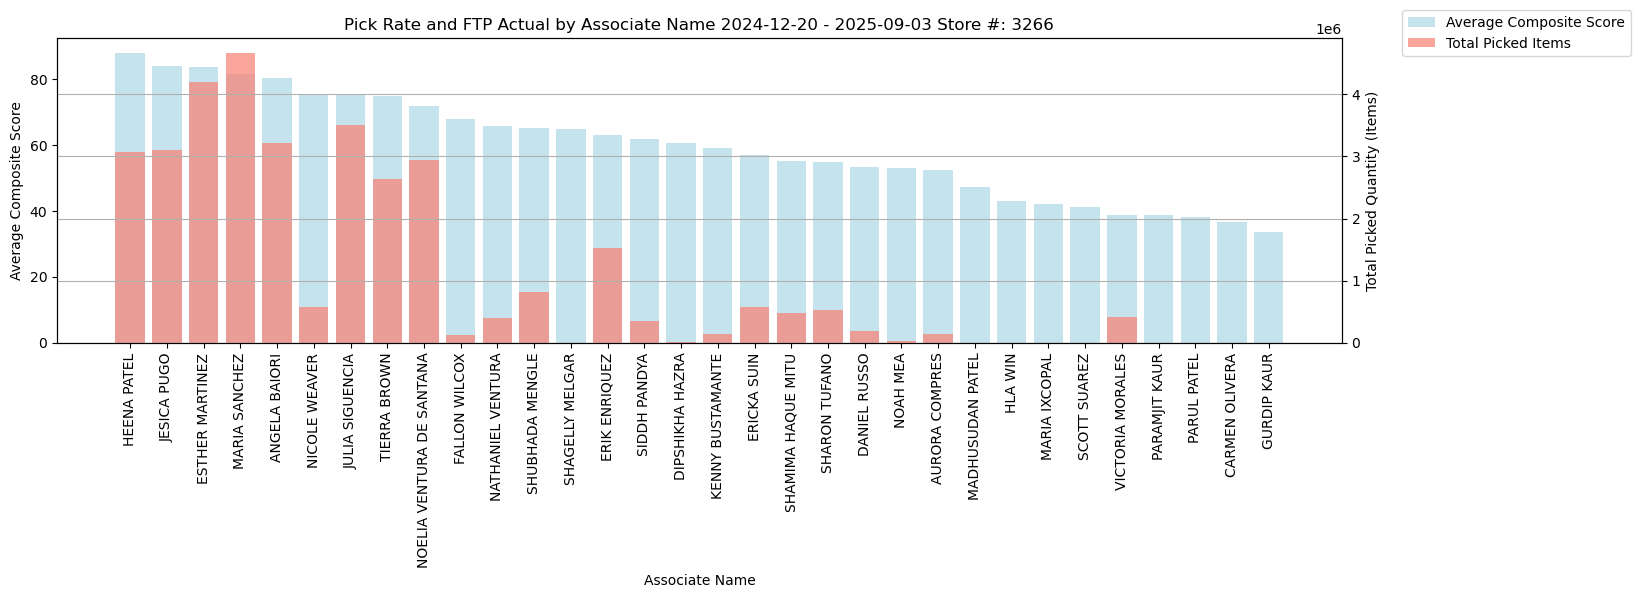

In [476]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['FTP Actual'] = pd.to_numeric(df['FTP Actual'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite Score'] = pd.to_numeric(df['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['FTP Actual'] = pd.to_numeric(df_selected_store['FTP Actual'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Composite Score'] = pd.to_numeric(df_selected_store['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
#df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite Score'])
df_clean = df_selected_store.dropna(subset=['FTP Actual', 'Composite Score']).copy()
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate')['Composite Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate')['FTP Actual'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate Name')
ax1.set_ylabel('Average Composite Score')
ax1.set_title(f'Pick Rate and FTP Actual by Associate Name {oldest_pick_date} - {last_pick_date} Store #: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score LW to Average</h2>

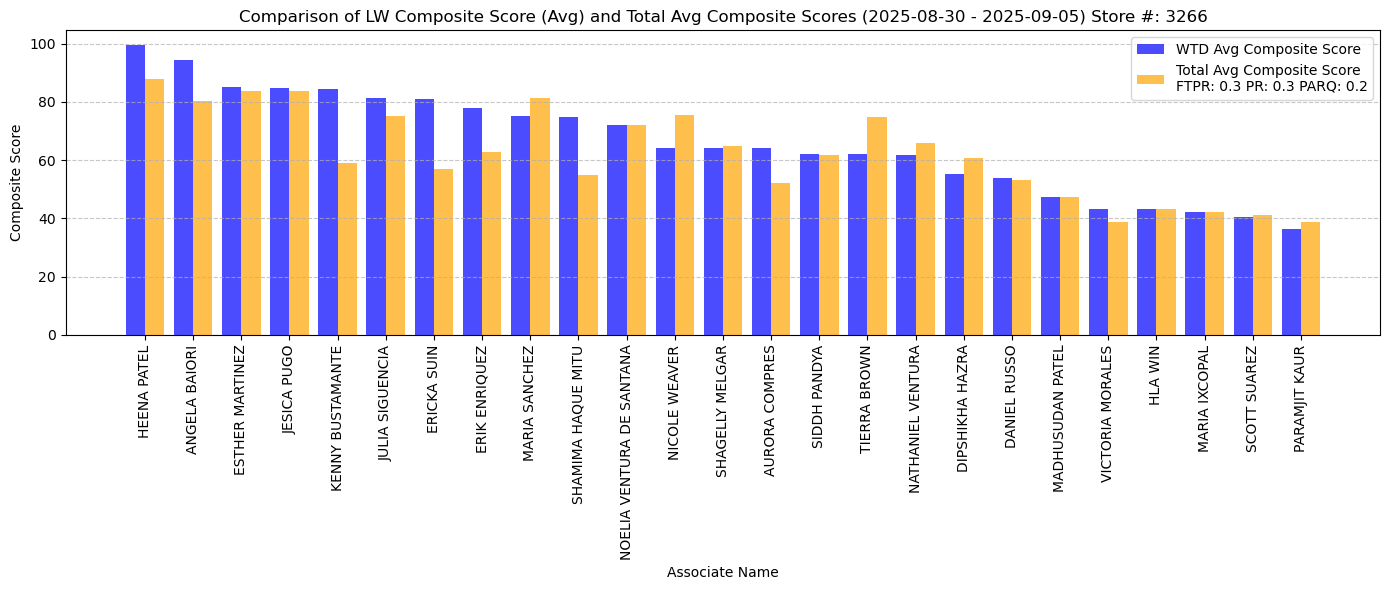

In [477]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite Score'] = most_recent_week_data['Composite Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate'])['Composite Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate'])['Composite Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='WTD Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate Name')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of LW Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start} - {last_full_week_end}) Store #: {selected_store}')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison WTD (full week) to Average</h2>

associate_ids_this_week: ['ERIK ENRIQUEZ' 'ERICKA SUIN' 'DANILO PANALES' 'DIPSHIKHA HAZRA'
 'ESTHER MARTINEZ' 'VICTORIA MORALES' 'SIDDH PANDYA' 'MARIA SANCHEZ'
 'NOELIA VENTURA DE SANTANA' 'NATHANIEL VENTURA' 'SCOTT SUAREZ'
 'SHAGELLY MELGAR' 'JULIA SIGUENCIA' 'GABRIEL NYDICK' 'JESICA PUGO'
 'HLA WIN' 'ANGELA BAIORI' 'CIANA RIPA' 'KENNY BUSTAMANTE'
 'MADHUSUDAN PATEL' 'SHAMIMA HAQUE MITU' 'RYAAN RAFI' 'DANIELLE CASIANO'
 'PARAMJIT KAUR' 'SOHRAB ZARGHANISHIRAZ' 'NICOLE WEAVER' 'TIERRA BROWN'
 'DANIEL RUSSO' 'AURORA COMPRES' 'RASHEED WALLACE' 'MAGDALENA GRIJALVA'
 'MARIA IXCOPAL' 'HEENA PATEL']


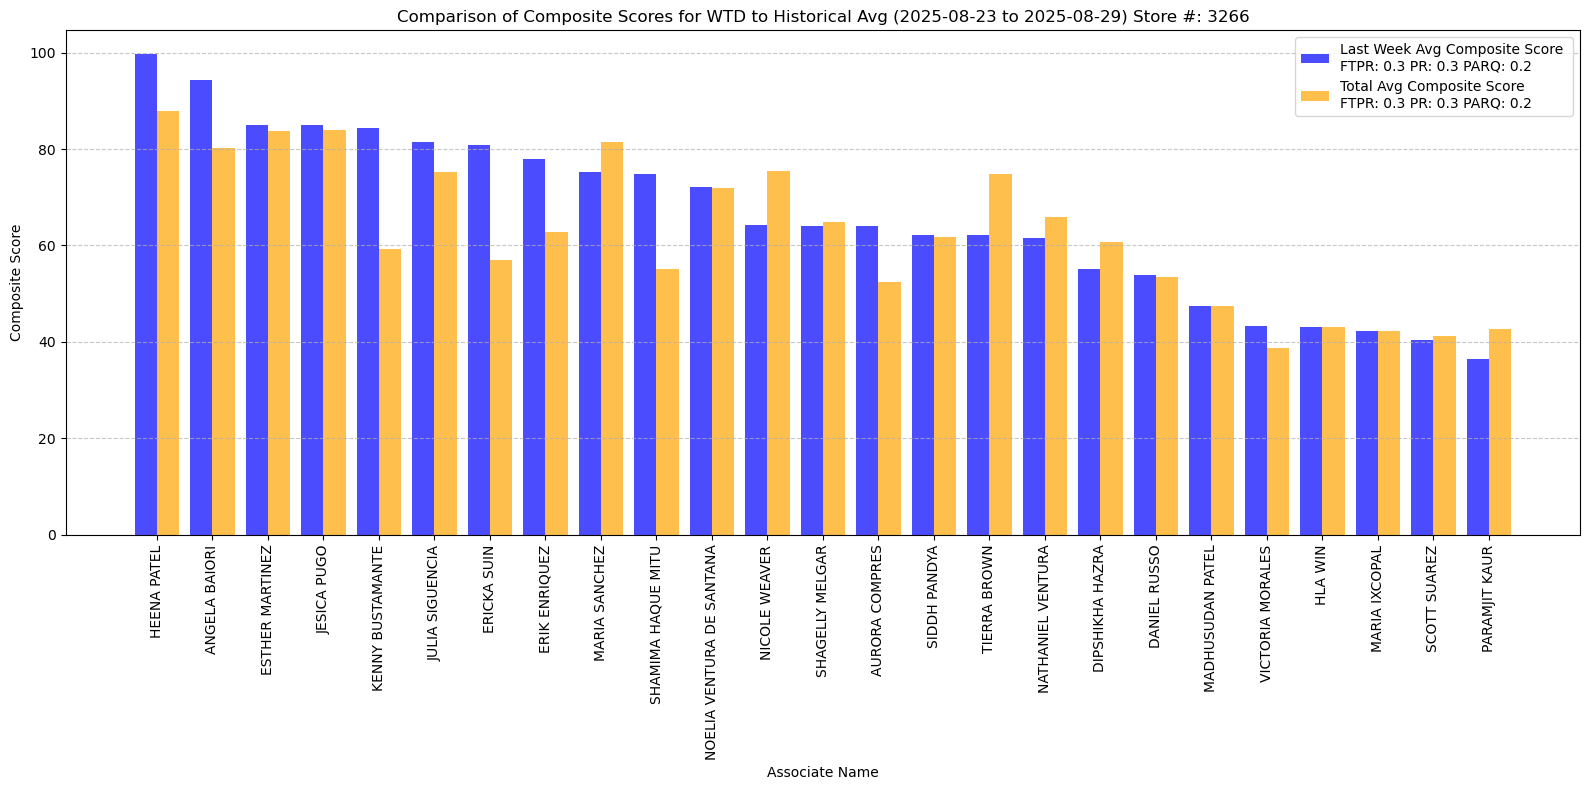

In [478]:
import pandas as pd
import matplotlib.pyplot as plt

today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

if wtd_data.empty:
    print("No data available for the current week-to-date (WTD). Cannot proceed with analysis.")
else:    
    # Fill NaN values in 'Composite Score' (if any)
    wtd_data['Composite Score'] = wtd_data['Composite Score'].fillna(0)
    wtd_data = wtd_data[wtd_data['Composite Score'] > 0]  # Filter for Composite Score > 0

    # Step 6: Group by Associate ID and calculate average Composite Score for the last week
    avg_composite_score_last_week = (
        wtd_data.groupby('Associate')['Composite Score']
        .mean()
        .sort_values(ascending=False)
    )

    # Step 7: Filter total average Composite Score to include only Names in last_week_data
    associate_ids_this_week = wtd_data['Associate'].unique()  # Get unique Associate Names from last_week_data
    total_avg_composite_score = (
        df_selected_store[df_selected_store['Composite Score'] > 0]
        .groupby('Associate')['Composite Score']
        .mean()
        .loc[associate_ids_this_week]  # Filter to include only Associate Names from last_week_data
    )
    print(f'associate_ids_this_week: {associate_ids_this_week}')
    if selected_store == 3266:
        total_avg_composite_score = total_avg_composite_score[total_avg_composite_score.index.isin(associate_list_3266)]

    # Step 8: Merge both scores into a single DataFrame for proper alignment
    comparison_df = pd.DataFrame({
        'Last Week Avg Composite Score': avg_composite_score_last_week,
        'Total Avg Composite Score': total_avg_composite_score
    }).fillna(0)
    if selected_store == 3266:
        comparison_df = comparison_df[comparison_df.index.isin(associate_list_3266)]

    comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

    # Step 9: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))

    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions

    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['Last Week Avg Composite Score'], 
        width=width, 
        label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
        color='blue', 
        alpha=0.7
    )

    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Total Avg Composite Score'], 
        width=width, 
        label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
        color='orange', 
        alpha=0.7
    )

    # Set labels and title
    ax.set_xlabel('Associate Name')
    ax.set_ylabel(f'Composite Score')
    ax.set_title(f'Comparison of Composite Scores for WTD to Historical Avg ({last_full_week}) Store #: {selected_store}')

    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)

    # Add a legend
    ax.legend()

    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

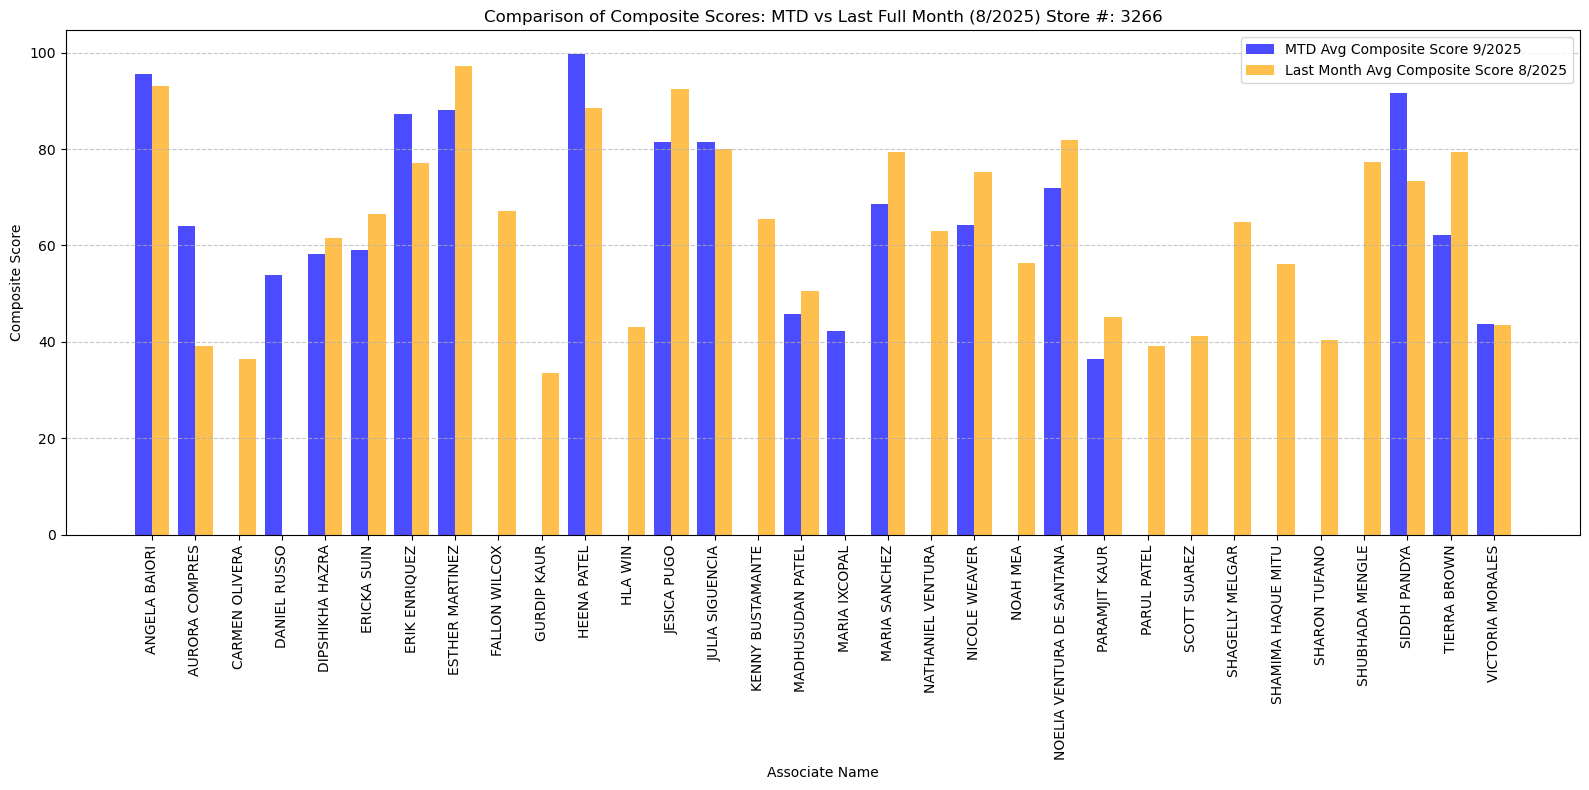

In [479]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df_selected_store['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == current_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == current_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Last full month data
last_month_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == last_month_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == last_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_mtd = avg_composite_score_mtd[avg_composite_score_mtd.index.isin(associate_list_3266)]
avg_composite_score_last_month = last_month_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_last_month = avg_composite_score_last_month[avg_composite_score_last_month.index.isin(associate_list_3266)]
is_empty = mtd_data['Composite Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label=(f'MTD Avg Composite Score {current_month}/{current_year}'), 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label=(f'Last Month Avg Composite Score {last_month}/{last_month_year}'), 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate Name')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year}) Store #: {selected_store}')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


<h2>Total Performance By Selected Month by Associate</h2>

In [480]:
'''
# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

df_selected_store = df[df['Store #'] == selected_store].copy()
# Group by Associate, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df_selected_store.groupby(['Associate', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()
    '''


"\n# Extract Year, Month\ndf['Year'] = df['Day of Pick Date'].dt.year\ndf['Month'] = df['Day of Pick Date'].dt.month\n\n# Compute the first day of the month for each row\ndf['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))\n\n# Compute the week number of the first day of the month\ndf['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week\n\n# Compute the actual week of the month\ndf['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1\n\n# Define the metrics and their aggregation type\nmetrics_agg = {\n    'FTPR': 'mean',  # Average\n    'Pick Rate': 'mean',  \n    'Pick Hours': 'mean',  \n    'Qty Req to Pick': 'sum',  # Sum\n    'Picked As Req Qty': 'sum',\n    'Substitution Qty': 'sum',\n    'Nil Pick Qty': 'sum',\n    'Exception Qty Req to Pick': 'sum'\n}\n\ndf_selected_store = df[df['Store #'] == selected_store].copy()\n# Group by Associate, Year, Month, and Week of Month, applying aggrega

In [481]:
max_date = df.loc[df['Associate'] == 'GABRIEL NYDICK', 'Day of Pick Date'].max()
df = df.drop_duplicates(subset=['Associate', 'Day of Pick Date'])
df[(df['Associate'] == 'GABRIEL NYDICK') & (df['Day of Pick Date'] == max_date)]

Associate ID  Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market       Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
60152      g0n018d  GABRIEL NYDICK     3266       2025-09-02  94.98           259         246      111.2        2.28                246                 7       0.0            21                         11                            0                           1                      10                     0                    0              259     178  GABRIEL NYDICK              1     Tuesday        2025-08-30      2025-09-05  2025-08-30 to 2025-09-05                   1          111.282                        0        0.084942          0       4.720283   4.56414       91.164993            69.481606             10.000162

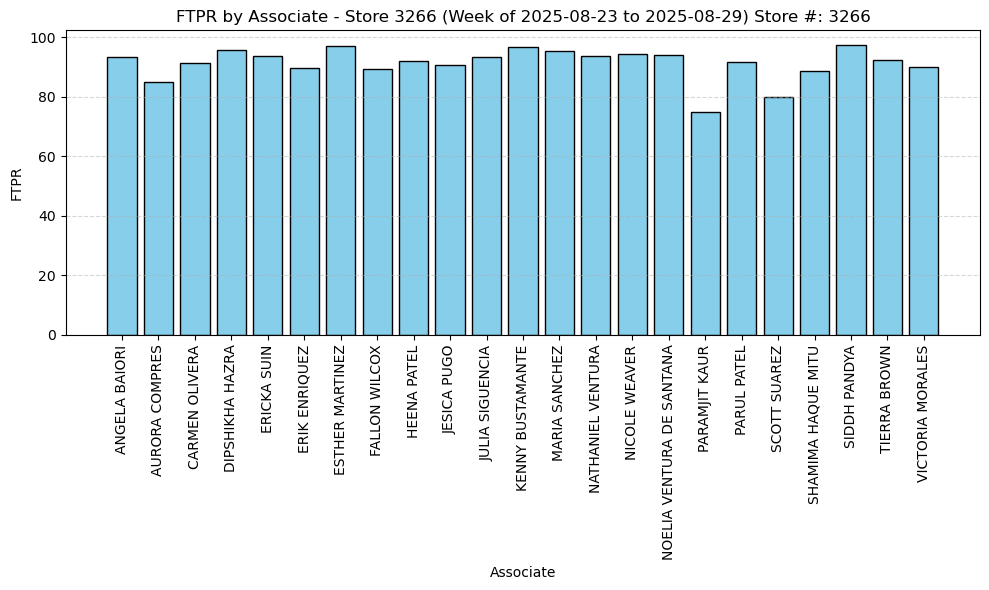

In [482]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime format
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])

# Today reference
today = pd.Timestamp.today()
today = pd.to_datetime(datetime.now())
#today = dt.datetime.today()

# Get last full week end date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'], errors='coerce')
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'], errors='coerce')

last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

# Filter for selected store and last full week
df_selected_store = df.loc[df['Store #'] == selected_store].copy()
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].apply(lambda x: x in associate_list_3266)]

df_lw = df_selected_store[
    (df_selected_store['Custom Week End'] == last_full_week_end) |
    (df_selected_store['Custom Week Start'] == last_full_week_start)
]

# Group by Associate and calculate mean FTPR
ftp_summary = df_lw.groupby('Associate')['FTPR'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(ftp_summary['Associate'], ftp_summary['FTPR'], color='skyblue', edgecolor='black')

plt.title(f'FTPR by Associate - Store {selected_store} (Week of {last_full_week_start.date()} to {last_full_week_end.date()}) Store #: {selected_store}')
plt.xlabel('Associate')
plt.ylabel('FTPR')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<h1>Graph LW FTPR by Associate for each day worked</h1>

Last full week end date: 2025-08-29
Last full week start date: 2025-08-23


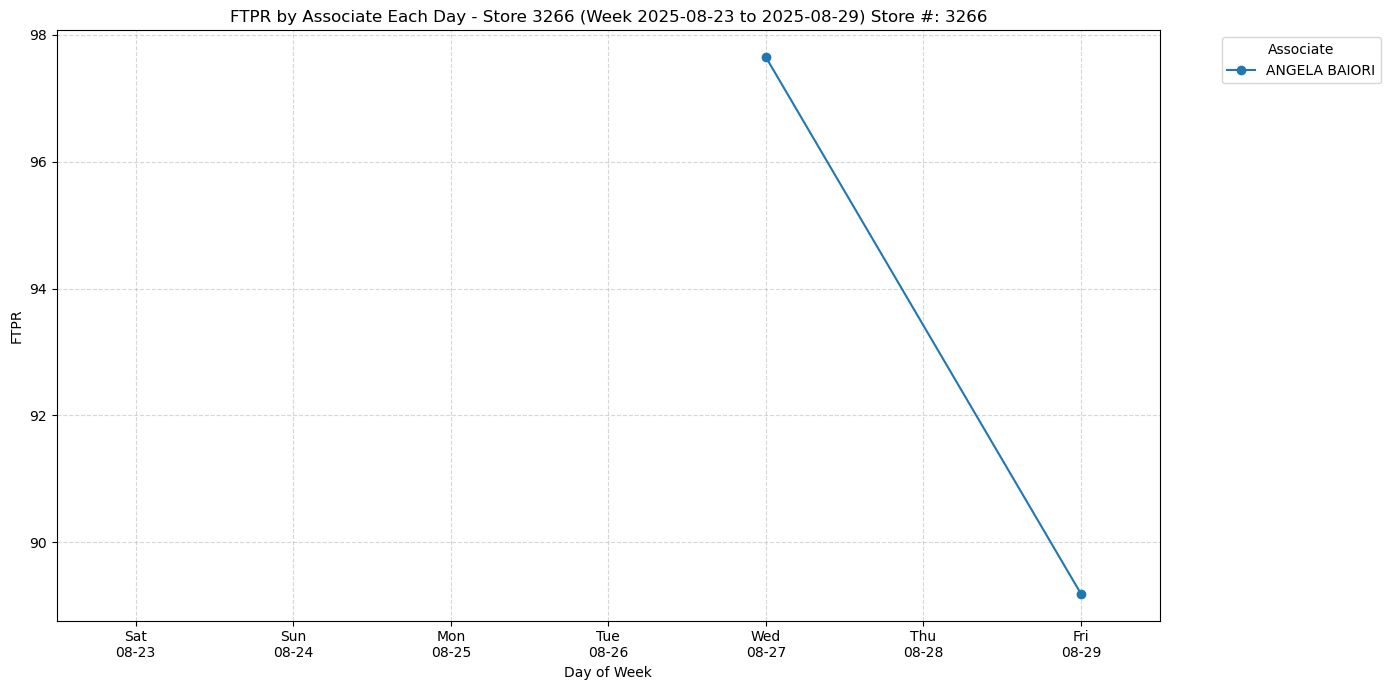

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
75386      a0b0ad9  ANGELA BAIORI     3266       2025-08-27  97.65           170         166       44.0        3.90                170                 2       0.0             0                          1                            0                           0                       1                     0                    0              170     178  ANGELA BAIORI     

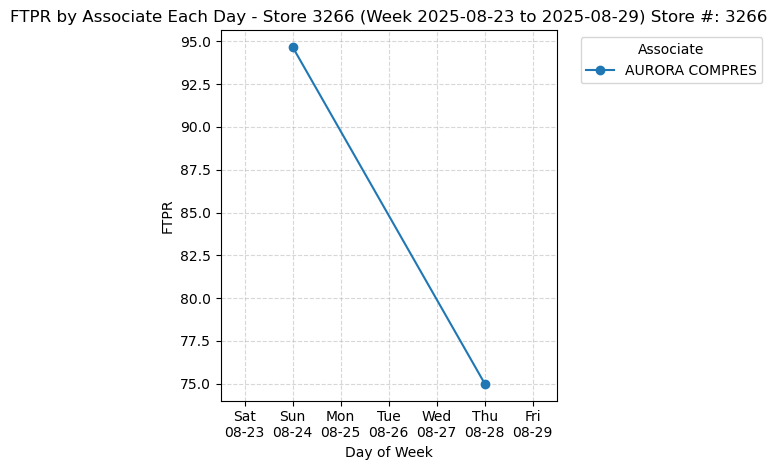

      Associate ID  Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market       Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
78856      a0c02mv  AURORA COMPRES     3266       2025-08-24  94.66           131         124       31.7        3.94                124                 1       0.0             5                          0                            0                           0                       0                     0                    0              131     178  AURORA COMPRES 

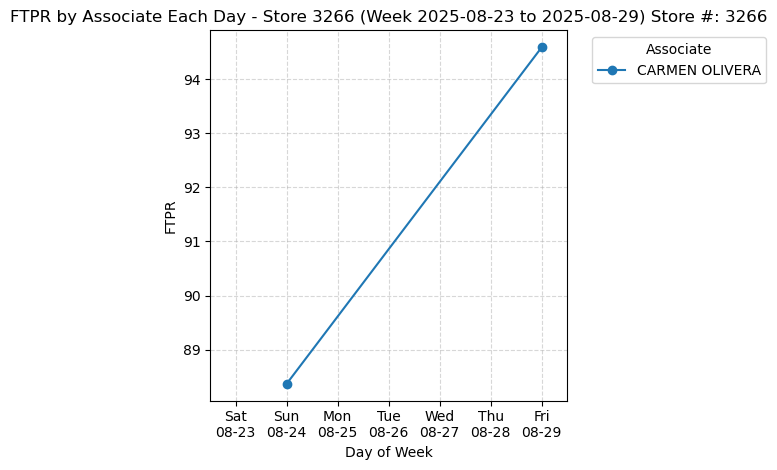

      Associate ID  Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market       Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
78907      cmo0039  CARMEN OLIVERA     3266       2025-08-24  88.37            43          38       12.7        2.98                 38                 0       0.0             4                          1                            1                           0                       0                     0                    0               43     178  CARMEN OLIVERA 

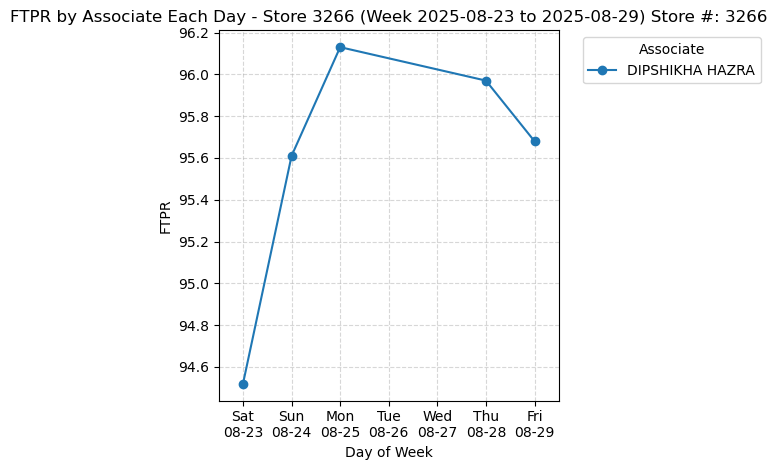

      Associate ID   Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79826      d0h0u6h  DIPSHIKHA HAZRA     3266       2025-08-23  94.52           146         138       41.5        3.47                143                 1       0.0             0                          0                            0                           0                       0                     0                    0              146     178  DIPSHIKHA HA

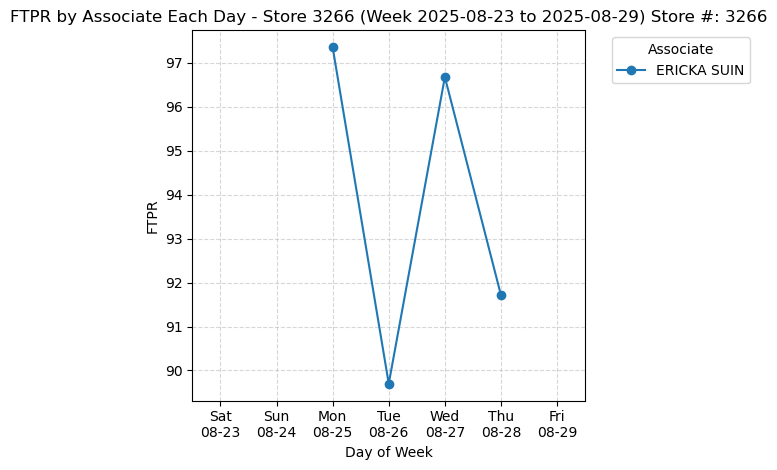

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
78026      e0s0frj    ERICKA SUIN     3266       2025-08-25  97.35           113         110       45.6        2.52                110                 5       0.0             4                          0                            0                           0                       0                     0                    0              113     178  ERICKA SUIN         

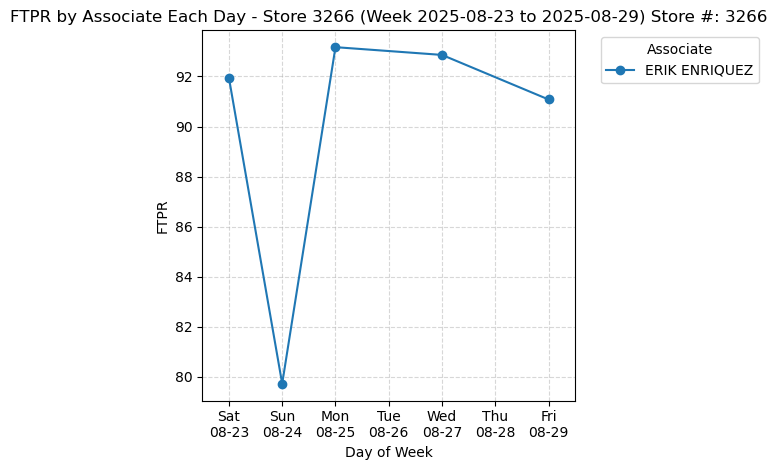

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79875      e0e04sh  ERIK ENRIQUEZ     3266       2025-08-23  91.95           298         274       92.7        3.13                274                16       0.0             5                          4                            0                           0                       4                     0                    0              298     178  ERIK ENRIQUEZ     

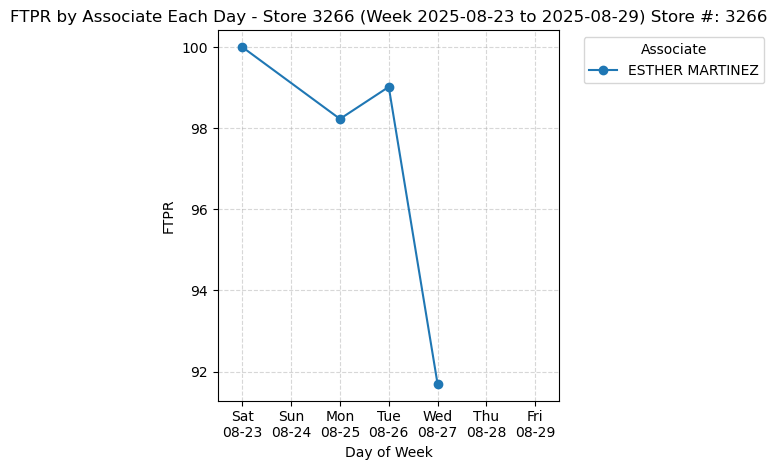

      Associate ID   Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80046      e0m0abw  ESTHER MARTINEZ     3266       2025-08-23  100.00           146         146       82.6        1.77                146                 0       0.0             5                          0                            0                           0                       0                     0                    0              146     178  ESTHER MAR

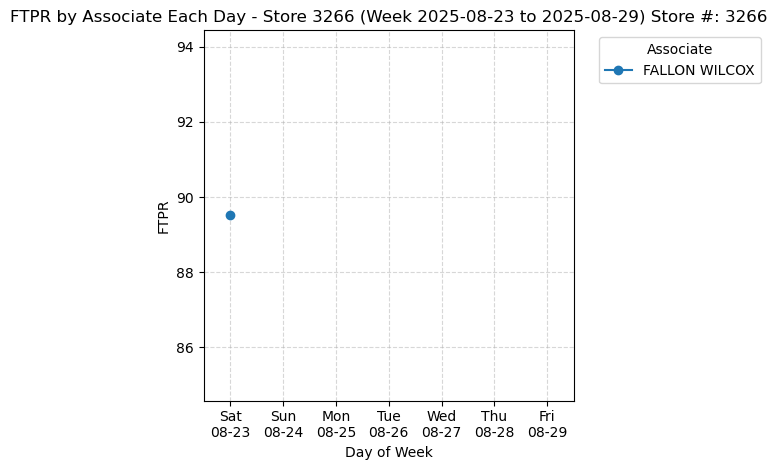

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80132      f0w03c8  FALLON WILCOX     3266       2025-08-23  89.51           162         145       45.1        3.44                150                 5       0.0             5                          0                            0                           0                       0                     0                    0              162     178  FALLON WILCOX     

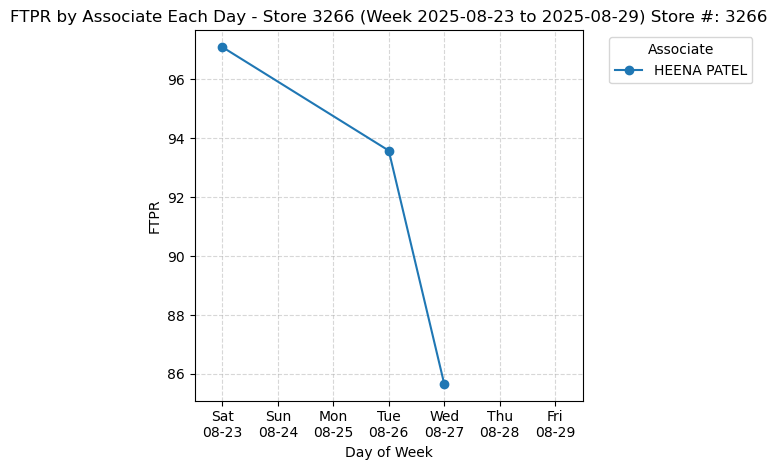

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80374      h0p01q8    HEENA PATEL     3266       2025-08-23  97.09           103         100       43.4        2.60                110                 3       0.0             3                          0                            0                           0                       0                     0                    0              103     178  HEENA PATEL         

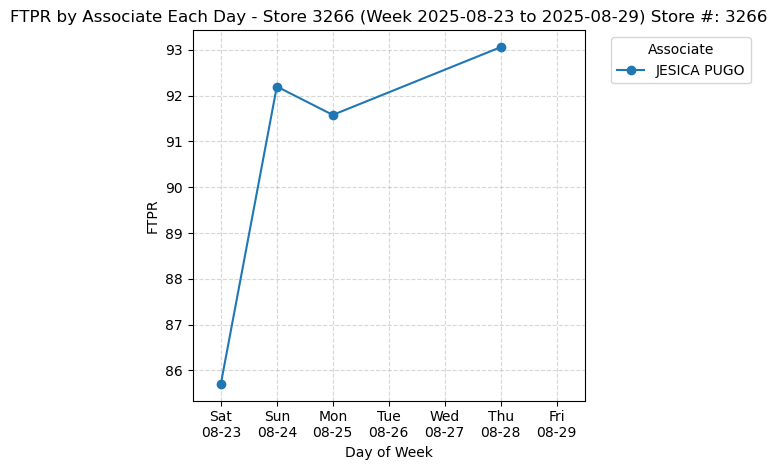

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80442      j0p0vpl    JESICA PUGO     3266       2025-08-23  85.71            98          84       45.8        1.85                 84                 1       0.0            13                          0                            0                           0                       0                     0                    0               98     178  JESICA PUGO         

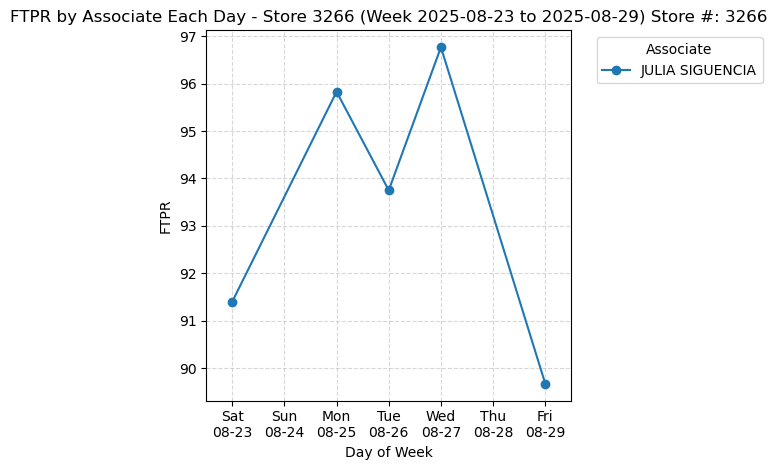

      Associate ID   Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80581      jrsigue  JULIA SIGUENCIA     3266       2025-08-23  91.40           314         287       57.4        5.50                301                15       0.0            14                          5                            1                           0                       4                     0                    0              314     178  JULIA SIGUEN

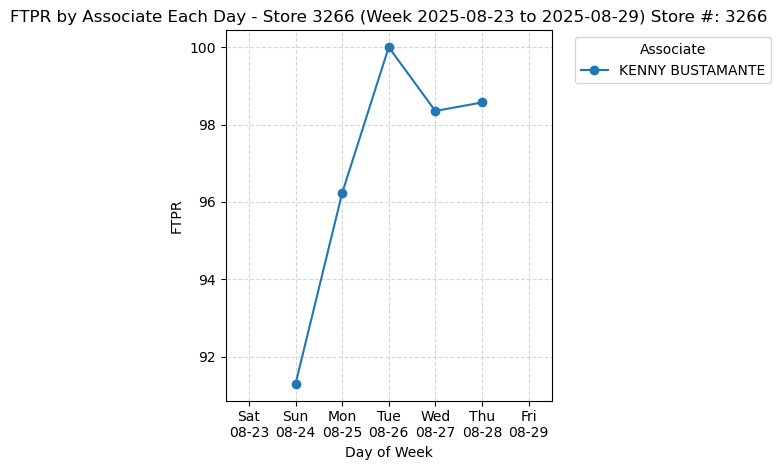

      Associate ID    Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79374      k0b09gt  KENNY BUSTAMANTE     3266       2025-08-24   91.30            23          21       29.6        0.74                 21                 1       0.0             0                          0                            0                           0                       0                     0                    0               23     178  KENNY B

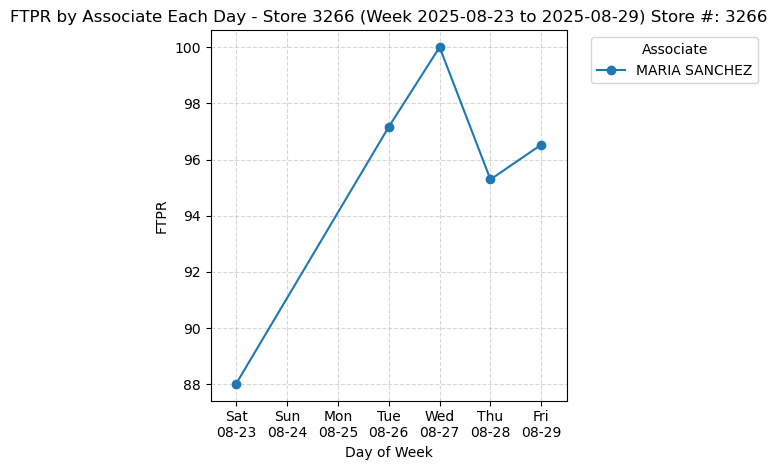

      Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80690      mgs004k  MARIA SANCHEZ     3266       2025-08-23   88.02           192         169       46.5        4.00                183                 3       0.0             8                          0                            0                           0                       0                     0                    0              192     178  MARIA SANCHEZ   

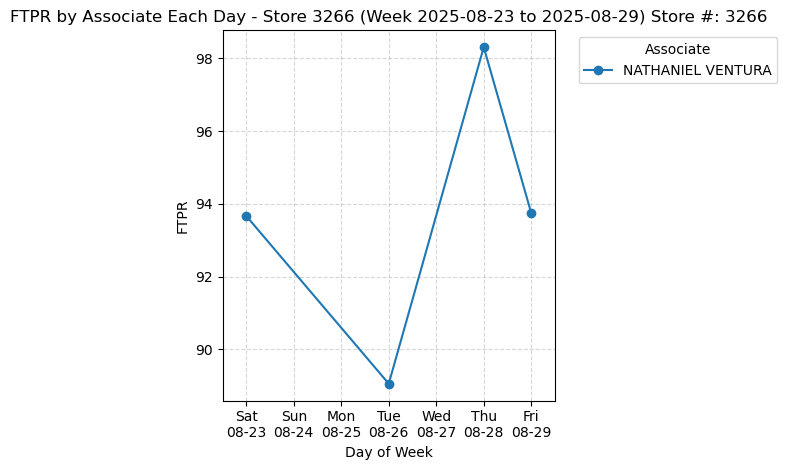

      Associate ID     Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market          Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80880      n0v0359  NATHANIEL VENTURA     3266       2025-08-23  93.67            79          74       76.6        1.03                 79                 0       0.0             0                          3                            3                           0                       0                     0                    0               79     178  NATHAN

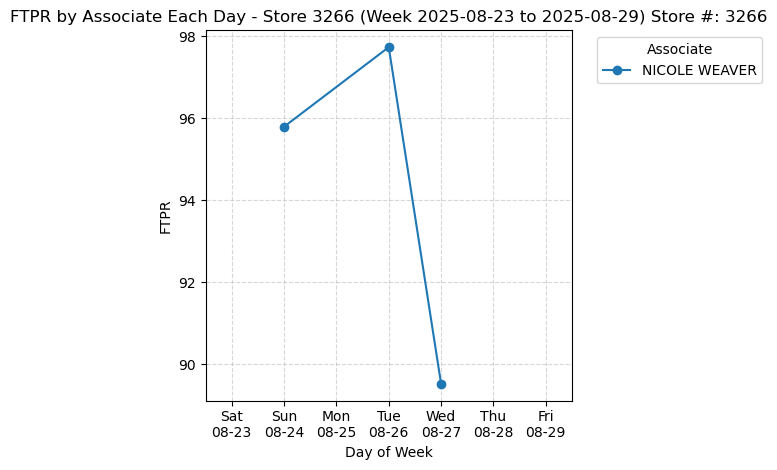

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79461      n0w044f  NICOLE WEAVER     3266       2025-08-24  95.79           214         205       63.1        3.31                205                 4       0.0             5                          0                            0                           0                       0                     0                    0              214     178  NICOLE WEAVER     

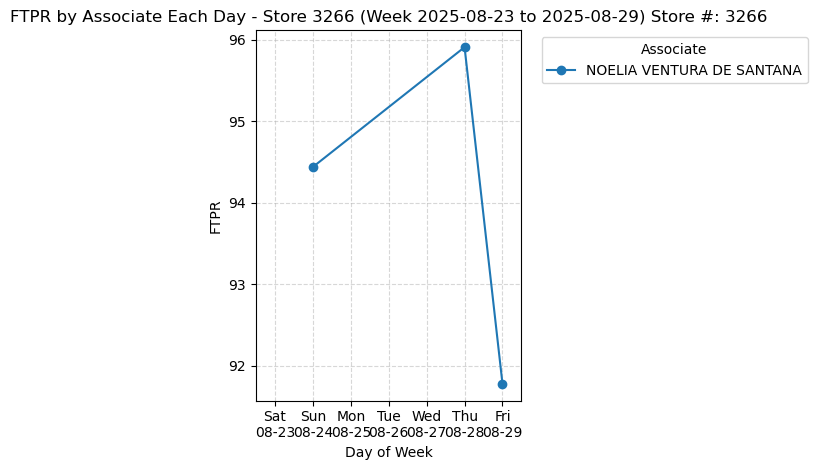

      Associate ID             Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market                  Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79584      n0v03hh  NOELIA VENTURA DE SANTANA     3266       2025-08-24  94.44            90          85       38.5        2.21                 85                 0       0.0            12                          0                            0                           0                       0                     0                    0         

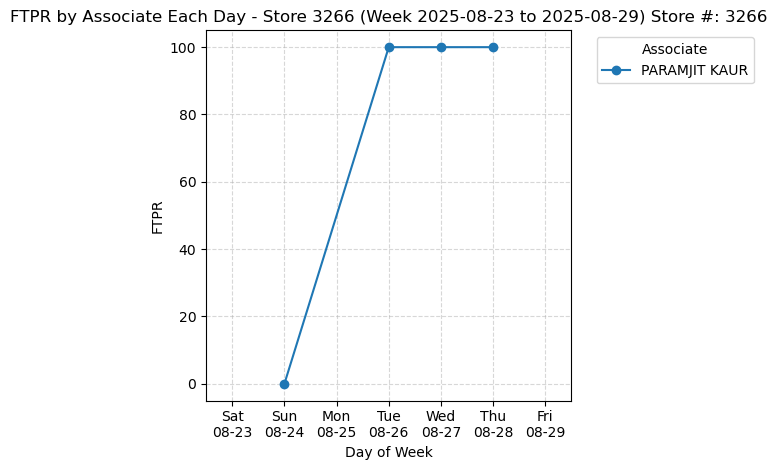

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79609      p0k010w  PARAMJIT KAUR     3266       2025-08-24    0.0             1           0        0.0        0.00                  0                 0       0.0             1                          0                            0                           0                       0                     0                    0                1     178  PARAMJIT KAUR     

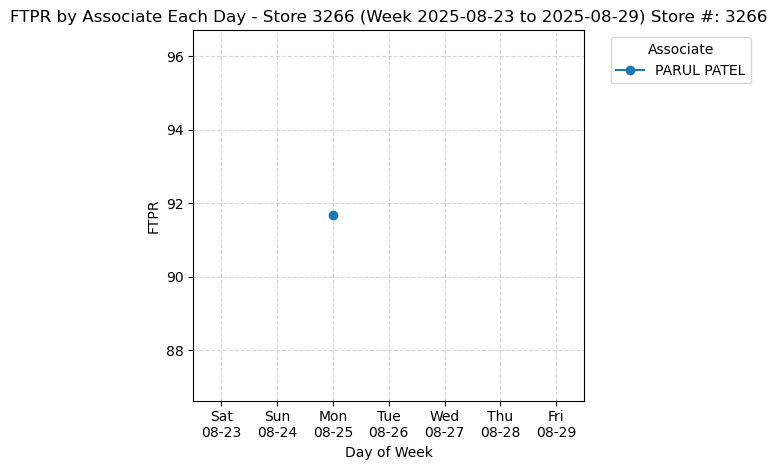

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
78632      p0p0136    PARUL PATEL     3266       2025-08-25  91.67            36          33       24.9        1.32                 33                 0       0.0             1                          0                            0                           0                       0                     0                    0               36     178  PARUL PATEL         

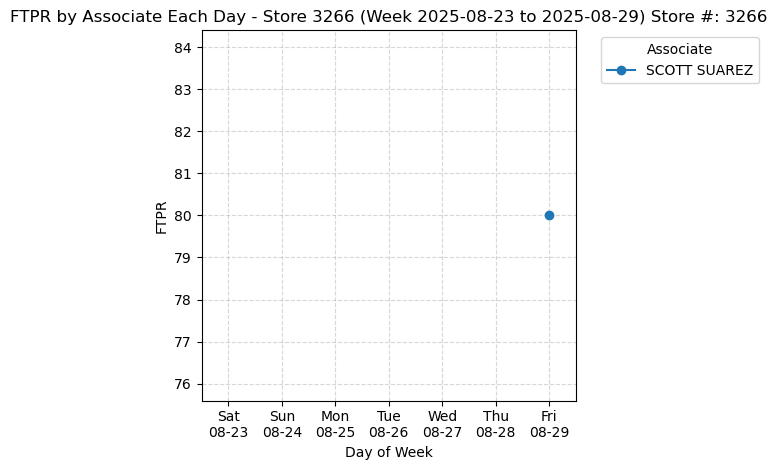

      Associate ID Associate Name  Store # Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
73953      sps0025   SCOTT SUAREZ     3266       2025-08-29  80.0             5           4       10.5        0.38                  4                 0       0.0             0                          0                            0                           0                       0                     0                    0                5     178  SCOTT SUAREZ         

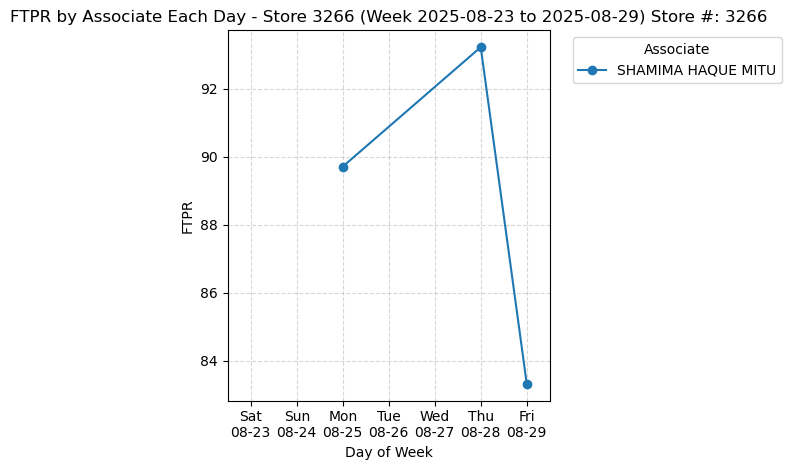

      Associate ID      Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market           Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
78660      s0m0uve  SHAMIMA HAQUE MITU     3266       2025-08-25  89.71            68          61       43.9        1.41                 61                 1       0.0             0                         12                            2                           3                       0                     0                    0               68     178  SHA

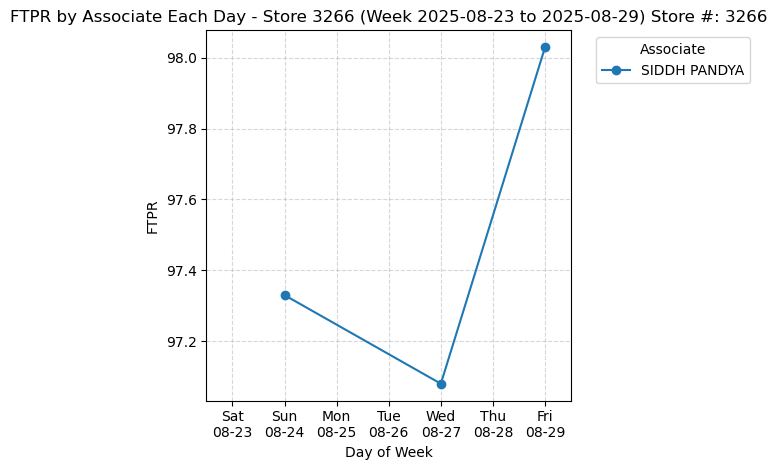

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79668      s0p0hsd   SIDDH PANDYA     3266       2025-08-24  97.33            75          73       65.7        1.13                 73                 1       0.0             1                          0                            0                           0                       0                     0                    0               75     178  SIDDH PANDYA       

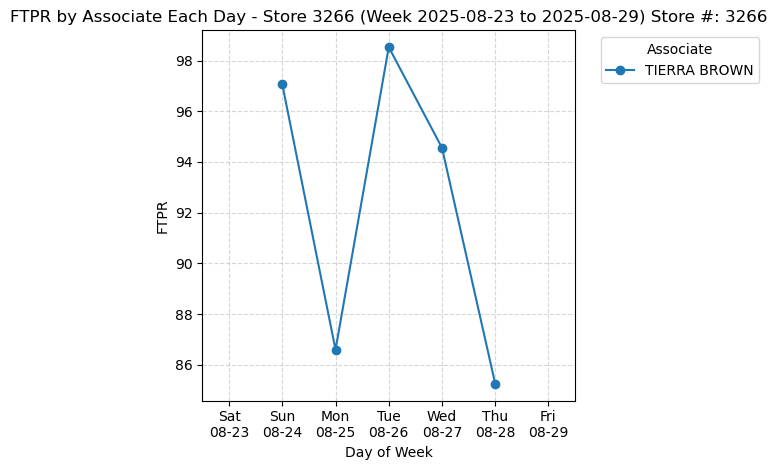

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
79697      t0b0hm5   TIERRA BROWN     3266       2025-08-24  97.06           136         132       55.1        2.41                132                 1       0.0             6                          0                            0                           0                       0                     0                    0              136     178  TIERRA BROWN       

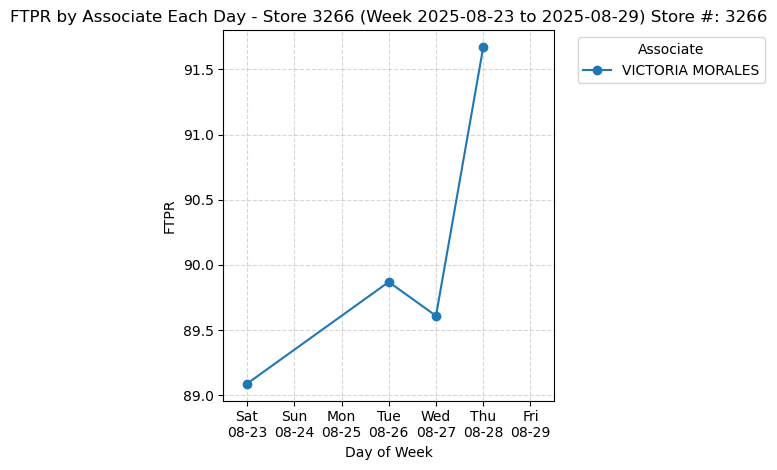

      Associate ID    Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
80907      v0m07r6  VICTORIA MORALES     3266       2025-08-23  89.09            55          49       68.8        0.71                 49                 0       0.0             6                          0                            0                           0                       0                     0                    0               55     178  VICTORIA 

In [483]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime format
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])
# Convert specific columns to datetime
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'], errors='coerce')
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'], errors='coerce')
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], errors='coerce')
# Today reference
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")

# Get last full week end date
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
print(f"Last full week end date: {last_full_week_end.date()}")
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()
print(f"Last full week start date: {last_full_week_start.date()}") 

# Filter for selected store and last full week
df_selected_store = df.loc[df['Store #'] == selected_store].copy()
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].apply(lambda x: x in associate_list_3266)]

# Filter for last full week (all days in that week)
df_lw = df_selected_store[
    (df_selected_store['Custom Week Start'] == last_full_week_start) &
    (df_selected_store['Custom Week End'] == last_full_week_end)
]

# Sort by Associate and Day of Pick Date for plotting
df_lw = df_lw.sort_values(['Associate', 'Day of Pick Date'])

# Set full week for consistent x-axis
week_start = df_lw['Day of Pick Date'].min().normalize()
week_dates = pd.date_range(start=week_start, periods=7, freq='D')
week_of_interest = df_lw['Week'].max()

# Plot
plt.figure(figsize=(14, 7))
for associate, group in df_lw.groupby('Associate'):
    plt.plot(group['Day of Pick Date'], group['FTPR'], marker='o', label=associate)

    plt.title(f'FTPR by Associate Each Day - Store {selected_store} (Week {week_of_interest}) Store #: {selected_store}')
    plt.xlabel('Day of Week')
    plt.ylabel('FTPR')
    plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])  # e.g., Mon\n05-13
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    # Add padding to the left and right
    left_pad = pd.Timedelta(days=0.5)
    right_pad = pd.Timedelta(days=0.5)
    plt.xlim(week_dates.min() - left_pad, week_dates.max() + right_pad)
    plt.legend(title='Associate', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(f'{df_lw.loc[df_lw["Associate"] == associate]}')

<h1>Graph FTPR for each Associate WTD by day worked</h1>

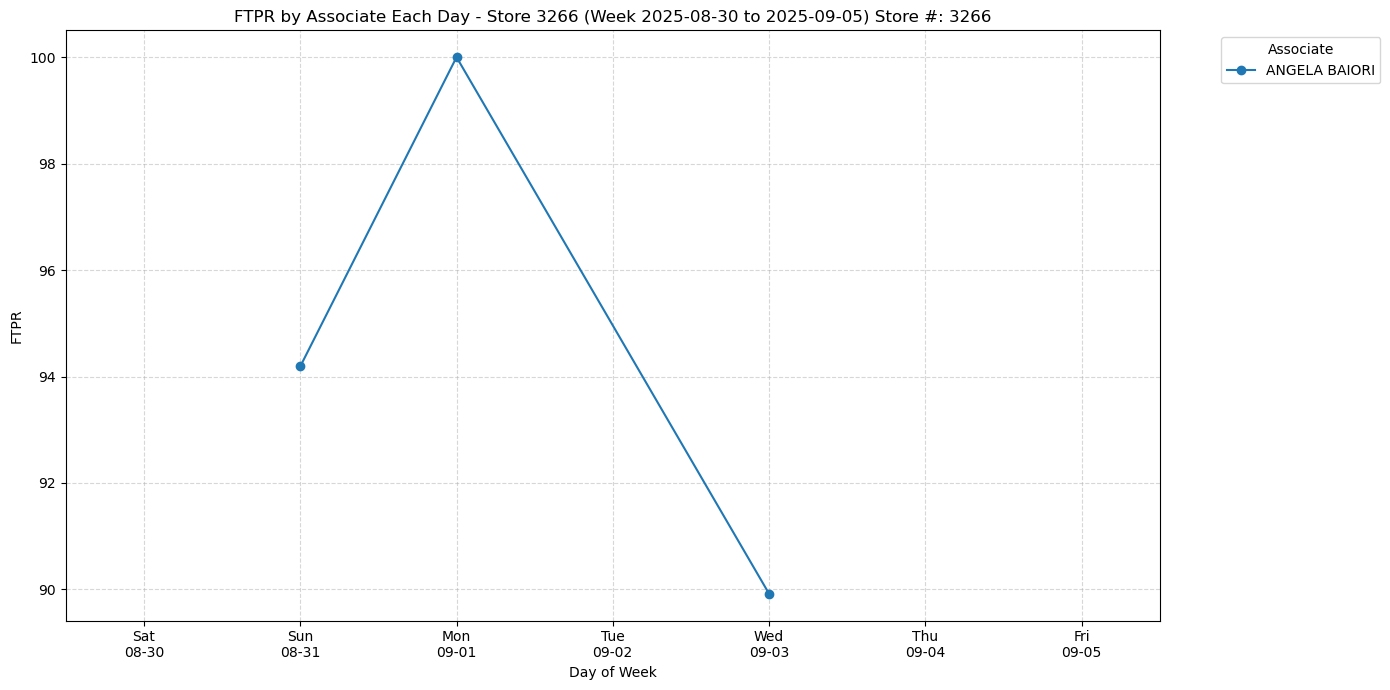

      Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
69391      a0b0ad9  ANGELA BAIORI     3266       2025-08-31   94.19           258         243       47.7        5.30                243                10       0.0            19                          2                            0                           0                       2                     0                    0              258     178  ANGELA BAIORI   

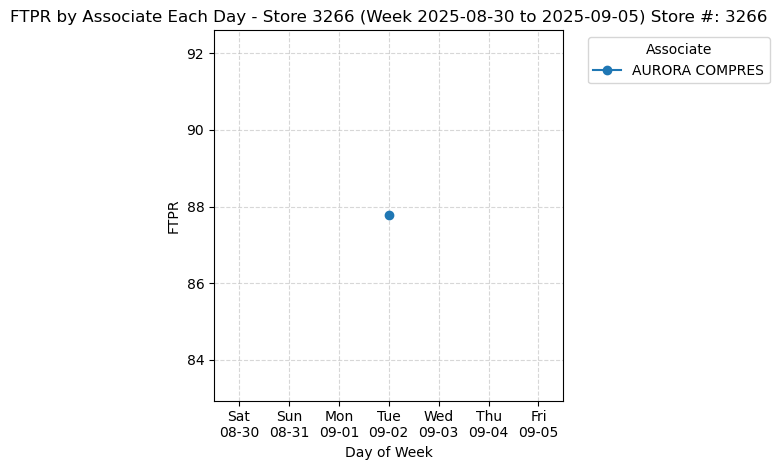

      Associate ID  Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market       Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
59703      a0c02mv  AURORA COMPRES     3266       2025-09-02  87.77           139         122       43.4        2.86                122                 2       0.0            16                          1                            1                           0                       0                     0                    0              139     178  AURORA COMPRES 

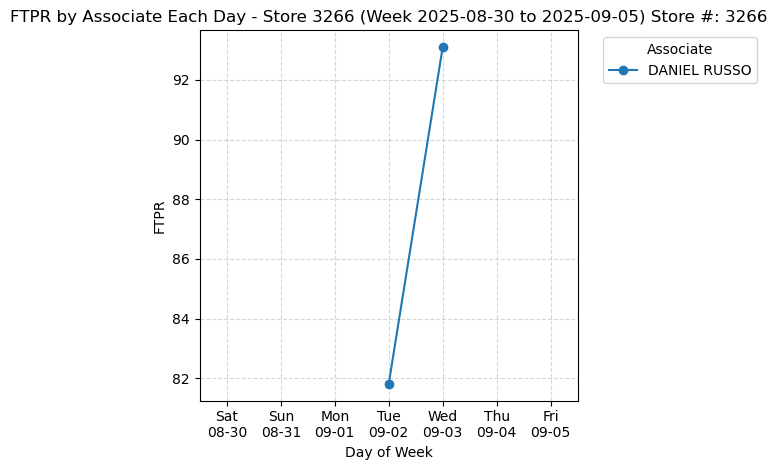

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
59783      d0r0khi   DANIEL RUSSO     3266       2025-09-02  81.82            77          63       48.4        1.45                 63                 7       0.0             9                          0                            0                           0                       0                     0                    0               77     178  DANIEL RUSSO       

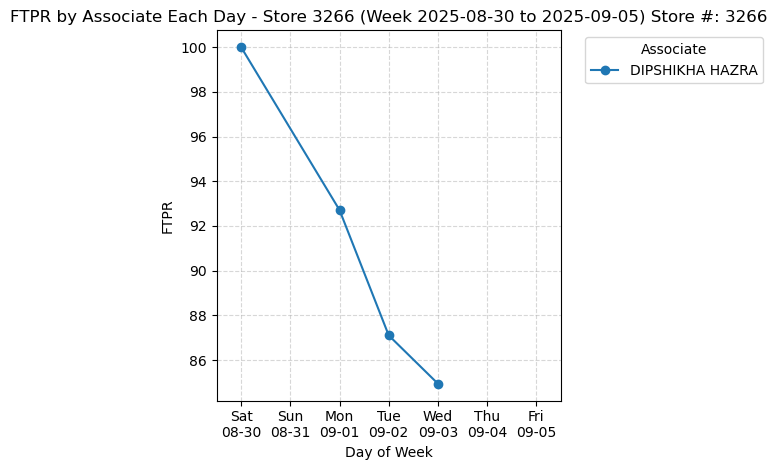

      Associate ID   Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70550      d0h0u6h  DIPSHIKHA HAZRA     3266       2025-08-30  100.00            21          21       37.6        0.56                 21                 0       0.0             0                          0                            0                           0                       0                     0                    0               21     178  DIPSHIKHA 

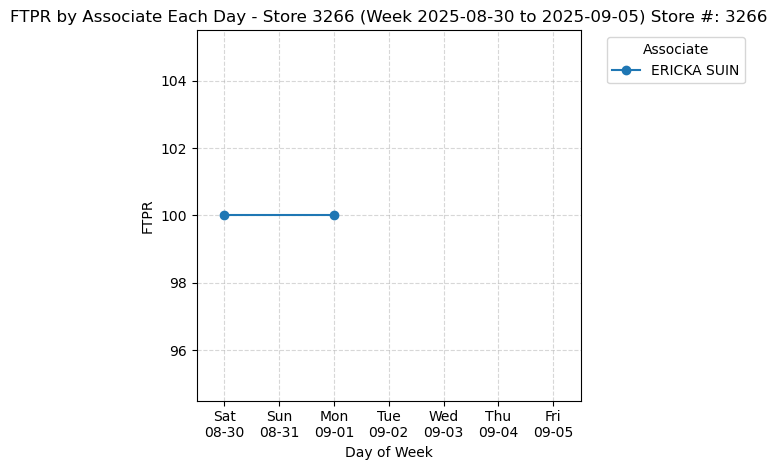

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70645      e0s0frj    ERICKA SUIN     3266       2025-08-30  100.0             7           7      237.7        0.03                  7                 0       0.0             0                          0                            0                           0                       0                     0                    0                7     178  ERICKA SUIN         

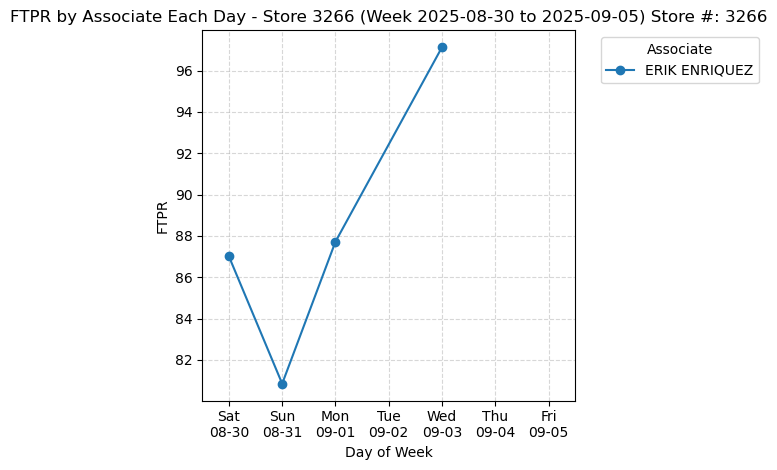

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70669      e0e04sh  ERIK ENRIQUEZ     3266       2025-08-30  87.01           231         201       53.4        4.02                201                14       0.0            19                          6                            0                           0                       6                     0                    0              231     178  ERIK ENRIQUEZ     

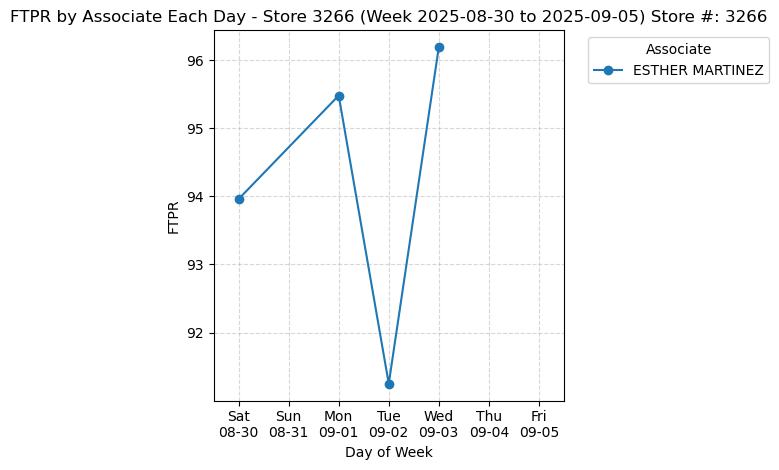

      Associate ID   Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70822      e0m0abw  ESTHER MARTINEZ     3266       2025-08-30  93.96           182         171       44.4        3.94                171                 4       0.0             6                          0                            0                           0                       0                     0                    0              182     178  ESTHER MARTI

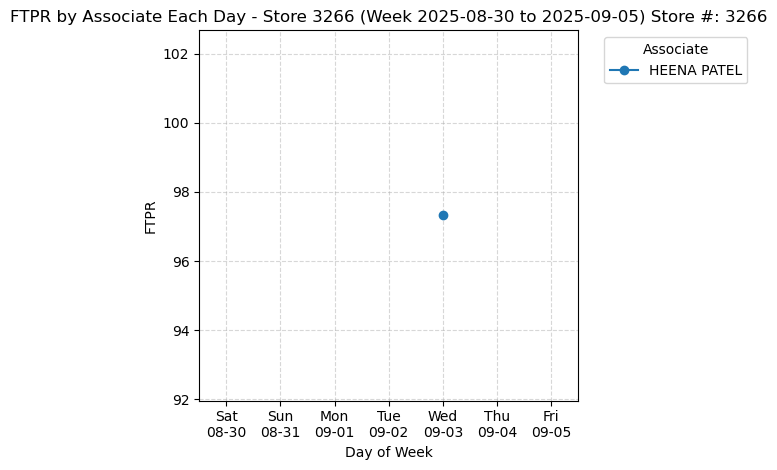

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
58972      h0p01q8    HEENA PATEL     3266       2025-09-03  97.32           261         254       57.9        4.58                263                 2       0.0             7                          0                            0                           0                       0                     0                    0              261     178  HEENA PATEL         

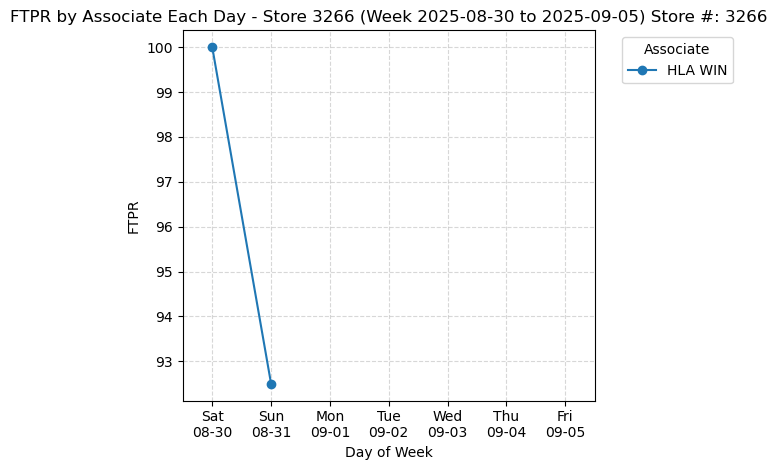

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71042      h0w03bd        HLA WIN     3266       2025-08-30  100.0             2           2       33.6        0.06                  2                 0       0.0             0                          0                            0                           0                       0                     0                    0                2     178   HLA WIN              5

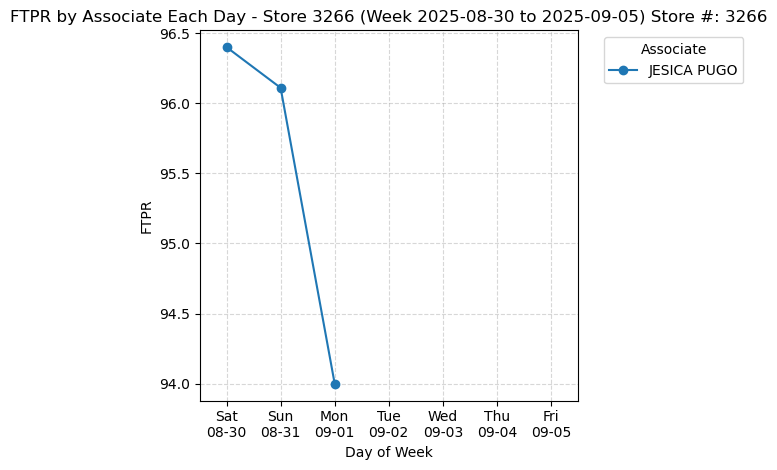

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market    Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71151      j0p0vpl    JESICA PUGO     3266       2025-08-30  96.40           250         241       55.6        4.46                243                 5       0.0            15                          0                            0                           0                       0                     0                    0              250     178  JESICA PUGO         

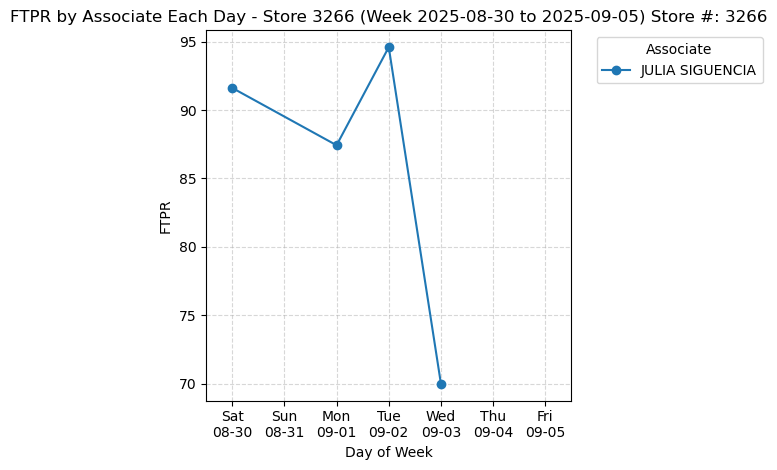

      Associate ID   Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71193      jrsigue  JULIA SIGUENCIA     3266       2025-08-30  91.62           191         175       45.1        4.54                198                 7       0.0             6                          1                            0                           1                       0                     0                    0              191     178  JULIA SIGUEN

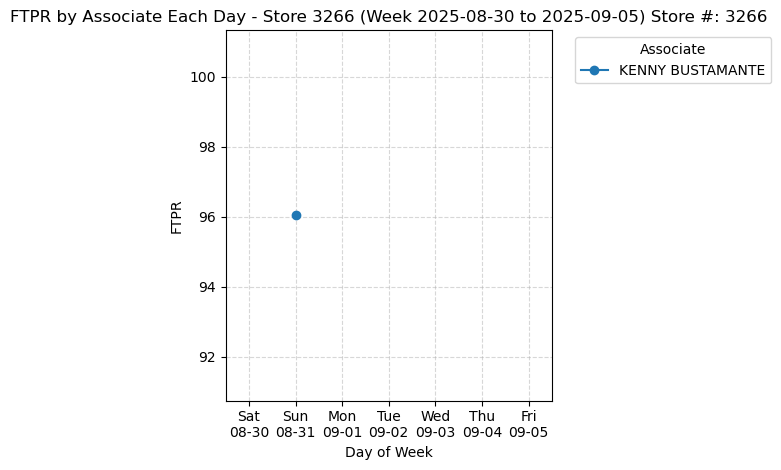

      Associate ID    Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70057      k0b09gt  KENNY BUSTAMANTE     3266       2025-08-31  96.04           202         194       54.5        3.63                194                 4       0.0            11                          0                            0                           0                       0                     0                    0              202     178  KENNY BUS

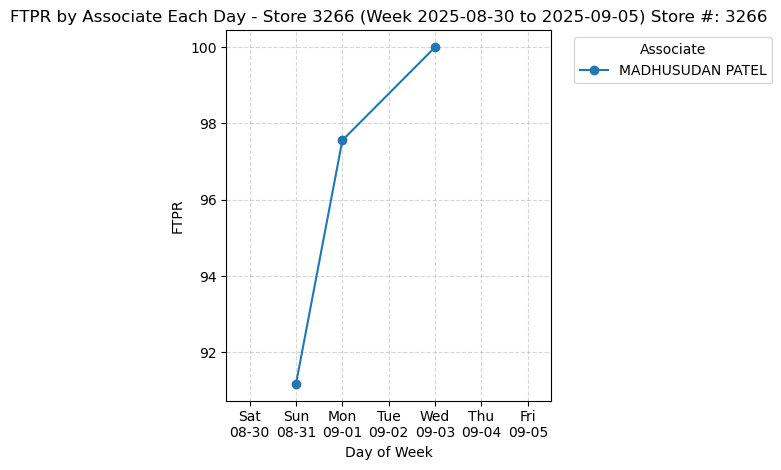

      Associate ID    Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70080      mmp00af  MADHUSUDAN PATEL     3266       2025-08-31   91.18            68          62       35.2        1.85                 62                 3       0.0             2                          0                            0                           0                       0                     0                    0               68     178  MADHUSU

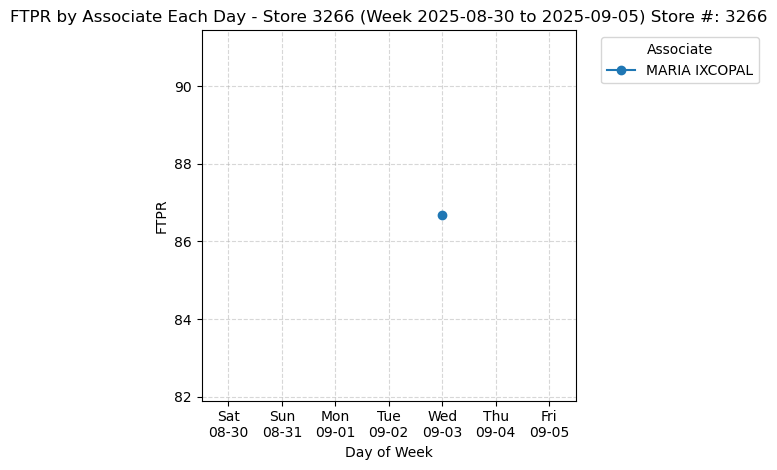

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
59264      m0i01db  MARIA IXCOPAL     3266       2025-09-03  86.67            15          13       45.3        0.29                 13                 0       0.0             1                          0                            0                           0                       0                     0                    0               15     178  MARIA IXCOPAL     

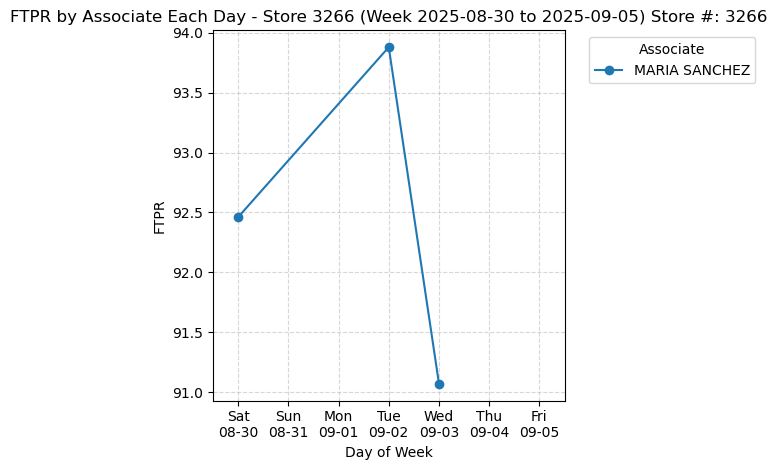

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71390      mgs004k  MARIA SANCHEZ     3266       2025-08-30  92.46           252         233       44.3        5.60                234                14       0.0            13                          0                            0                           0                       0                     0                    0              252     178  MARIA SANCHEZ     

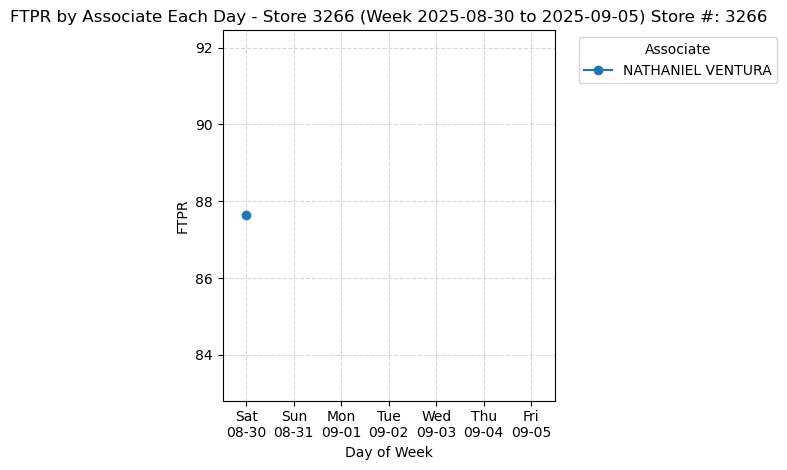

      Associate ID     Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market          Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71566      n0v0359  NATHANIEL VENTURA     3266       2025-08-30  87.63            97          85       59.2        1.64                 87                10       0.0             1                          0                            0                           0                       0                     0                    0               97     178  NATHAN

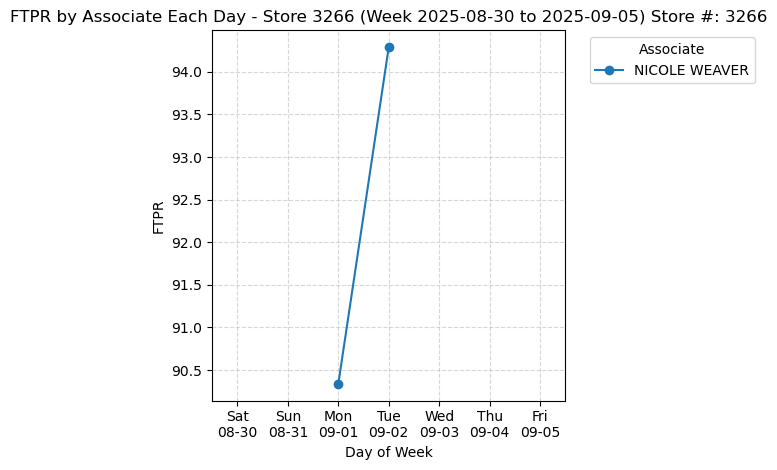

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
61805      n0w044f  NICOLE WEAVER     3266       2025-09-01  90.34           176         159       66.1        2.62                159                14       0.0             8                          0                            0                           0                       0                     0                    0              176     178  NICOLE WEAVER     

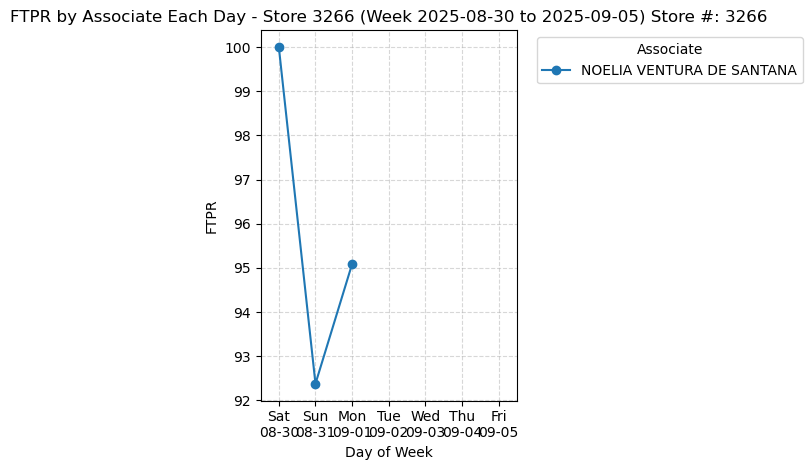

      Associate ID             Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market                  Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71580      n0v03hh  NOELIA VENTURA DE SANTANA     3266       2025-08-30  100.00            19          19       77.2        0.25                 19                 0       0.0             0                          0                            0                           0                       0                     0                    0       

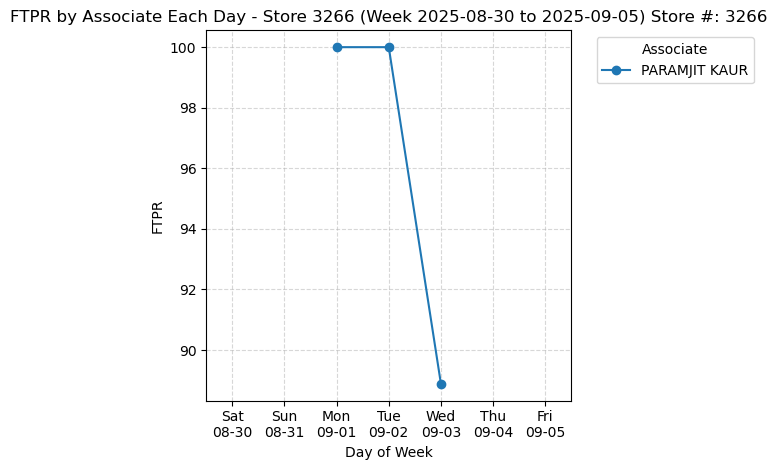

      Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market      Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
61966      p0k010w  PARAMJIT KAUR     3266       2025-09-01  100.00             3           3       10.1        0.30                  3                 0       0.0             0                          0                            0                           0                       0                     0                    0                3     178  PARAMJIT KAUR   

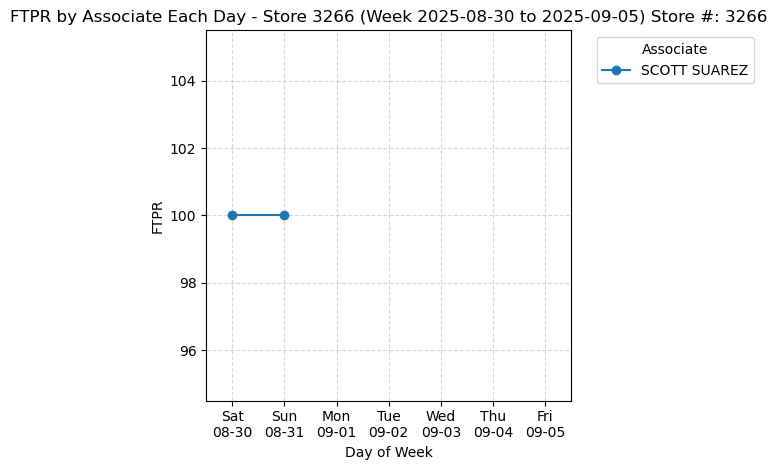

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71717      sps0025   SCOTT SUAREZ     3266       2025-08-30  100.0            16          16       40.5        0.40                 16                 0       0.0             0                          0                            0                           0                       0                     0                    0               16     178  SCOTT SUAREZ       

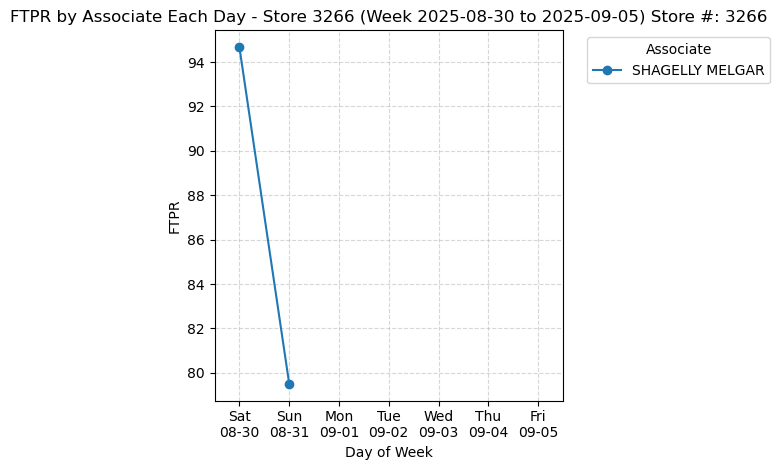

      Associate ID   Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market        Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71721      s0m160e  SHAGELLY MELGAR     3266       2025-08-30  94.67           169         160       39.4        4.52                172                 6       0.0            10                          0                            0                           0                       0                     0                    0              169     178  SHAGELLY MEL

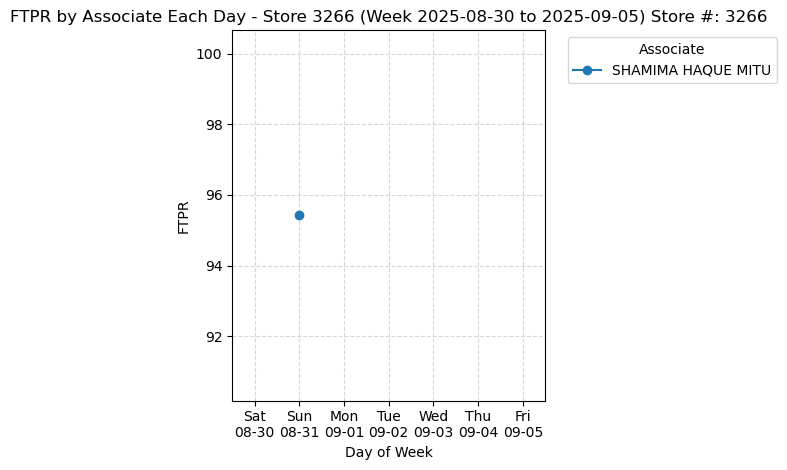

      Associate ID      Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market           Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
70326      s0m0uve  SHAMIMA HAQUE MITU     3266       2025-08-31  95.42           153         146       55.5        2.72                146                 5       0.0             5                          0                            0                           0                       0                     0                    0              153     178  SHA

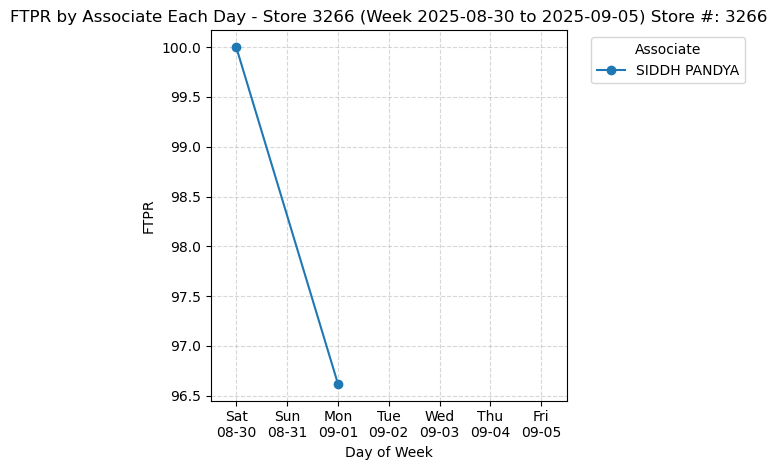

      Associate ID Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71786      s0p0hsd   SIDDH PANDYA     3266       2025-08-30  100.00             3           3        7.2        0.42                  3                 0       0.0             0                          0                            0                           0                       0                     0                    0                3     178  SIDDH PANDYA     

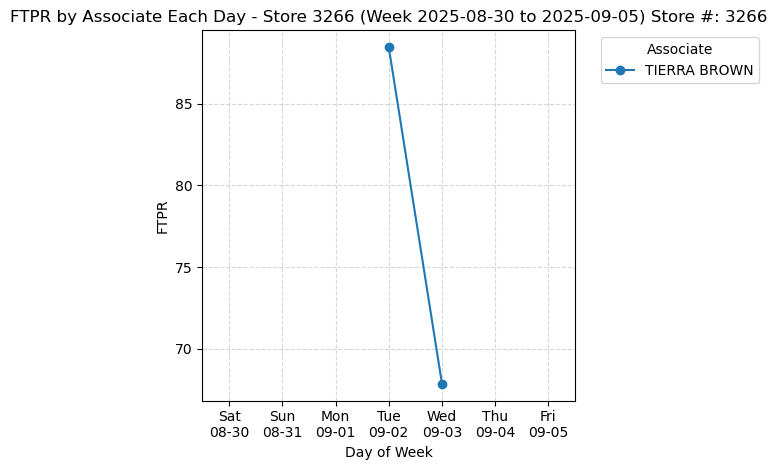

      Associate ID Associate Name  Store # Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market     Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
60744      t0b0hm5   TIERRA BROWN     3266       2025-09-02  88.46            78          69       47.4        1.54                 69                 4       0.0             5                          0                            0                           0                       0                     0                    0               78     178  TIERRA BROWN       

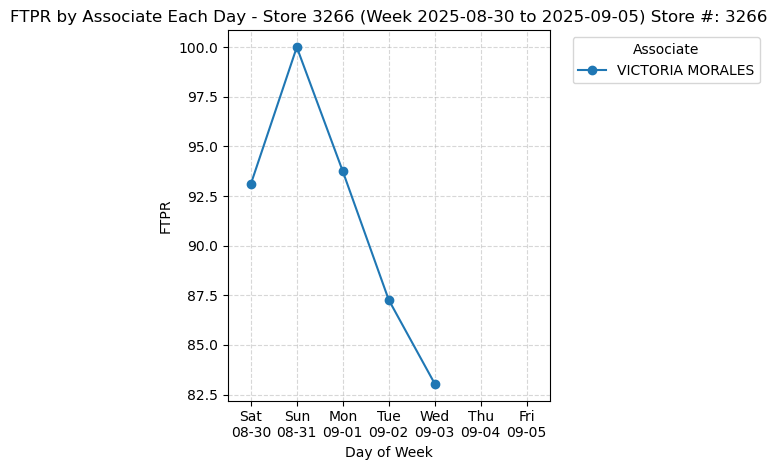

      Associate ID    Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market         Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
71855      v0m07r6  VICTORIA MORALES     3266       2025-08-30   93.10            58          54       27.8        1.98                 55                 0       0.0             0                          2                            0                           0                       2                     0                    0               58     178  VICTORI

In [484]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime formats
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])

# Get current week data
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df['Week'].max()

df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

df_selected_store = df[df['Store #'] == selected_store].copy()
if selected_store == 3266:
        df_selected_store = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]
# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
df_cw = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

#df_wtd = df.loc[df['Week'] == week_of_interest, :]
if df_cw.empty:
    print("No data available for the current week-to-date (WTD).")
else:

    #df_cw = df_selected_store[df_selected_store['Week'] == week_of_interest]
    df_cw = df_cw.sort_values(['Associate', 'Day of Pick Date'])

    # Set full week for consistent x-axis
    #week_start = df_cw['Day of Pick Date'].min().normalize()
    week_start = df_cw['Day of Pick Date'].min()
    week_dates = pd.date_range(start=week_start, periods=7, freq='D')

    # Plot
    plt.figure(figsize=(14, 7))
    for associate, group in df_cw.groupby('Associate'):
        plt.plot(group['Day of Pick Date'], group['FTPR'], marker='o', label=associate)

        plt.title(f'FTPR by Associate Each Day - Store {selected_store} (Week {week_of_interest}) Store #: {selected_store}')
        plt.xlabel('Day of Week')
        plt.ylabel('FTPR')
        plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])  # e.g., Mon\n05-13
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])
        # Add timedelta padding to the min and max
        left_pad = pd.Timedelta(days=0.5)
        right_pad = pd.Timedelta(days=0.5)

        plt.xlim(week_dates.min() - left_pad, week_dates.max() + right_pad)
        plt.legend(title='Associate', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        print(f'{df_cw.loc[df_cw['Associate'] == associate]}')


In [485]:
run_test_models = False

<h1>disregard the models below for now as of 4/18/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [486]:
if run_test_models:
    # Load and preprocess data
    # Assuming 'df' is the provided DataFrame
    #df = df.copy()
    features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

    X = df[features].values
    y = df[targets].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the neural network
    class MultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize the model, loss function, and optimizer
    input_dim = len(features)
    output_dim = len(targets)
    model = MultiOutputRegression(input_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)

        train_mse = mean_squared_error(y_train, y_pred_train.numpy())
        test_mse = mean_squared_error(y_test, y_pred_test.numpy())

        train_r2 = r2_score(y_train, y_pred_train.numpy())
        test_r2 = r2_score(y_test, y_pred_test.numpy())

    print("Training Metrics:")
    print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print("Testing Metrics:")
    print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


In [487]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    start_time = time.time()
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(self.relu(self.fc2(x)))
            x = self.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    # Assume df is your dataframe and contains the necessary columns
    # Features and targets
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluating the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()
    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f'Total time: {end_time - start_time}')


In [488]:
if run_test_models:
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    device = 'cpu'
    print(f"Using device: {device}")
    #device = 'cpu'
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


In [489]:
if run_test_models:
    # Check device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


<h2>Attempt to make PyTorch model better</h2>

In [490]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation (include interaction features or domain-specific knowledge)
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")


In [491]:
if run_test_models:
    # Feature importance using Random Forest for FTPR
    from sklearn.ensemble import RandomForestRegressor

    # Train a Random Forest model on FTPR to find important features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train_ftpr)
    importances = rf.feature_importances_

    # Display feature importance
    feature_importance = sorted(zip(importances, X.columns), reverse=True)
    print("Feature Importance for FTPR:")
    for importance, feature in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Select top features based on importance
    top_features = [feature for importance, feature in feature_importance if importance > 0.05]
    X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
    X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

    # Use only these features in the FTPR model
    ftpr_model = EnhancedModel(len(top_features))


In [492]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation based on Feature Importance
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    # Selecting features based on importance
    X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
            'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")

    # Feature Importance based on your provided data
    # These are the feature importance scores for FTPR as an example
    feature_importance = {
        'Picked As Req Qty': 0.2553,
        'Pick Hours per Qty Req': 0.1751,
        'Nil Pick Qty': 0.1545,
        'Qty Req to Pick': 0.1504,
        'Substitution Qty': 0.1096,
        'Pick Hours': 0.0977,
        'Exception Nil Pick Qty': 0.0210,
        'Total Exceptions': 0.0146,
        'Exception Substitution Qty': 0.0128,
        'Exception Qty Req to Pick': 0.0079,
        'Exception Picked As Req Qty': 0.0010
    }

    print("\nFeature Importance for FTPR:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")


In [493]:
if run_test_models:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor

    # Data Preprocessing
    X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Convert date column to datetime format and extract day, month, year features
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df['day_of_month'] = df['Day of Pick Date'].dt.day
    df['month'] = df['Day of Pick Date'].dt.month

    X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Split data into training and testing sets
    X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    model_ftpr = RandomForestRegressor(n_estimators=100)
    model_ftpr.fit(X_train_scaled, y_ftpr_train)

    y_ftpr_pred = model_ftpr.predict(X_test_scaled)
    print("FTPR Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
    print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

    model_pick_rate = RandomForestRegressor(n_estimators=100)
    model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

    y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
    print("Pick Rate Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
    print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_ftpr_test, y_ftpr_pred)
    plt.xlabel("Actual FTPR")
    plt.ylabel("Predicted FTPR")
    plt.title("FTPR Model Predictions")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pick_rate_test, y_pick_rate_pred)
    plt.xlabel("Actual Pick Rate")
    plt.ylabel("Predicted Pick Rate")
    plt.title("Pick Rate Model Predictions")

    plt.tight_layout()
    plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [494]:
if run_test_models:
    from sklearn.model_selection import GridSearchCV

    # Define hyperparameter grids for FTPR and Pick Rate models
    ftpr_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    pick_rate_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    # Perform grid search for FTPR model
    ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5, n_jobs=-1)
    ftpr_gs.fit(X_train_scaled, y_ftpr_train)

    print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
    print("FTPR Model Best Score:", ftpr_gs.best_score_)

    # Perform grid search for Pick Rate model
    pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5, n_jobs=-1)
    pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

    print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
    print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

    # Train models with best parameters and evaluate
    ftpr_best_model = ftpr_gs.best_estimator_
    pick_rate_best_model = pick_rate_gs.best_estimator_

    y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
    y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

    print("FTPR Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
    print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

    print("Pick Rate Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
    print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

compare pick times to pick rate

In [495]:
df.head()

Associate ID     Associate Name  Store # Day of Pick Date    FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick  Market          Associate  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  Handled_Exceptions  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
31837      l0l064x     LUCILLE LAWSON     3266       2024-12-20   96.06           205         195       39.0        5.09                195                 2       0.0             1                          1                            0                           1                       0                     0                    0              205     178     LUCILLE LAWSON              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20                   1           80.027                        0        0.009756          0       3.688879  4.575329       98.864128            40.242222            102.974602
9870       d0r0khi       DANIEL RUSSO     3266       2024-12-20   96.97            34          32       81.0        0.42                 32                 2       0.0             0                          0                            0                           0                       0                     0                    0               34     178       DANIEL RUSSO              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20                   0           59.833                        0        0.000000          0       4.406719  4.584661       99.984360           171.058670             35.982300
19968      e0s0frj        ERICKA SUIN     3266       2024-12-20   90.91            55          50       45.0        1.11                 50                 0       0.0             5                          0                            0                           0                       0                     0                    0               55     178        ERICKA SUIN              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20                   0           50.884                        0        0.000000          0       3.828641  4.520810       95.753975            46.811287            114.993263
49549      s0m11qg    SHUBHADA MENGLE     3266       2024-12-20   89.26           129         108       30.0        3.88                108                 9       0.0            12                          0                            0                           0                       0                     0                    0              129     178    SHUBHADA MENGLE              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20                   0           57.766                        0        0.000000          0       3.433987  4.502694       93.002388            25.980761             65.068581
7326       c0c116s  CHRISTINA CUCITRO     3266       2024-12-20  100.00             4           4       46.0        0.09                  4                 0       0.0             0                          0                            0                           0                       0                     0                    0                4     178  CHRISTINA CUCITRO              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20                   0           44.609                        0        0.000000          0       3.850148  4.615121      100.030396            60.993137              3.999012

In [496]:
if run_test_models:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Data Preparation
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Train-Test Split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model Training for FTPR
    ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    ftpr_model.fit(X_train_scaled, y_train_ftpr)

    # Model Training for Pick Rate
    pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

    # Model Training for Picked As Req Qty
    picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

    # Predictions
    ftpr_preds = ftpr_model.predict(X_test_scaled)
    pick_rate_preds = pick_rate_model.predict(X_test_scaled)
    picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

    # Evaluation
    print("FTPR Metrics")
    print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
    print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

    print("\nPick Rate Metrics")
    print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
    print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

    print("\nPicked As Req Qty Metrics")
    print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
    print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


In [497]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    # ===========================================
    # Load and Preprocess Data
    # ===========================================

    # Example DataFrame (replace with actual data loading)
    # df = pd.read_csv('your_dataset.csv')

    # Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

    # Drop irrelevant columns
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite Score", "Associate ID"
    ])

    # Target variables
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]

    # Convert categorical features to numeric using one-hot encoding
    X_numeric = pd.get_dummies(X, drop_first=True)

    # Ensure all columns are numeric
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

    # Scale numeric features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===========================================
    # Train and Evaluate Models
    # ===========================================

    # Define a function to train and evaluate models
    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        return model

    # Train Random Forest Regressor for FTPR
    ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    # Train Random Forest Regressor for Pick Rate
    pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

    # ===========================================
    # Notes
    # ===========================================
    # - Handled datetime columns by extracting numeric features.
    # - Dropped irrelevant columns to avoid data leakage.
    # - Converted categorical features to numeric using `pd.get_dummies`.
    # - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
    # - Scaled features using `StandardScaler` for improved model performance.


In [498]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model

    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

In [499]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model


    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

<h1>Put dataframe df into a single .csv</h1>

In [500]:
df.drop_duplicates(inplace=True)
combine_data_to_csv()

Directory 'Data/Combined/' already exists.


In [501]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
print(cpu_info())
notebook_end_time = time.time()
print(f"Total time taken: {notebook_end_time - notebook_start_time:.2f} seconds. Last run date: {datetime.now().date() } at {datetime.now().time()}")

Platform: macOS-15.7-arm64-arm-64bit
Platform processor: arm
Apple M4 Max
Total time taken: 96.84 seconds. Last run date: 2025-09-04 at 15:01:08.930027
